# Importation des librairies

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings
import datetime

# import categorical api 
from pandas.api.types import CategoricalDtype

import zipfile

warnings.filterwarnings("ignore")

# Lecture du fichier accident.cvs

### Lecture du fichier de conf

In [20]:
file = open('../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)

# Définition d'une fonction pointant vers le répertoire des données
def datapath(fich):
    return conf['data_path'] + fich

### Lecture des données

In [21]:
myZip = zipfile.ZipFile('../../data/accidents.zip')
myZip.extractall('../../data')

In [22]:
fich = "../../data" + conf['local_data_path'] + "accidents.csv"
print(fich)

../../data/Users/vanessaibert/Ecole_Synchro/Ecoles/Data_Scientist/Formation/Projet/Mon_projet/Données/GitHub/sept23_cds_accidents2/data/accidents.csv


In [23]:
# Lecture des données
df = pd.read_csv(fich, sep = ";", low_memory=False)
#print(df.shape)
#df.info()
df.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,etatp,id_usager,senc,catv,obs,obsm,choc,manv,motor,occutc
0,201900000001,30,11,2019,01:30,4.0,93,93053,1,1.0,...,NaN,NaN,2.0,7.0,0.0,2.0,5.0,23.0,1.0,NaN
1,201900000001,30,11,2019,01:30,4.0,93,93053,1,1.0,...,NaN,NaN,2.0,7.0,0.0,2.0,5.0,23.0,1.0,NaN
2,201900000001,30,11,2019,01:30,4.0,93,93053,1,1.0,...,NaN,NaN,2.0,17.0,1.0,0.0,3.0,11.0,1.0,NaN
3,201900000002,30,11,2019,02:50,3.0,93,93066,1,1.0,...,NaN,NaN,1.0,7.0,4.0,0.0,1.0,0.0,1.0,NaN
4,201900000003,28,11,2019,15:15,1.0,92,92036,1,1.0,...,NaN,NaN,1.0,7.0,0.0,2.0,1.0,2.0,1.0,NaN


In [24]:
df.shape

(494182, 55)

In [25]:
df.columns

Index(['Num_Acc', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg',
       'int', 'atm', 'col', 'adr', 'lat', 'long', 'catr', 'voie', 'v1', 'v2',
       'circ', 'nbv', 'vosp', 'prof', 'pr', 'pr1', 'plan', 'lartpc', 'larrout',
       'surf', 'infra', 'situ', 'vma', 'id_vehicule', 'num_veh', 'place',
       'catu', 'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2', 'secu3',
       'locp', 'actp', 'etatp', 'id_usager', 'senc', 'catv', 'obs', 'obsm',
       'choc', 'manv', 'motor', 'occutc'],
      dtype='object')

In [26]:
# Ajout de la variable catégorielle pour la gravité

df.grav = df.grav.astype('str')
df.grav.dtypes
# Define an ordered dictionnary of categories 
grav_mapping = {'1.0':'Indemne',
                '4.0':'Blessé léger', 
                '3.0':'Blessé hospitalisé',
                '2.0':'Tué'#,
                #'nan' : "Non renseigné"
                }

# Define the new orderded type
cat_grav_order = CategoricalDtype(categories=grav_mapping.values(), ordered=True)

# Recode the gravity with the dictionnary and format the created variable with the new ordered type
df["grav_rec"] = df.grav.map(grav_mapping).astype(cat_grav_order)

# Suppression des lignes dupliquées

In [27]:
print("Nombre de lignes dupliquées :", df.duplicated().sum())
df = df.drop_duplicates()

#Initialisation du data_cleaned à df
data_cleaned = df

Nombre de lignes dupliquées : 164


In [28]:
df.shape

(494018, 56)

# Création de la variable nombre de personnes dans l'accident

Ces variables sont créées après les modélisations afin d'essayer d'améliorer les résulats obtenues, mais nécessitent d'être mise au début du processus de nettoyage pour être créées.

In [29]:
nb_pers = pd.DataFrame(data_cleaned.value_counts('Num_Acc')).reset_index().rename(columns = {"count" : "nb_usagers"})
display(nb_pers.head())

,Num_Acc,nb_usagers
0,202200032758,39
1,202200019645,38
2,202200041415,36
3,202200015893,35
4,202200033682,31


In [30]:
data_cleaned = pd.merge(data_cleaned, nb_pers, how="left", on=["Num_Acc"])

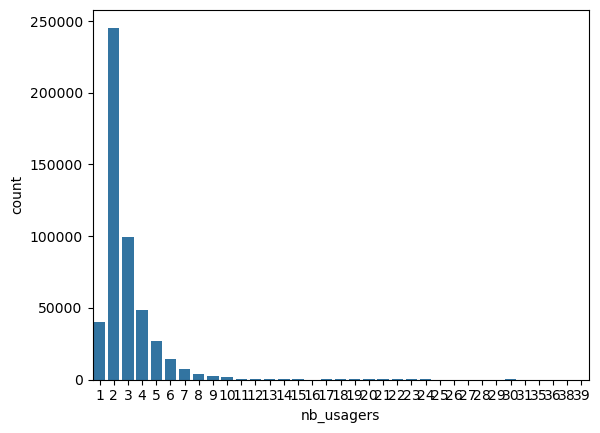

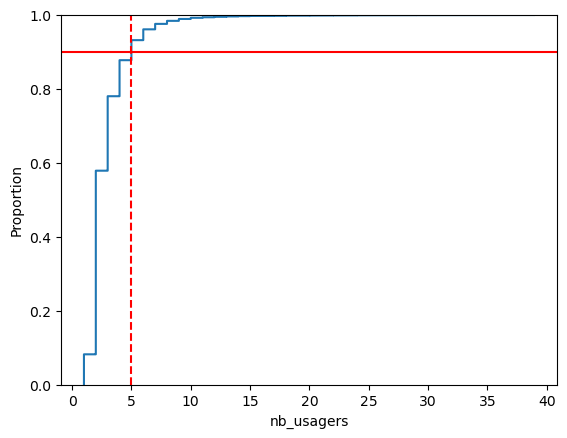

In [31]:
sns.countplot(data=data_cleaned, x="nb_usagers")
plt.show()

sns.ecdfplot(data=data_cleaned, x="nb_usagers")
plt.axhline(y=0.9, c="red")
plt.axvline(5, c="red", linestyle="--" )
plt.show()

## Regroupement lorsque 5 usagers et +

In [32]:
data_cleaned["nb_usagers_gr"]= data_cleaned["nb_usagers"]
data_cleaned.nb_usagers_gr[ data_cleaned.nb_usagers >5] = 5

In [33]:
pd.crosstab(data_cleaned.grav_rec, data_cleaned.nb_usagers_gr, normalize=1)

nb_usagers_gr,1,2,3,4,5
grav_rec,,,,,
Indemne,0.000000,0.439255,0.466485,0.472666,0.503162
Blessé léger,0.525680,0.389273,0.389222,0.395630,0.379511
Blessé hospitalisé,0.381142,0.149729,0.124490,0.112720,0.099778
Tué,0.093178,0.021743,0.019803,0.018984,0.017549


# Exploration des variables

In [34]:
# Création d'un df_var d'exploration synthétique des variables
liste_var = []
type_var = []
format_var = []
nan_var = []
liste_nunique = []
liste_valeurs = []
nb_non_renseigne = []

liste = ['actp', 'grav_rec']

for i in df.columns :
    liste_var.append(i)
    nan_var.append(round(100*df[i].isnull().sum()/df.shape[0],2))
    format_var.append(df[i].dtype)
    liste_nunique.append(df[i].nunique())
    if (i == 'actp') | (i == 'grav_rec'):
        liste_valeurs.append(df[i].unique())
    else :
        if df[i].nunique() < 20 :
            liste_valeurs.append(sorted(df[i].unique())) 
        else :
            liste_valeurs.append('>20')
    if i == 'grav' :
        type_var.append('Cible')
    else :
        type_var.append('Explicative')
                

dict = {'Variable':liste_var,
        'Type variable':type_var ,
        'Format_variable':format_var,
        '%NaN':nan_var,
        'Nombre modalités':liste_nunique,
        'Valeurs':liste_valeurs}
df_var = pd.DataFrame.from_dict(dict)


In [35]:
# Affichage du tableau de synthèse des variables, par ordre de pourcentage de valeurs manquantes décroissant
#df_var.sort_values("%NaN", ascending=False)
df_var

,Variable,Type variable,Format_variable,%NaN,Nombre modalités,Valeurs
0,Num_Acc,Explicative,int64,0.00,218404,>20
1,jour,Explicative,int64,0.00,31,>20
2,mois,Explicative,int64,0.00,12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
3,an,Explicative,int64,0.00,4,"[2019, 2020, 2021, 2022]"
4,hrmn,Explicative,object,0.00,1438,>20
5,lum,Explicative,float64,0.00,5,"[1.0, 2.0, 3.0, 4.0, 5.0, nan]"
6,dep,Explicative,object,0.00,116,>20
7,com,Explicative,object,0.00,21259,>20
8,agg,Explicative,int64,0.00,2,"[1, 2]"
9,int,Explicative,float64,0.00,9,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ..."


On constate 54 variables (dont la cible), dans des formats soit objet, soit int ou float. Elles sont toutes catégorielles hormis celle représentant la date de l'accident.
Certaines variables ont beaucoup de modalités différentes et certaines ont beaucoup d'observations non renseignées.

Concernant les variables avec beaucoup de valeurs manquantes .

In [36]:
#-----------Lecture du nom des variables ---------------
varname = pd.read_csv(conf['local_data_path'] + ("varname.csv"), sep=";", encoding = "ISO-8859-1" )[["var", "nomvar"]].drop_duplicates(subset="var")

# Rajout du nom des variables aux pourcentages de valeurs manquantes
nan_values2 = pd.merge(df_var, varname, how="left", left_on = "Variable", right_on = "var").sort_values("%NaN", ascending=False)
nan_values2["nomvar2"] = nan_values2["Variable"] + " : " + nan_values2["nomvar"]

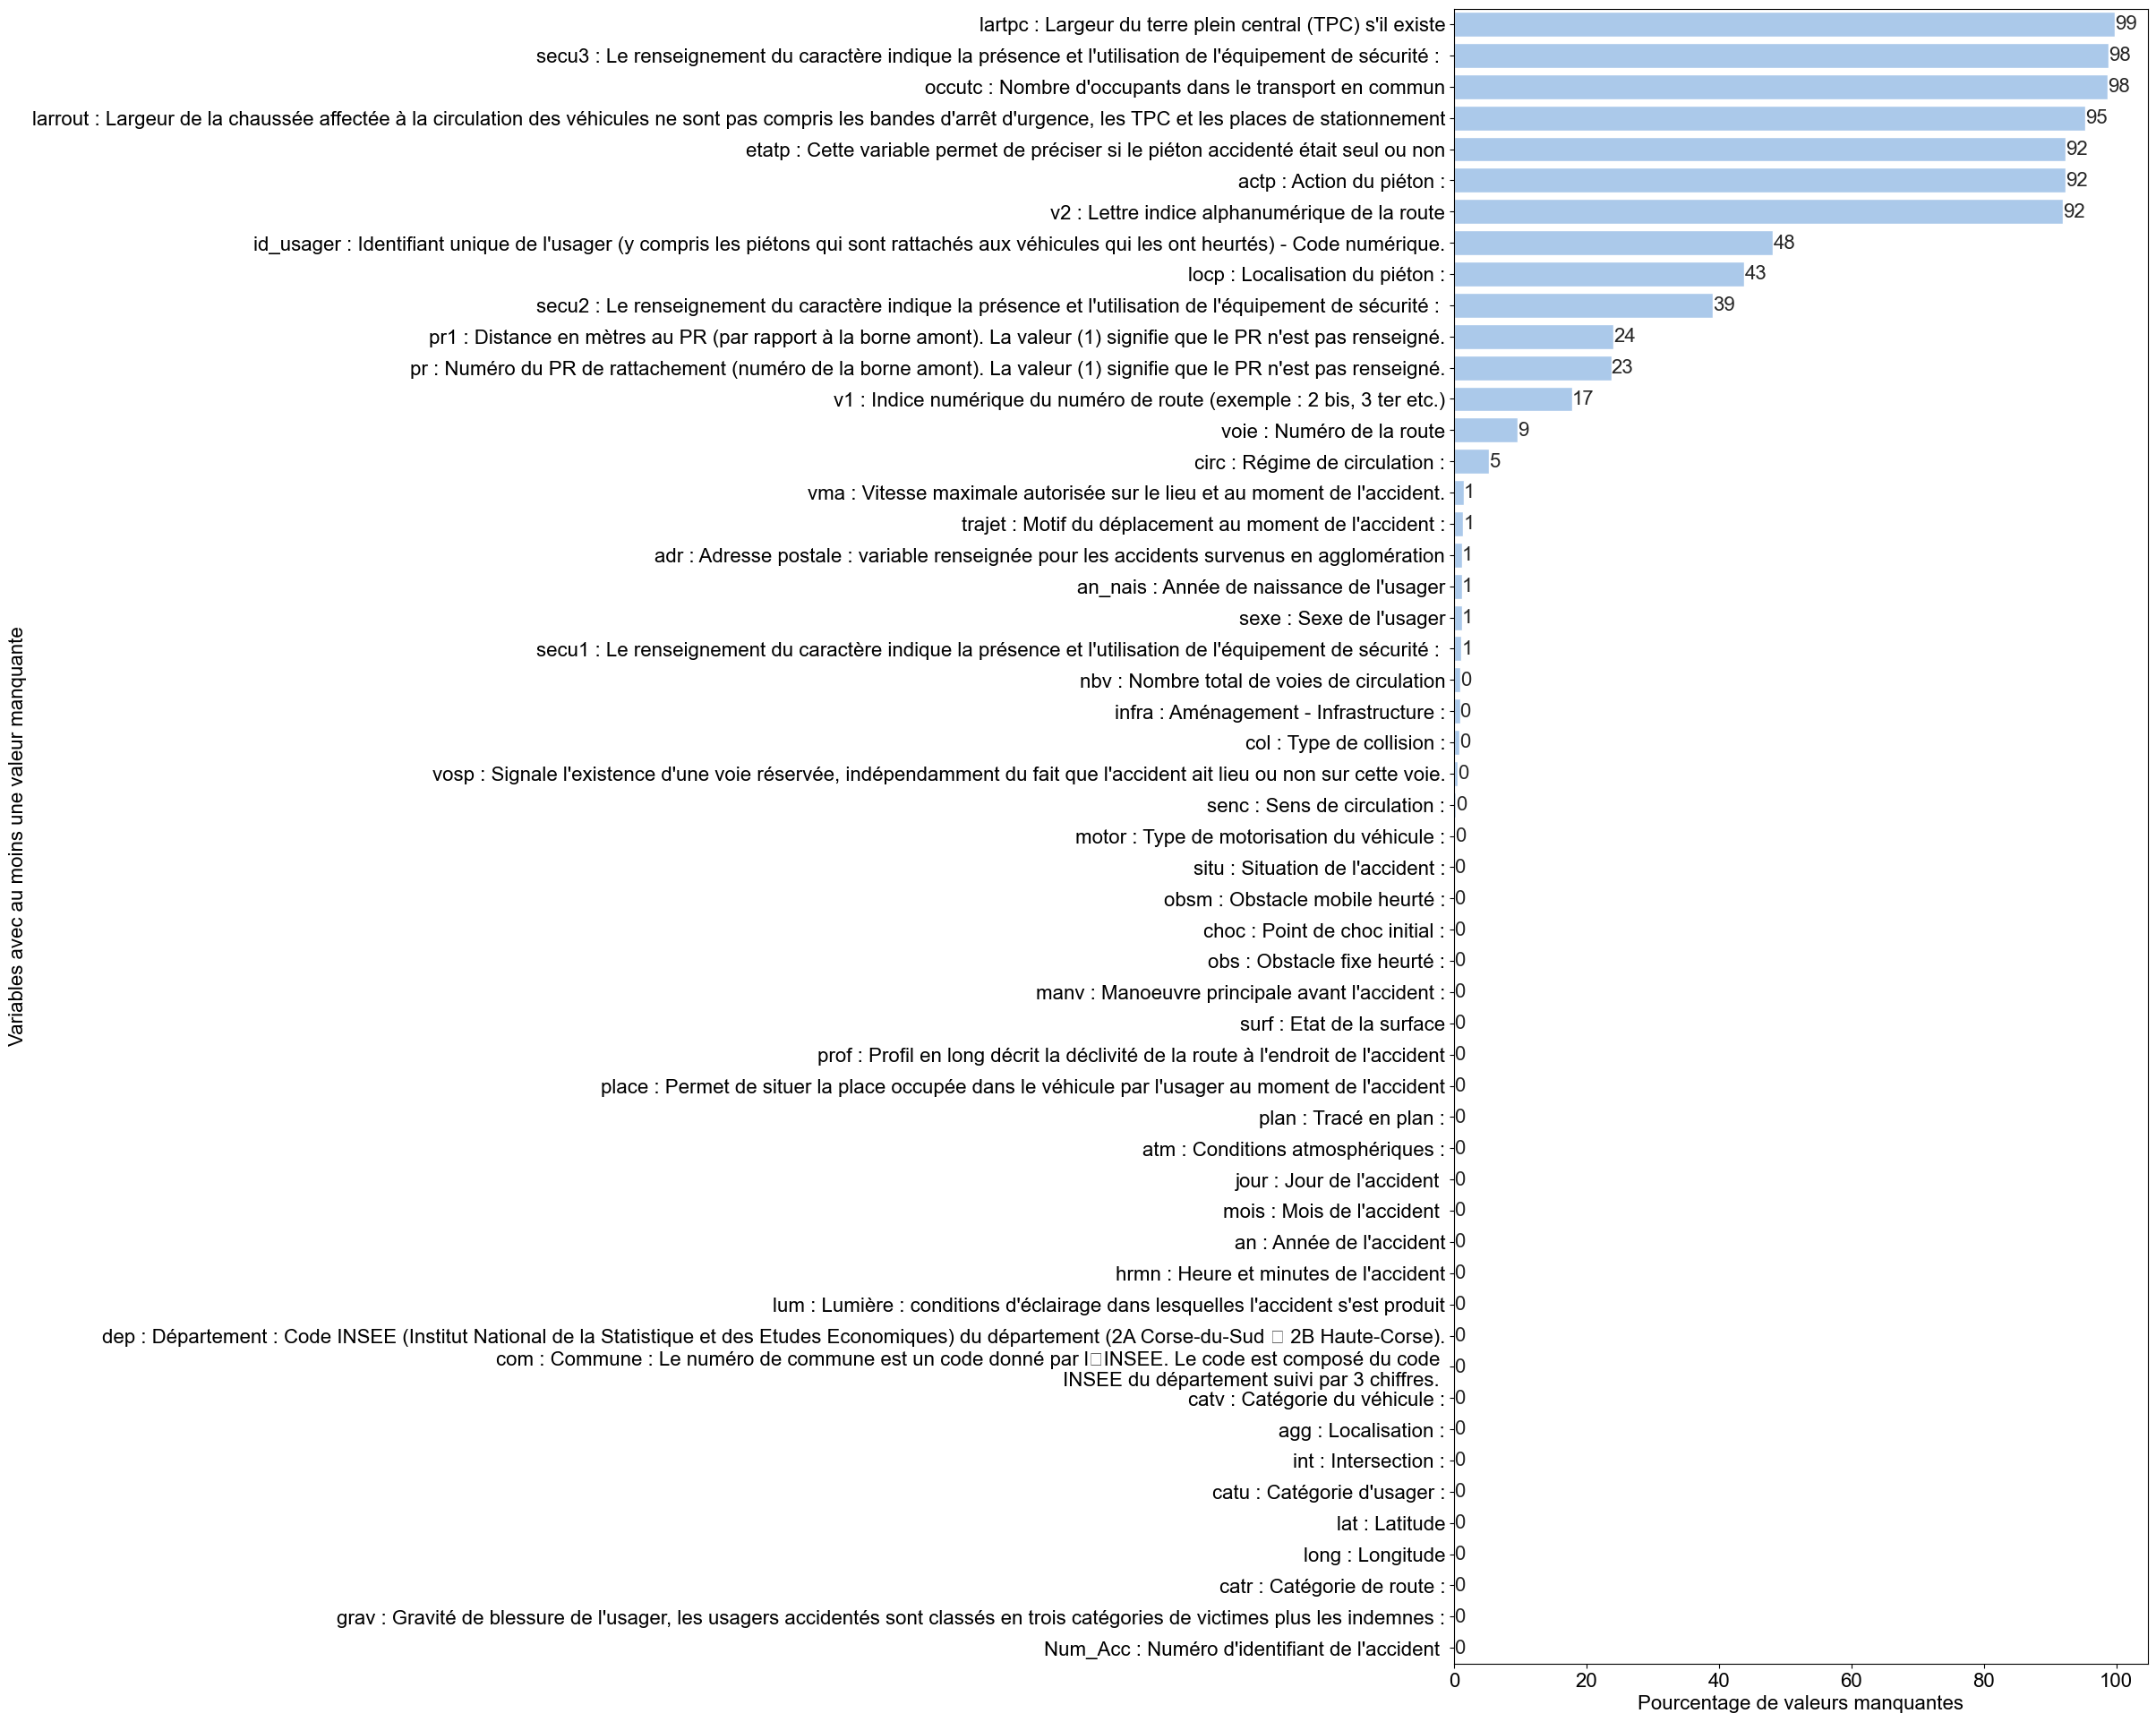

In [37]:
#--------------- Barplot des % de valeurs manquantes ---------------------
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 24))

#plt.bar(x = nan_values.index, height=nan_values.values, hori )
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(y= nan_values2["nomvar2"], x=nan_values2["%NaN"], color="b", orient='h')
#ax.set(xlabel='Pourcentage de valeurs manquantes', ylabel='Variables avec au moins une valeur manquante')
plt.xlabel('Pourcentage de valeurs manquantes', fontsize=16)
plt.ylabel('Variables avec au moins une valeur manquante', fontsize=16)

# Set tick font size #https://stackabuse.com/change-font-size-in-matplotlib/
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

# Ajout du % de valeur manquante à droite de chaque barre
ax.bar_label(ax.containers[0], fontsize=16, fmt='%d');

In [38]:
print(f'Il y a {df_var.loc[df_var["%NaN"] > 8].shape[0]} variables avec plus de avec 8% de données manquantes : elle seront supprimées.') # f-string
print(f'Ces variables sont :\n{df_var.loc[df_var["%NaN"] > 8, "Variable" ].to_list()}')
print("Nous gardons cependant secu2 et secu 3 qui seront retraité par la suite avec secu1.")
print( "Nous supprimerons aussi les identifiants usager, véhicule, accident : id_usager, id_vehicule et num_veh, et Numm_Acc.")


Il y a 14 variables avec plus de avec 8% de données manquantes : elle seront supprimées.
Ces variables sont :
['voie', 'v1', 'v2', 'pr', 'pr1', 'lartpc', 'larrout', 'secu2', 'secu3', 'locp', 'actp', 'etatp', 'id_usager', 'occutc']
Nous gardons cependant secu2 et secu 3 qui seront retraité par la suite avec secu1.
Nous supprimerons aussi les identifiants usager, véhicule, accident : id_usager, id_vehicule et num_veh, et Numm_Acc.


# Gestion des valeurs manquantes et regroupement de données

#### 0.Num_Acc

Numéro d'identifiant de l'accident

Suppression de la variable car elle ne servait qu'à faire la jointure entre les dataframes

In [39]:
#Besoin de cette variable par la suite, sera supprimer ultérieurement
#data_cleaned = data_cleaned.drop('Num_Acc', axis = 1)

#### 1.Jour

Correspond au numéro du jour dans le mois

In [40]:
# création d'une variable date, qui pourra servir sous différentes formes, si on fait des séries temporelles
dates_str = data_cleaned.an.astype('str') + "-" + data_cleaned.mois.astype('str') + "-" + data_cleaned.jour.astype('str')
data_cleaned['date'] = pd.to_datetime(dates_str)
data_cleaned['date'].isna().sum()

0

In [41]:
# création d'une variable weekend à partir du jour de la semaine (Saturday is 5 and Sunday is 6)
data_cleaned['weekend'] = data_cleaned['date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
data_cleaned['weekend'].value_counts()

weekend
0    359024
1    134994
Name: count, dtype: int64

In [42]:
df_weekend = pd.crosstab(data_cleaned.weekend, data_cleaned.grav_rec, normalize='index')*100
df_weekend

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
weekend,,,,
0,42.894608,40.182603,14.489761,2.433029
1,39.555243,39.465550,17.779919,3.199288


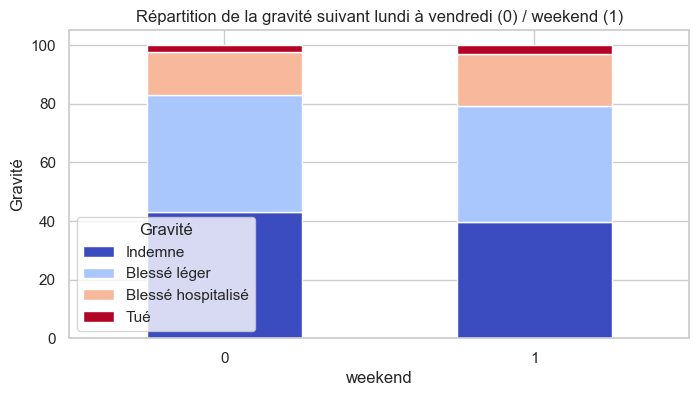

In [43]:
df_weekend.plot(kind='bar', stacked=True, figsize=(8, 4), rot=0, colormap='coolwarm')
plt.title("Répartition de la gravité suivant lundi à vendredi (0) / weekend (1)")
plt.ylabel('Gravité')
plt.legend(title="Gravité")
plt.show()

In [44]:
# création d'une variable vendredi_weekend à partir du jour de la semaine (Friday is 4, Saturday is 5 and Sunday is 6)
data_cleaned['vendredi_weekend'] = data_cleaned['date'].dt.weekday.apply(lambda x: 1 if x >= 4 else 0)
data_cleaned['vendredi_weekend'].value_counts()

vendredi_weekend
0    277534
1    216484
Name: count, dtype: int64

In [45]:
df_vendredi_weekend = pd.crosstab(data_cleaned.vendredi_weekend, data_cleaned.grav_rec, normalize='index')*100
df_vendredi_weekend

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
vendredi_weekend,,,,
0,42.953148,40.369549,14.278298,2.399005
1,40.737317,39.495822,16.812417,2.954445


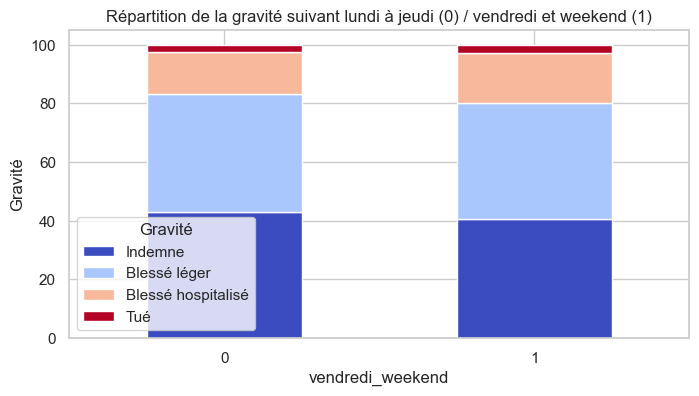

In [46]:
df_vendredi_weekend.plot(kind='bar', stacked=True, figsize=(8, 4), rot=0, colormap='coolwarm')
plt.title("Répartition de la gravité suivant lundi à jeudi (0) / vendredi et weekend (1)")
plt.ylabel('Gravité')
plt.legend(title="Gravité")
plt.show()

La proportion de tués passe de 2.43% à 3.20% le week-end, et celle de blessés hospitalisés de 14.49 à 17.78%, alors que dans le cas de la variable vendredi et weekend, la proportion de tués passe de 2.40% à 2.95%, et celle de blessés hospitalisés de 14.28 à 16.81%. La différence entre les modalités 0 et 1 étant plus importantes pour les blessés hospitalisés et les tués dans le cas de la variable weekend, nous estimons que la variable weekend est le p-meilleur choix.
De plus la p_value du test du Chi_2 de la variable vendredi_weekend est supérieur à 5% (voir notebook StatistiquePostNettoyage), ce qui confirme le fait de devoir garder la variable weekend et non vendredi_weekend.


In [47]:
#Suppression de la variable 
data_cleaned.drop('vendredi_weekend', axis=1, inplace=True)

On garde la variable weekend (0= jour de semaine (lundi-vendredi), 1=weekend (samedi, dimanche)).

#### 2.Mois

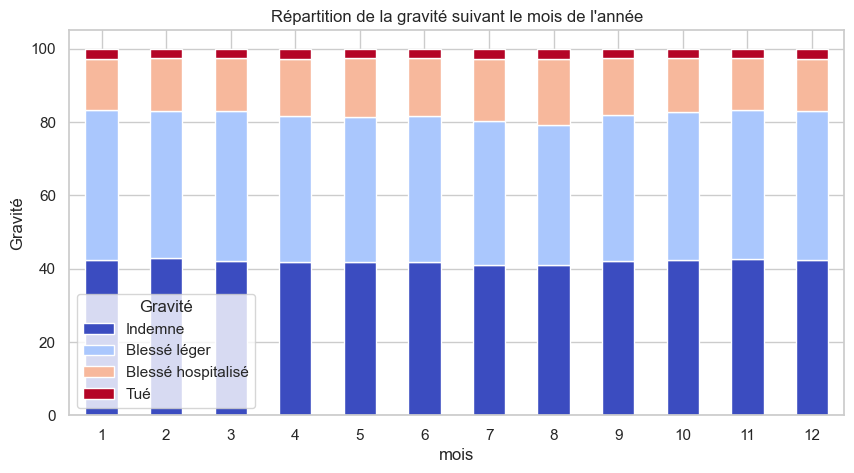

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué,hospitalisés + tués
mois,,,,,
1,42.335708,40.908007,14.046566,2.709718,16.756284
2,42.790529,40.079299,14.527838,2.602334,17.130173
3,42.171084,40.672619,14.595950,2.560347,17.156297
4,41.904823,39.839546,15.494410,2.761220,18.255630
5,41.741595,39.601251,16.123436,2.533718,18.657154
6,41.752761,39.837381,15.955909,2.453949,18.409858
7,41.026430,39.310246,16.833774,2.829550,19.663325
8,40.950368,38.211695,18.019988,2.817950,20.837938
9,42.118831,39.903594,15.441685,2.535890,17.977575


In [48]:
df_mois = pd.crosstab(data_cleaned.mois, data_cleaned.grav_rec, normalize='index')*100

df_mois.plot(kind='bar', stacked=True, figsize=(10,5), rot=0, colormap='coolwarm')
plt.title("Répartition de la gravité suivant le mois de l'année")
plt.ylabel('Gravité')
plt.legend(title="Gravité")
plt.show()

df_mois["hospitalisés + tués"] = df_mois["Blessé hospitalisé"] + df_mois["Tué"]
display(df_mois)

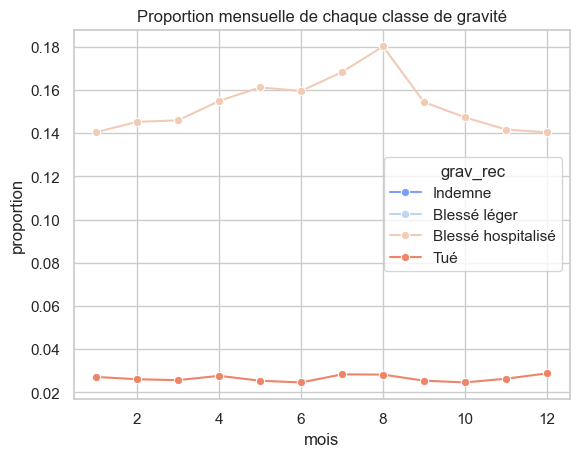

In [49]:
# série temporelle mois de l'année
df_mois2 = pd.DataFrame(data_cleaned.groupby('mois')['grav_rec'].value_counts(normalize=True)).reset_index()
 
# Plot de la série mensuelle 2019-2022, échelle réelle
sns.lineplot(data=df_mois2.loc[df_mois2["grav_rec"].isin(["Tué", "Blessé hospitalisé"])], x='mois', y='proportion', hue="grav_rec", palette="coolwarm", marker='o')
plt.title("Proportion mensuelle de chaque classe de gravité")
plt.show()

Plus de blessés hospitalisés et de tués durant les mois d'été (juillet-août) --> création d'une variable "saison".

In [50]:
data_cleaned["saison"] = "hiver"
data_cleaned.loc[ (data_cleaned["mois"] >= 3) &  (data_cleaned["mois"] <= 5), "saison"] = "printemps"
data_cleaned.loc[ (data_cleaned["mois"] >= 6) &  (data_cleaned["mois"] <= 8), "saison"] = "été"
data_cleaned.loc[ (data_cleaned["mois"] >= 9) &  (data_cleaned["mois"] <= 11), "saison"] = "automne"

data_cleaned["saison"].value_counts()

saison
été          138207
automne      133665
hiver        114619
printemps    107527
Name: count, dtype: int64

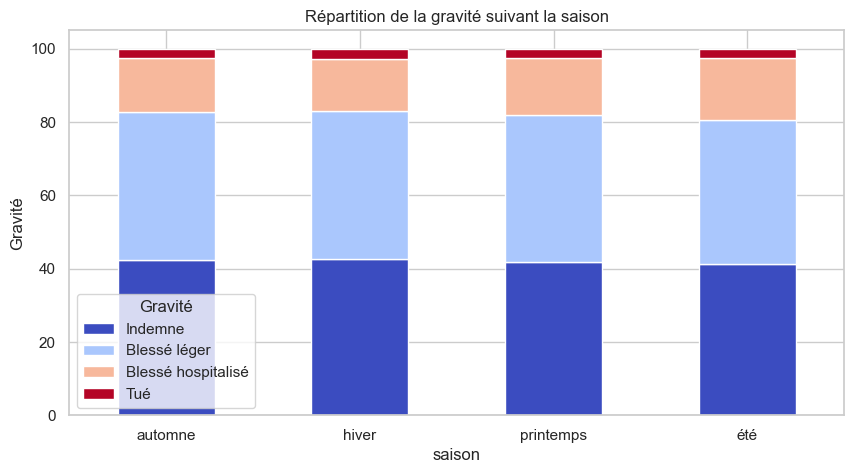

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué,hospitalisés + tués
saison,,,,,
automne,42.316360,40.325539,14.823716,2.534385,17.358101
hiver,42.518111,40.551628,14.194815,2.735446,16.930261
printemps,41.930621,40.024007,15.437153,2.608218,18.045372
été,41.254453,39.161285,16.887978,2.696284,19.584263


In [51]:
df_saison = pd.crosstab(data_cleaned.saison, data_cleaned.grav_rec, normalize='index')*100

df_saison.plot(kind='bar', stacked=True, figsize=(10,5), rot=0, colormap='coolwarm')
plt.title("Répartition de la gravité suivant la saison")
plt.ylabel('Gravité')
plt.legend(title="Gravité")
plt.show()

df_saison["hospitalisés + tués"] = df_saison["Blessé hospitalisé"] + df_saison["Tué"]
display(df_saison)

Définition : Intersection  
1 – Hors intersection  
2 – Intersection en X  
3 – Intersection en T  
4 – Intersection en Y  
5 – Intersection à plus de 4 branches  
6 – Giratoire  
7 – Place  
8 – Passage à niveau  
9 – Autre intersection

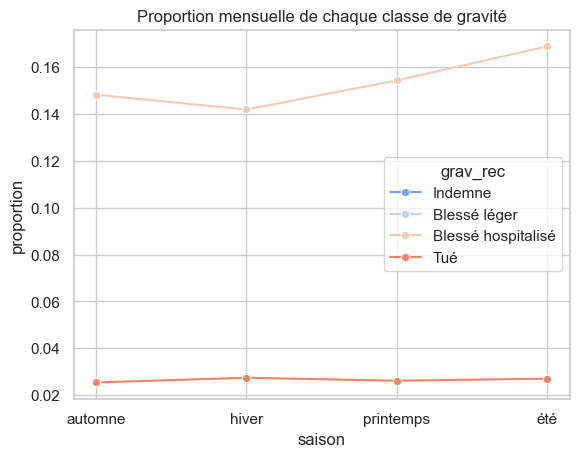

In [52]:
# série temporelle saison
df_saison2 = pd.DataFrame(data_cleaned.groupby('saison')['grav_rec'].value_counts(normalize=True)).reset_index()
 
# Plot de la série mensuelle 2019-2022, échelle réelle
sns.lineplot(data=df_saison2.loc[df_saison2["grav_rec"].isin(["Tué", "Blessé hospitalisé"])], x='saison', y='proportion', hue="grav_rec", palette="coolwarm", marker='o')
plt.title("Proportion mensuelle de chaque classe de gravité")
plt.show()


=> La variation liée à la saison est moins marquée que la variation selon le mois de l'année : on préfère garder la variable mois, en continu.

Suppression de la variable saison.

In [53]:
data_cleaned.drop(columns="saison", inplace=True)

#### 3.An

Création d'une variable combinée an-mois pour analyse en série temporelle

In [54]:
dates_str = data_cleaned.an.astype('str') + "-" + data_cleaned.mois.astype('str') + "-" + "01"
data_cleaned["an-mois"] = pd.to_datetime(dates_str)

In [55]:
data_cleaned.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,choc,manv,motor,occutc,grav_rec,nb_usagers,nb_usagers_gr,date,weekend,an-mois
0,201900000001,30,11,2019,01:30,4.0,93,93053,1,1.0,...,5.0,23.0,1.0,NaN,Blessé léger,3,3,2019-11-30,1,2019-11-01
1,201900000001,30,11,2019,01:30,4.0,93,93053,1,1.0,...,5.0,23.0,1.0,NaN,Blessé léger,3,3,2019-11-30,1,2019-11-01
2,201900000001,30,11,2019,01:30,4.0,93,93053,1,1.0,...,3.0,11.0,1.0,NaN,Indemne,3,3,2019-11-30,1,2019-11-01
3,201900000002,30,11,2019,02:50,3.0,93,93066,1,1.0,...,1.0,0.0,1.0,NaN,Blessé léger,1,1,2019-11-30,1,2019-11-01
4,201900000003,28,11,2019,15:15,1.0,92,92036,1,1.0,...,1.0,2.0,1.0,NaN,Indemne,4,4,2019-11-28,0,2019-11-01


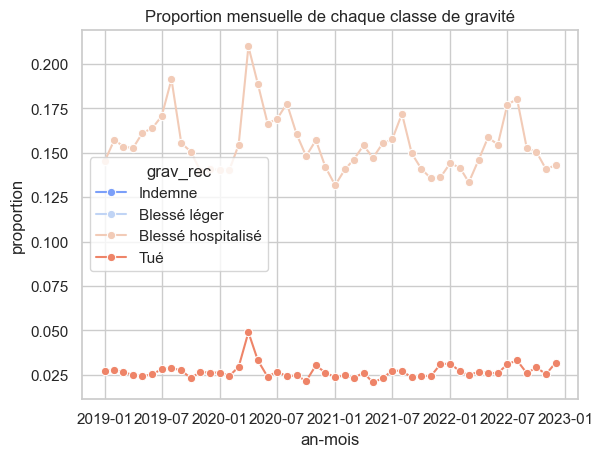

In [56]:
df_an_mois = pd.DataFrame(data_cleaned.groupby('an-mois')['grav_rec'].value_counts(normalize=True)).reset_index()
 
# Plot de la série mensuelle 2019-2022, échelle réelle
sns.lineplot(data=df_an_mois.loc[df_an_mois["grav_rec"].isin(["Tué", "Blessé hospitalisé"])], x='an-mois', y='proportion', hue="grav_rec", palette="coolwarm", marker='o')
plt.title("Proportion mensuelle de chaque classe de gravité")
plt.show()

# # Plot de la série mensuelle 2019-2022, échelle log
# f, ax = plt.subplots(figsize=(16, 6))
# sns.lineplot(data=df_an_mois, x='an-mois', y='proportion', hue="grav_rec", palette="coolwarm", marker='o') 
# plt.title("Proportion mensuelle de chaque classe de gravité, échelle log")
# ax.set(yscale="log")
# plt.show();

# plt.plot(df_mois.index, df_mois.values, "--r", linewidth=3, label="Moyenne")
# plt.xticks(np.arange(1, 13, 1), ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre'], rotation = 0)
# plt.title("Nombre d'accidents selon le mois et l'année")
# plt.ylabel("Nombre d'accidents")


On voit une se dessiner une certaine saisonnalité dans la proportion de tués et de blessés hospitalisés, avec plus de gravité en été, et un pic lors du premier confinement (avril 2020).

Toutefois, cette variable ne sera pas utilisable dans les modèles de classification que l'on souhaite développer en premier. On la supprime pour l'instant. On verra par la suite pour l'analyse temporelle.

In [57]:
# suppression des variables temporelles inutiles, on garde la variable date
data_cleaned.drop(['an-mois'], axis=1, inplace=True)
# data_cleaned.drop(['an-mois','an','jour'], axis=1, inplace=True)
# Variables ré-utilisées par la suite, ne pas les supprimer à ce stade
# Mise en commentaire (NR)

#### 4.Variable hrmn

In [58]:
# Visualisation par tranche d'heure
data_cleaned['heure'] = data_cleaned.hrmn.apply(lambda x : x.split(':')[0]).astype('int')
data_cleaned['heure'].value_counts(dropna=False) 

heure
17    44755
18    42441
16    37298
19    31635
15    31077
14    27925
8     27297
12    26002
13    25035
11    24680
9     23374
10    22303
20    21706
7     20590
21    15696
22    12493
23    10856
6      9899
0      9047
1      7223
5      6612
2      6317
3      4918
4      4839
Name: count, dtype: int64

In [59]:
df_heure = pd.crosstab(data_cleaned.heure, data_cleaned.grav_rec, normalize='index')*100
df_heure

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
heure,,,,
0,35.667662,42.205996,17.911273,4.215068
1,32.935958,41.655115,20.238425,5.170502
2,30.125258,44.220707,20.405898,5.248137
3,29.804560,42.732085,21.396580,6.066775
4,29.464101,42.209808,22.615353,5.710739
5,32.550742,41.866101,19.524387,6.058770
6,36.884666,41.544526,17.497220,4.073587
7,42.461359,39.554778,15.519588,2.464275
8,44.148371,41.828245,12.084448,1.938936


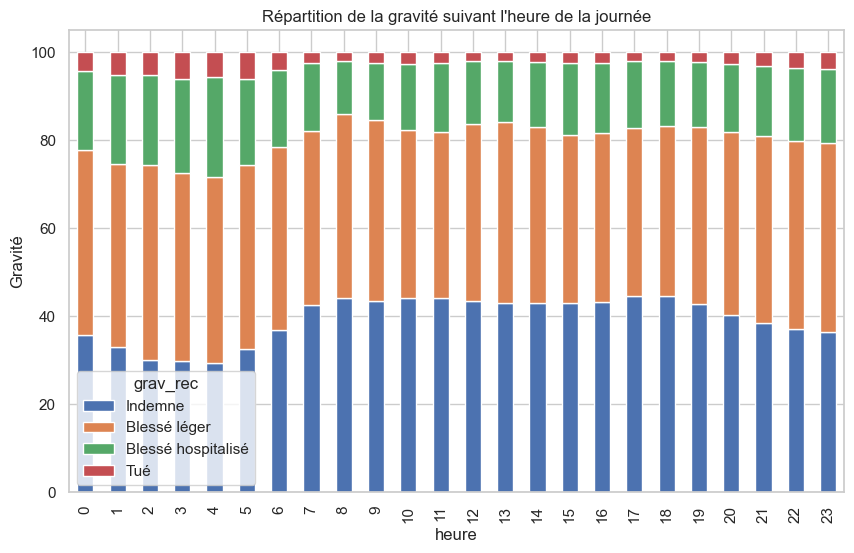

In [60]:
df_heure.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Répartition de la gravité suivant l'heure de la journée");
plt.ylabel('Gravité')
plt.show()

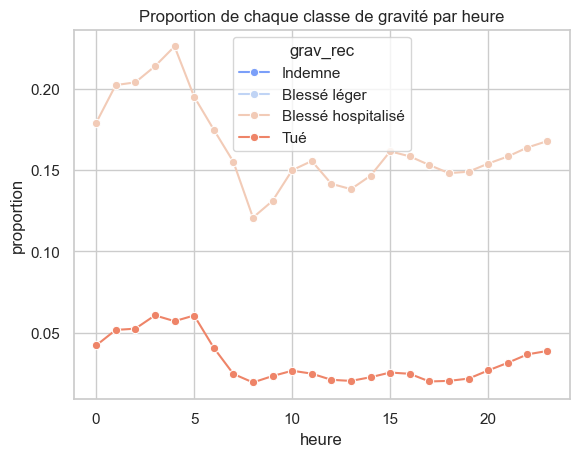

In [61]:
# série temporelle
df_heure2 = pd.DataFrame(data_cleaned.groupby('heure')['grav_rec'].value_counts(normalize=True)).reset_index()
 
# Plot de la série mensuelle 2019-2022, échelle réelle
sns.lineplot(data=df_heure2.loc[df_an_mois["grav_rec"].isin(["Tué", "Blessé hospitalisé"])], x='heure', y='proportion', hue="grav_rec", palette="coolwarm", marker='o')
plt.title("Proportion de chaque classe de gravité par heure")
plt.show()

On voit une variation de la gravité des accident en fonction des heures de la journée. On conserve donc cette variable.

#### 5.Variable lum

Définition : conditions d’éclairage dans lesquelles l'accident s'est produit :  
1 – Plein jour  
2 – Crépuscule ou aube  
3 – Nuit sans éclairage public  
4 – Nuit avec éclairage public non allumé  
5 – Nuit avec éclairage public allumé

In [62]:
data_cleaned.lum.value_counts()

lum
1.0    333101
5.0     76103
3.0     48880
2.0     31625
4.0      4299
Name: count, dtype: int64

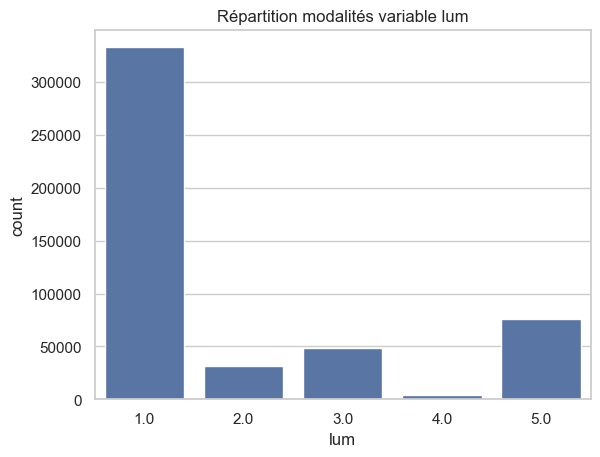

In [63]:
sns.countplot(data=data_cleaned,x="lum")
plt.title('Répartition modalités variable lum')
plt.show()

In [64]:
# suppression des NaN
data_cleaned.drop(data_cleaned.loc[data_cleaned['lum'].isna()].index, inplace=True)

Regrouper les catégories 3 et 4 pour devenir :  
0 - Plein jour (1)  
1 - Crépuscule ou aube (2)  
2 - Nuit sans éclairage (3 et 4)  
3 - Nuit avec éclairage public (5)  

In [65]:
data_cleaned.lum = data_cleaned.lum.replace(1,0)
data_cleaned.lum = data_cleaned.lum.replace(2,1)
data_cleaned.lum = data_cleaned.lum.replace([3, 4],2)
data_cleaned.lum = data_cleaned.lum.replace(5,3)

In [66]:
df_lum = pd.crosstab(data_cleaned.lum,data_cleaned.grav_rec,normalize='index')*100
df_lum

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
lum,,,,
0.0,43.460003,39.488094,14.826396,2.225506
1.0,40.645957,39.076933,17.306719,2.970391
2.0,34.351131,37.184408,22.137563,6.326899
3.0,41.403938,44.504071,12.337398,1.754594


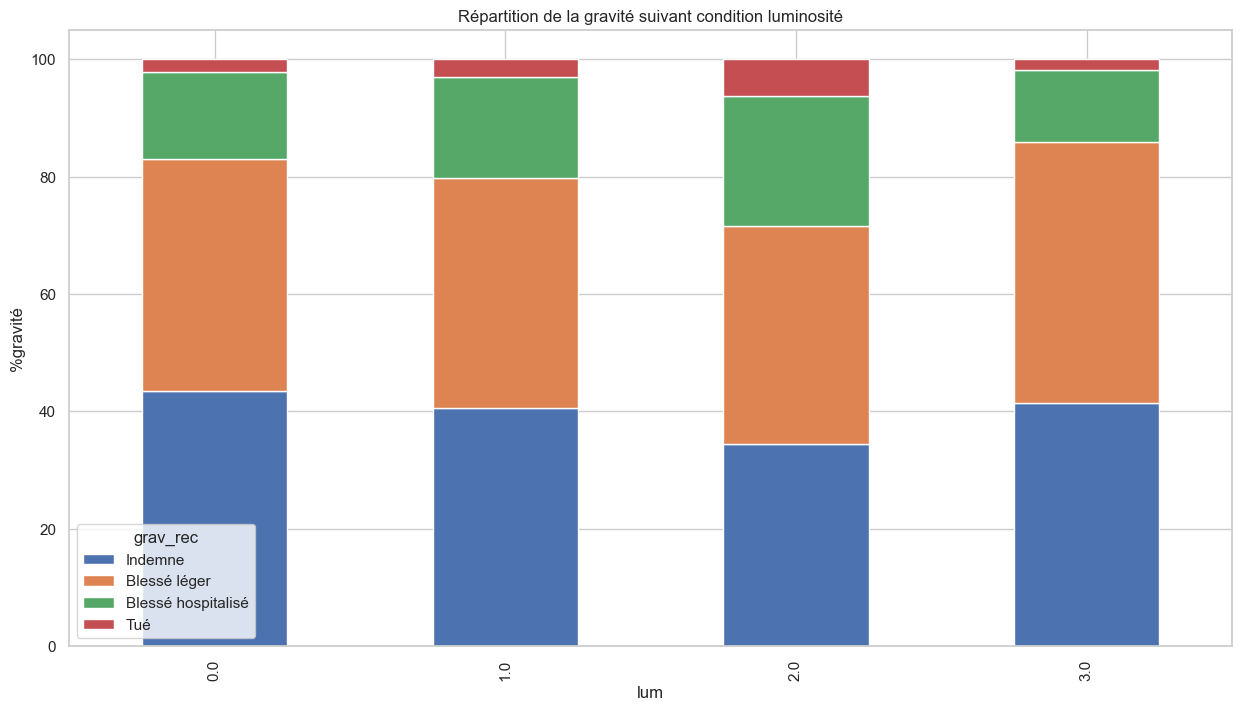

In [67]:
df_lum.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité suivant condition luminosité");
plt.ylabel('%gravité')
plt.show()

#### 6.Variable dep

Numéro du département (code INSEE)

In [68]:
np.sort(data_cleaned['dep'].unique())

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '1', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '2A', '2B', '3',
       '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4',
       '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5',
       '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7',
       '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8',
       '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9',
       '90', '91', '92', '93', '94', '95', '971', '972', '973', '974',
       '975', '976', '977', '978', '986', '987', '988'], dtype=object)

In [69]:
data_cleaned['dep'] = data_cleaned['dep'].replace(['1', '2', '3', '4', '5', '6', '7', '8', '9'],
                                                  ['01', '02', '03', '04', '05', '06', '07', '08', '09'])
np.sort(data_cleaned['dep'].unique())

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '2A', '2B', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54',
       '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65',
       '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76',
       '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87',
       '88', '89', '90', '91', '92', '93', '94', '95', '971', '972',
       '973', '974', '975', '976', '977', '978', '986', '987', '988'],
      dtype=object)

#### 7.Variable com

Numéro de commune (code INSEE)

In [70]:
# suppression de la variable ultérieurment car nécessaire pour les valeurs aberrantes de 'lat' et 'long'
#data_cleaned.drop('com', axis=1, inplace=True)

#### 8.Variable agg

Définition : Localisation    
1 – Hors agglomération   
2 – En agglomération  

In [71]:
# Recodage de la modalité de la variable en binaire
data_cleaned['agg'] = data_cleaned['agg'].replace([1,2],[0,1])

In [72]:
df_agg = pd.crosstab(data_cleaned['agg'], data_cleaned.grav, normalize='index')*100
df_agg

grav,1.0,2.0,3.0,4.0,nan
agg,,,,,
0,37.976524,4.683992,21.334801,35.976353,0.028330
1,44.383300,1.395134,11.749814,42.391276,0.080476


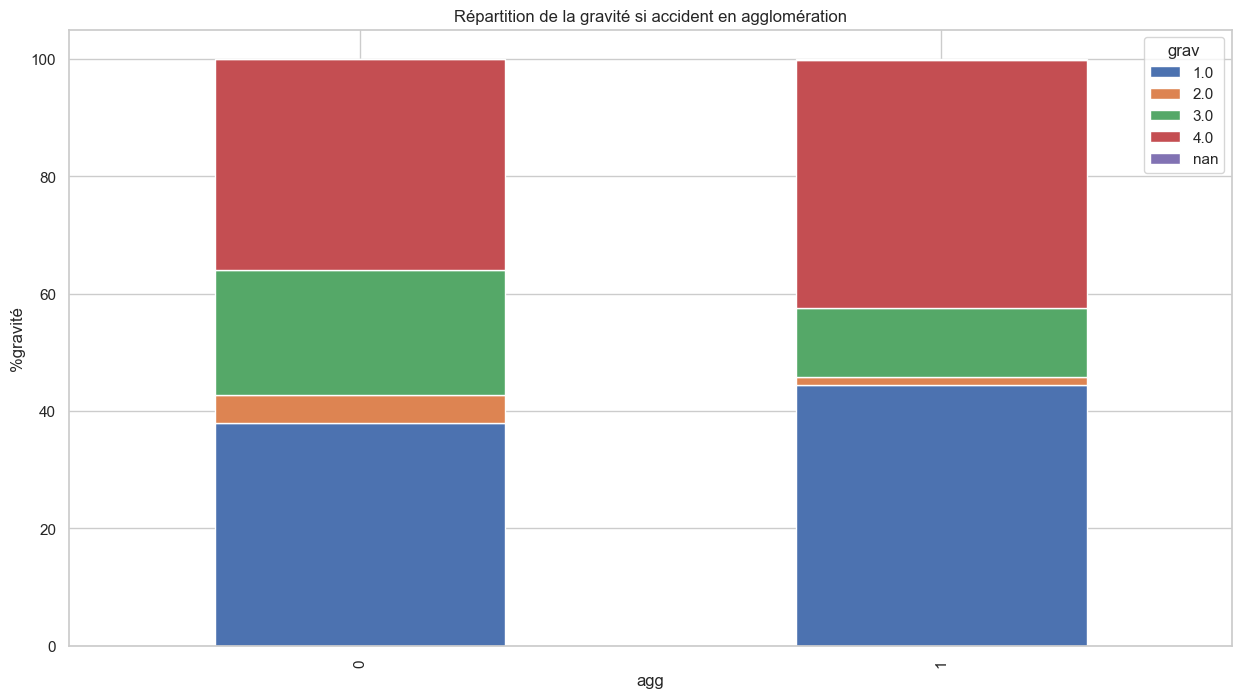

In [73]:
df_agg.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité si accident en agglomération");
plt.ylabel('%gravité')
plt.show()

#### 9.Variable int

Définition : intersection
1 - Hors intersection    
2 - Intersection en X    
3 - Intersection en T   
4 - Intersection en Y   
5 - Intersection à plus de 4 branches    
6 - Giratoire   
7 - Place   
8 - Passage à niveau   
9 - Autre intersection   

In [74]:
data_cleaned.int.value_counts(dropna=False)

int
1.0    316386
2.0     64103
3.0     53104
9.0     21468
6.0     18431
4.0     11264
7.0      5327
5.0      2995
8.0       909
NaN        21
Name: count, dtype: int64

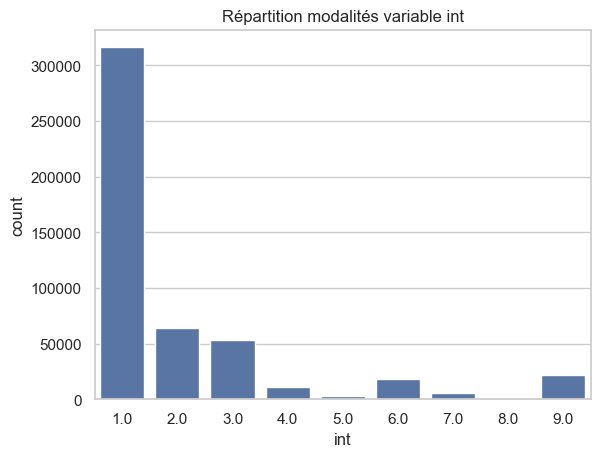

In [75]:
sns.countplot(data=data_cleaned,x="int")
plt.title('Répartition modalités variable int')
plt.show()

In [76]:
data_cleaned.drop(data_cleaned.loc[data_cleaned['int'].isna()].index, inplace=True)

In [77]:
# Recodage en binaire (0: hors intersection, 1 : intersection)
data_cleaned.int = data_cleaned.int.replace(1, 0)
data_cleaned.int = data_cleaned.int.replace([2,3,4,5,6,7,8,9], 1)

In [78]:
df_int = pd.crosstab(data_cleaned.int, data_cleaned.grav, normalize='index')*100
df_int

grav,1.0,2.0,3.0,4.0,nan
int,,,,,
0.0,40.247988,3.320943,16.927424,39.449596,0.054048
1.0,44.999747,1.429046,12.622114,40.876459,0.072635


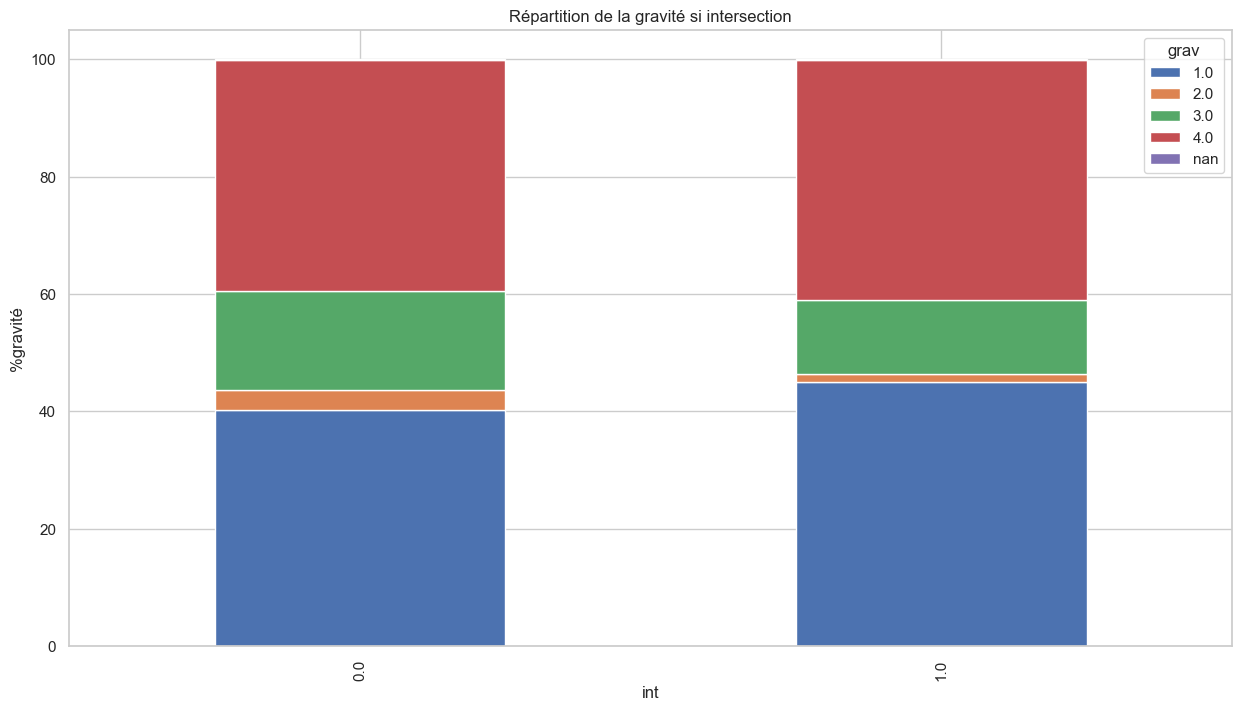

In [79]:
df_int.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité si intersection");
plt.ylabel('%gravité')
plt.show()

#### 10.Variable atm

Définition : Conditions atmosphériques   
1 – Normale  
2 – Pluie légère  
3 – Pluie forte  
4 – Neige - grêle  
5 – Brouillard - fumée  
6 – Vent fort - tempête  
7 – Temps éblouissant  
8 – Temps couvert  
9 – Autre

In [80]:
# distribution des modalités
data_cleaned.dropna(subset = 'atm', inplace=True)
data_cleaned.atm.value_counts(dropna=False)

atm
1.0    395093
2.0     51973
8.0     18305
3.0     10590
7.0      9139
5.0      3427
9.0      2253
4.0      1901
6.0      1280
Name: count, dtype: int64

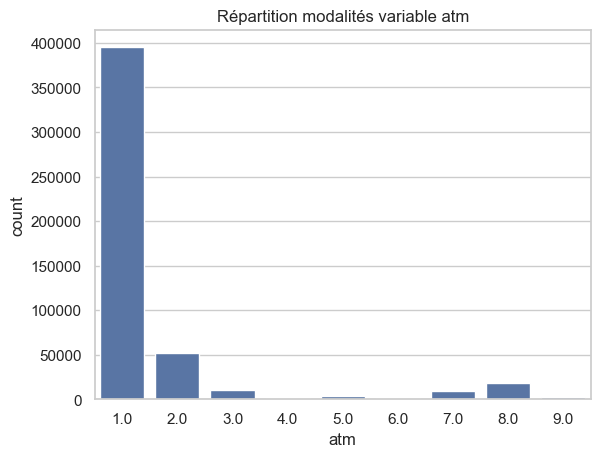

In [81]:
sns.countplot(data=data_cleaned,x="atm")
plt.title('Répartition modalités variable atm')
plt.show()

In [82]:
# recodage de la variable en binaire (0:normale, 1:dégradée)
data_cleaned.atm = data_cleaned.atm.replace(1, 0)
data_cleaned.atm = data_cleaned.atm.replace([2,3,4,5,6,7,8,9], 1)

In [83]:
df_atm = pd.crosstab(data_cleaned.atm, data_cleaned.grav, normalize='index')*100
df_atm

grav,1.0,2.0,3.0,4.0,nan
atm,,,,,
0.0,42.190826,2.571040,15.439909,39.734189,0.064036
1.0,41.021362,2.917021,15.141401,40.872679,0.047538


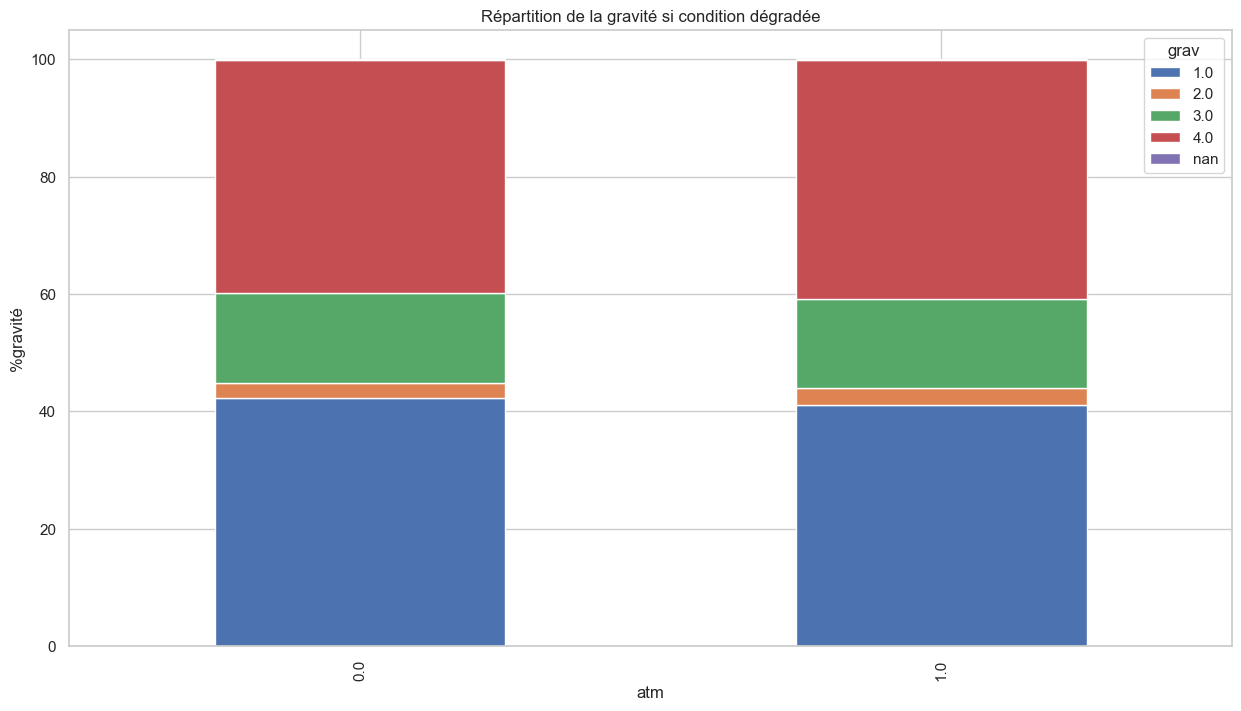

In [84]:
df_atm.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité si condition dégradée")
plt.ylabel('%gravité')
plt.show()

#### 11.Variable col

Définition : Type de collision  
1 – Deux véhicules - frontale  
2 – Deux véhicules – par l’arrière  
3 – Deux véhicules – par le coté  
4 – Trois véhicules et plus – en chaîne  
5 – Trois véhicules et plus - collisions multiples  
6 – Autre collision 
7 – Sans collision

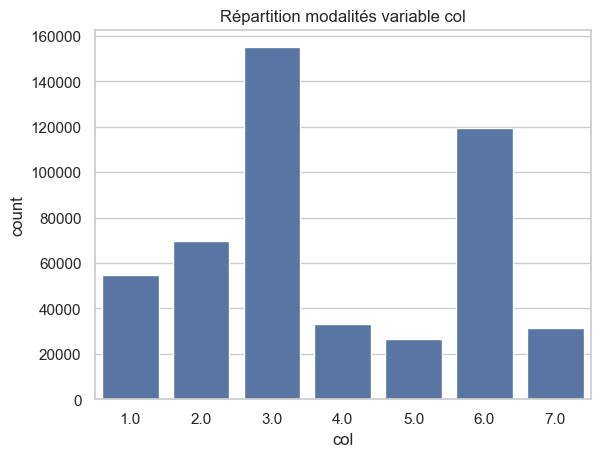

In [85]:
sns.countplot(data=data_cleaned,x="col")
plt.title('Répartition modalités variable col')
plt.show()

In [86]:
data_cleaned.drop(data_cleaned.loc[data_cleaned['col'].isna()].index, inplace=True)

In [87]:
df_col = pd.crosstab(data_cleaned.col, data_cleaned.grav,normalize='index')*100
df_col

grav,1.0,2.0,3.0,4.0,nan
col,,,,,
1.0,36.069434,4.429964,22.940167,36.522104,0.038331
2.0,47.049801,1.129620,8.330227,43.410075,0.080278
3.0,46.792572,1.089790,11.748310,40.311903,0.057425
4.0,57.978500,0.615579,4.098853,37.259023,0.048045
5.0,52.367584,2.174808,10.690623,34.710837,0.056148
6.0,35.279514,4.761585,20.765779,39.116796,0.076326
7.0,15.973309,5.255260,31.496440,47.239871,0.035120


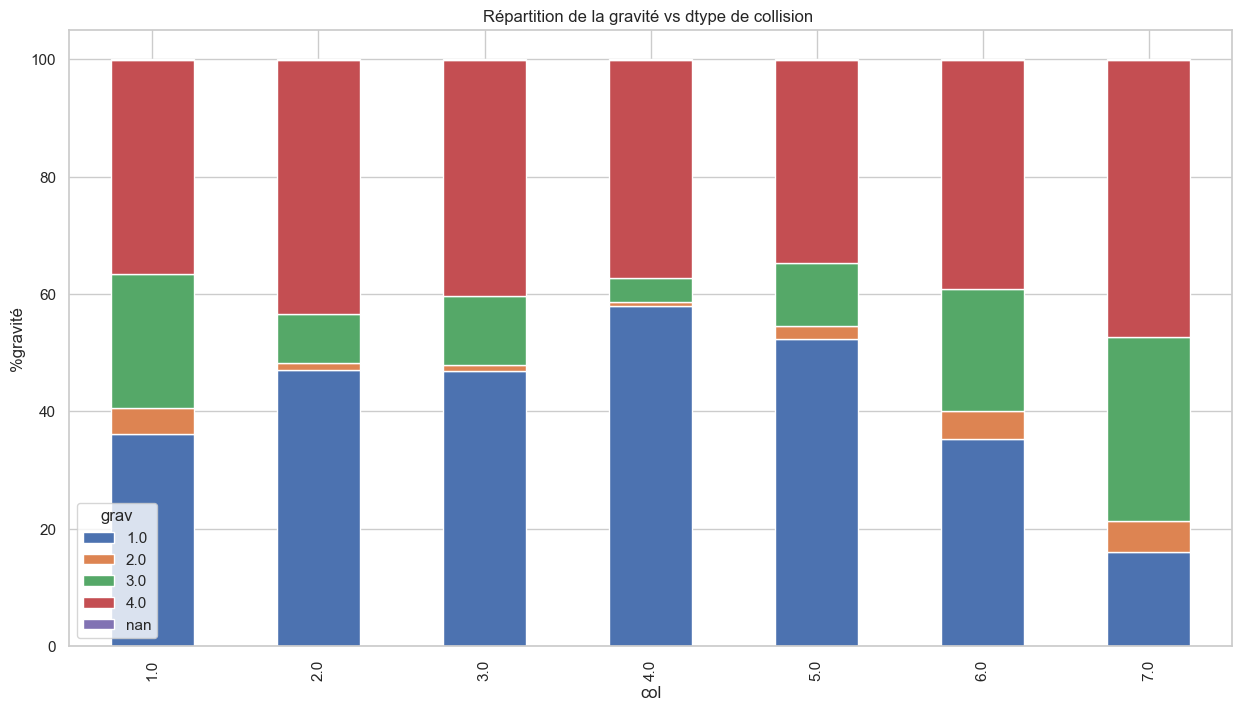

In [88]:
df_col.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité vs dtype de collision ");
plt.ylabel('%gravité')
plt.show()

#### 12.Variable adr

Définition : Adresse postale : variable renseignée pour les accidents survenus en agglomération.

In [89]:
# suppression de la variable
data_cleaned.drop('adr',axis=1,inplace=True)

#### 13.Variable lat

Coordonnées géographique de la latitude

In [90]:
# Remplacement de la virgule par un point
data_cleaned['lat'] = data_cleaned['lat'].apply(lambda x : x.split(',')[0] + '.' + x.split(',')[1])
data_cleaned['lat'] = data_cleaned['lat'].astype('float')
data_cleaned['lat'].head()

0    48.896210
1    48.896210
2    48.896210
3    48.930700
4    48.935872
Name: lat, dtype: float64

#### 14.Variable long

Coordonnées géographique de la longitude

In [91]:
# Remplacement de la virgule par un point
data_cleaned['long'] = data_cleaned['long'].apply(lambda x : x.split(',')[0] + '.' + x.split(',')[1])
data_cleaned['long'] = data_cleaned['long'].astype('float')
data_cleaned['long'].head()

0    2.470120
1    2.470120
2    2.470120
3    2.368800
4    2.319174
Name: long, dtype: float64

#### 15.Variable catr

Définition : Catégorie de route :  
1 – Autoroute  
2 – Route nationale  
3 – Route Départementale  
4 – Voie Communales  
5 – Hors réseau public  
6 – Parc de stationnement ouvert à la circulation publique  
7 – Routes de métropole urbaine  
9 – autre

In [92]:
data_cleaned.catr.isna().sum()

0

In [93]:
data_cleaned.catr.value_counts()

catr
4    196762
3    179078
1     56347
2     34974
7     16026
6      3297
9      3094
5       513
Name: count, dtype: int64

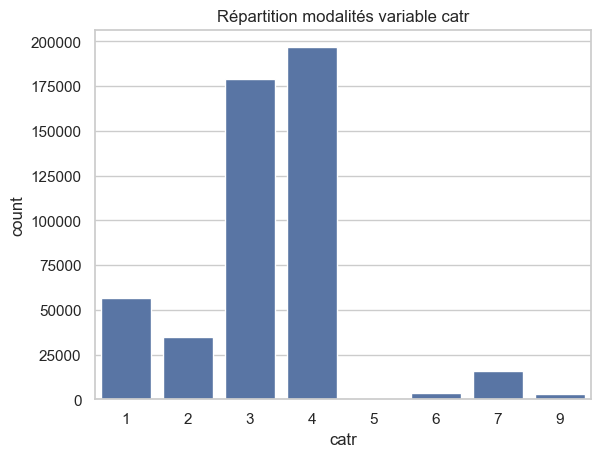

In [94]:
sns.countplot(data=data_cleaned,x="catr")
plt.title('Répartition modalités variable catr')
plt.show();

In [95]:
df_catr = pd.crosstab(data_cleaned.catr, data_cleaned.grav_rec,normalize='index')*100
df_catr

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
catr,,,,
1,46.588912,43.276349,8.306261,1.828478
2,40.752288,38.898741,16.298627,4.050343
3,38.302687,34.886606,22.608492,4.202216
4,44.158783,43.885668,10.682026,1.273523
5,36.452242,35.087719,24.171540,4.288499
6,46.826602,33.525660,17.400547,2.247191
7,41.606797,41.962891,14.181296,2.249016
9,39.081203,38.078292,20.058234,2.782271


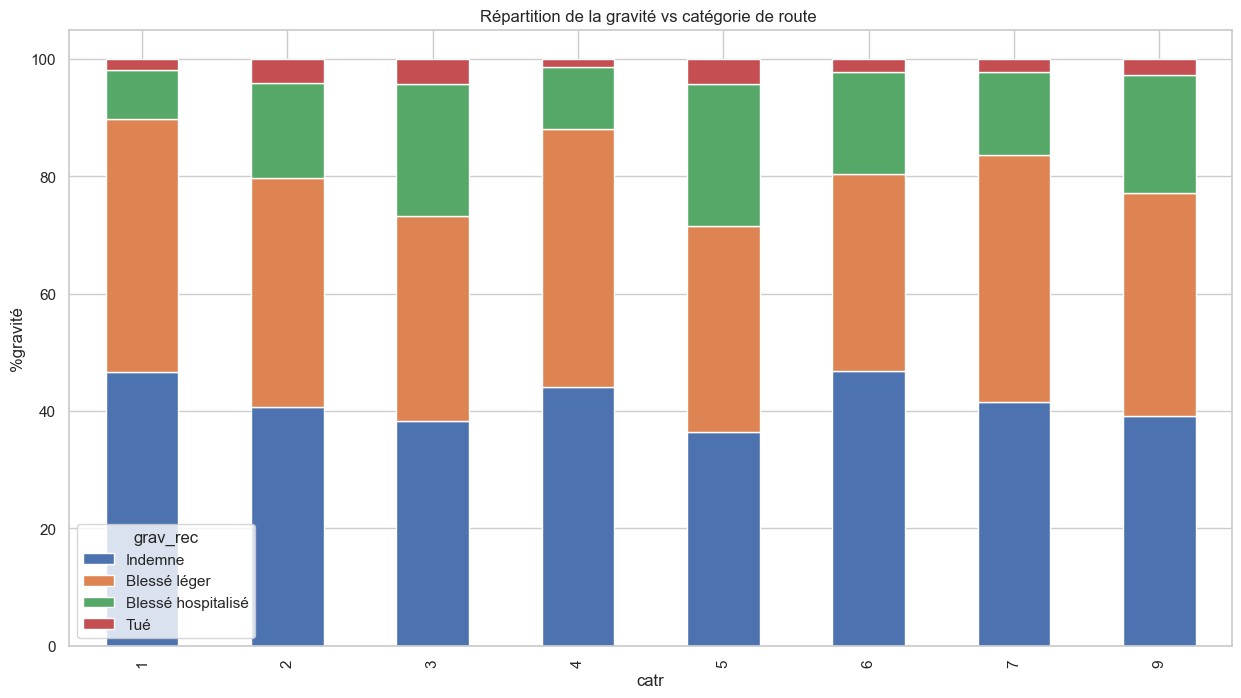

In [96]:
df_catr.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité vs catégorie de route ");
plt.ylabel('%gravité')
plt.show()

#### 16.Variable voie

Définition : Numéro de la route.

In [97]:
# suppression de la variable
data_cleaned.drop('voie',axis=1,inplace=True)

#### 17.Variable v1

Définition : Indice numérique du numéro de route (exemple : 2 bis, 3 ter etc.).

In [98]:
# suppression de la variable
data_cleaned.drop('v1',axis=1,inplace=True)

#### 18.Variable v2

Définition : Lettre indice alphanumérique de la route.

In [99]:
# suppression de la variable
data_cleaned.drop('v2',axis=1,inplace=True)

#### 19.Variable circ

Définition : Régime de circulation :    
1 – A sens unique  
2 – Bidirectionnelle  
3 – A chaussées séparées  
4 – Avec voies d’affectation variable

In [100]:
data_cleaned.circ.value_counts(dropna=False)

circ
2.0    297877
1.0     85673
3.0     77374
NaN     26016
4.0      3151
Name: count, dtype: int64

In [101]:
# suppression des NaN
data_cleaned.drop(data_cleaned.loc[data_cleaned['circ'].isna()].index, inplace=True)

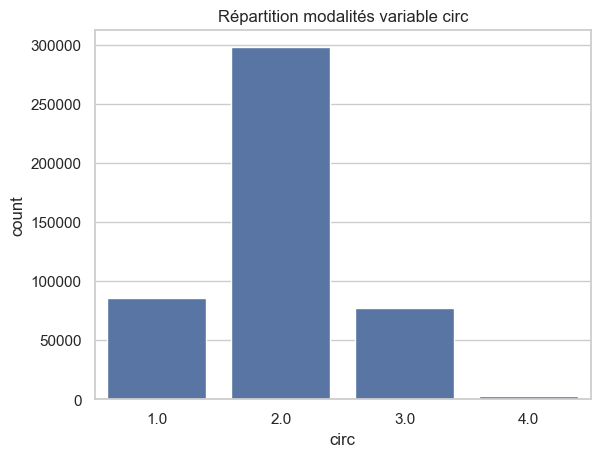

In [102]:
sns.countplot(data=data_cleaned,x="circ")
plt.title('Répartition modalités variable circ')
plt.show();

In [103]:
#Recodage de la variable en binaire (0:sens unique, 1:double sens)
data_cleaned.circ = data_cleaned.circ.replace([1,3,4],0)
data_cleaned.circ = data_cleaned.circ.replace(2,1)

In [104]:
df_circ = pd.crosstab(data_cleaned.circ, data_cleaned.grav_rec,normalize='index')*100
df_circ

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
circ,,,,
0.0,45.013183,44.252279,9.137481,1.597058
1.0,40.154796,37.405226,19.103543,3.336435


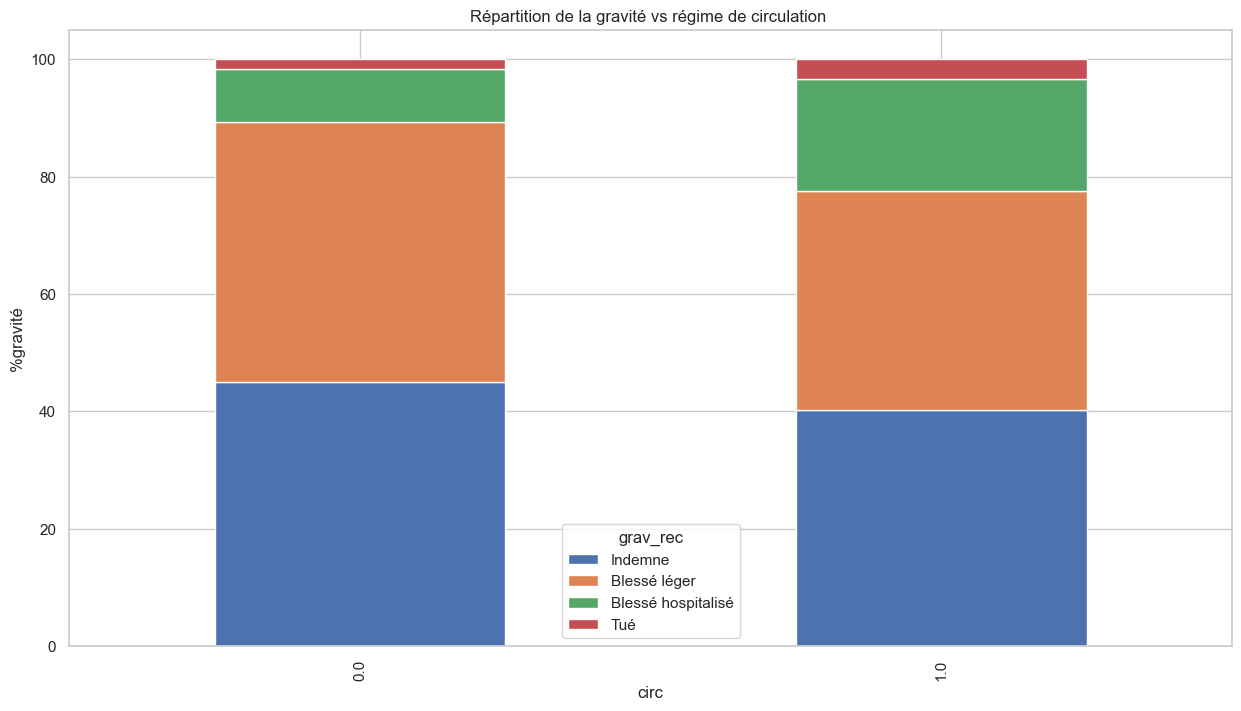

In [105]:
df_circ.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité vs régime de circulation ");
plt.ylabel('%gravité')
plt.show()

#### 20.Variable nbv

Définition : Nombre total de voies de circulation

In [106]:
# suppression de la variable
data_cleaned.drop('nbv',axis=1,inplace=True)

#### 21.Variable vosp

Définition : Signale l’existence d’une voie réservée, indépendamment du fait que l’accident ait lieu ou non sur 
cette voie.    
0 – Sans objet  
1 – Piste cyclable  
2 – Bande cyclable  
3 – Voie réservée

In [107]:
# suppression de la variable (sans objet dans 90% des cas et sans lien direct avec l'accident)
data_cleaned.drop('vosp',axis=1, inplace=True)

#### 22.Variable prof

Définition : Profil en long décrit la déclivité de la route à l'endroit de l'accident :    
1 – Plat   
2 – Pente  
3 – Sommet de côte  
4 – Bas de côte 

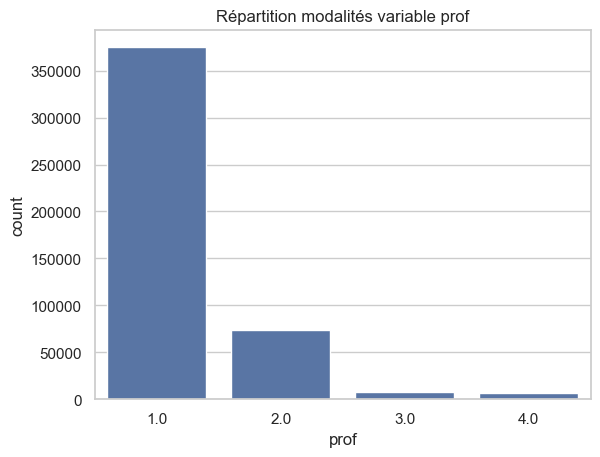

In [108]:
sns.countplot(data=data_cleaned,x="prof")
plt.title('Répartition modalités variable prof')
plt.show();

In [109]:
data_cleaned.prof.value_counts(dropna=False)

prof
1.0    374881
2.0     74051
3.0      8207
4.0      6871
NaN        65
Name: count, dtype: int64

In [110]:
# suppression des NaN (70)
data_cleaned.drop(data_cleaned.loc[data_cleaned['prof'].isna()].index, inplace=True)

In [111]:
df_prof = pd.crosstab(data_cleaned.prof, data_cleaned.grav_rec,normalize='index')*100
df_prof

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
prof,,,,
1.0,42.736879,40.266593,14.541189,2.455339
2.0,38.393774,38.359996,19.613036,3.633195
3.0,38.164310,37.176987,19.880546,4.778157
4.0,38.124363,37.046745,20.460172,4.368720


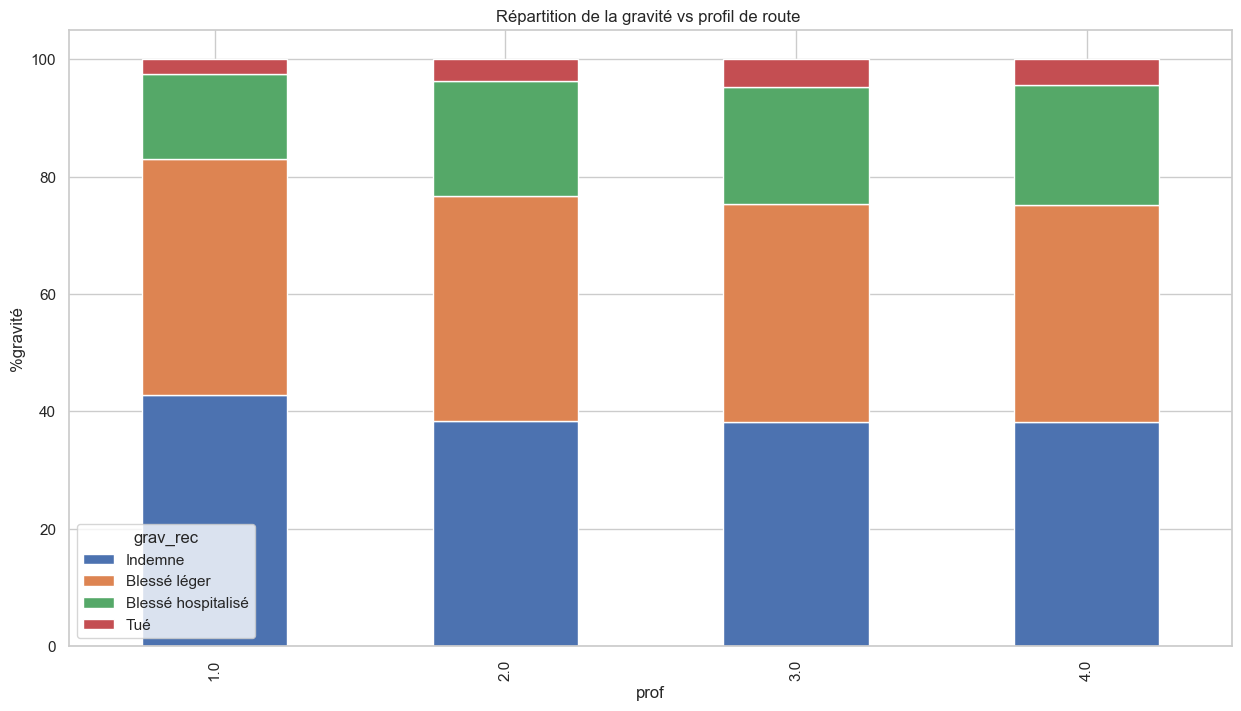

In [112]:
df_prof.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité vs profil de route ");
plt.ylabel('%gravité')
plt.show()

In [113]:
# recodage binaire (0:plane, 1:non-plane)
data_cleaned.prof = data_cleaned.prof.replace(1,0)
data_cleaned.prof = data_cleaned.prof.replace([2,3,4],1)

In [114]:
df_prof = pd.crosstab(data_cleaned.prof, data_cleaned.grav_rec,normalize='index')*100
df_prof

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
prof,,,,
0.0,42.736879,40.266593,14.541189,2.455339
1.0,38.351874,38.149815,19.702974,3.795337


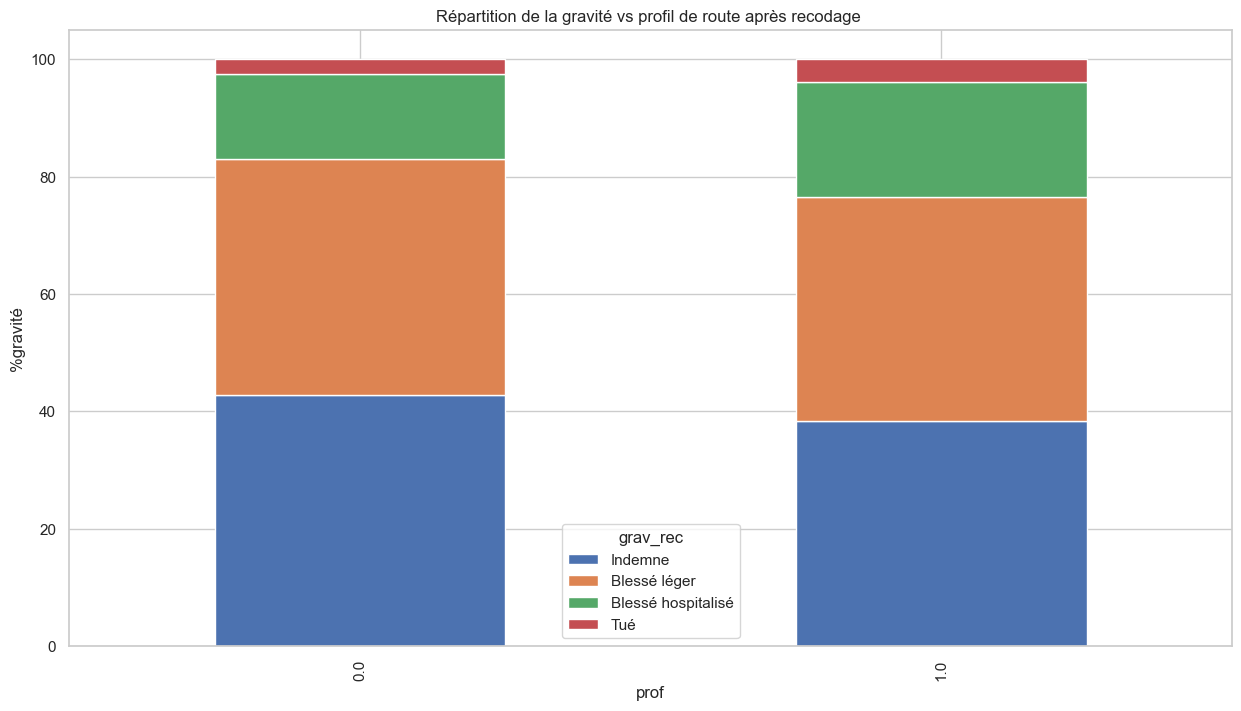

In [115]:
df_prof.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité vs profil de route après recodage ");
plt.ylabel('%gravité')
plt.show()

#### 23.Variable pr

Définition : Numéro du PR de rattachement (numéro de la borne amont). La valeur -1 signifie que le PR n’est pas 
renseigné. 

In [116]:
# suppression de la variable
data_cleaned.drop('pr',axis=1,inplace=True)

#### 24.Variable pr1

Définition : Distance en mètres au PR (par rapport à la borne amont). La valeur -1 signifie que le PR n’est pas 
renseigné. 

In [117]:
# suppression de la variable
data_cleaned.drop('pr1',axis=1,inplace=True)

#### 25.Variable plan

Définition : Tracé en plan :  
1 – Partie rectiligne  
2 – En courbe à gauche  
3 – En courbe à droite   
4 – En « S »

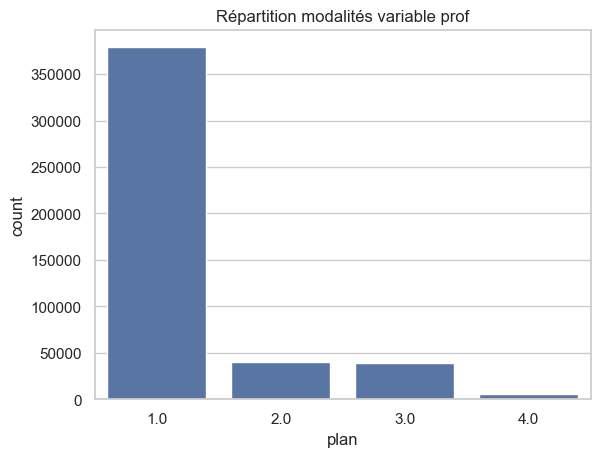

In [118]:
sns.countplot(data=data_cleaned,x="plan")
plt.title('Répartition modalités variable prof')
plt.show()

In [119]:
# suppression des NaN (7)
data_cleaned.drop(data_cleaned.loc[data_cleaned['plan'].isna()].index, inplace=True)

In [120]:
df_plan = pd.crosstab(data_cleaned.plan, data_cleaned.grav_rec,normalize='index')*100
df_plan

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
plan,,,,
1.0,43.658974,40.341037,13.716993,2.282996
2.0,33.854295,38.359958,23.423513,4.362234
3.0,34.599897,37.294786,23.247290,4.858028
4.0,31.634387,36.102616,27.353041,4.909956


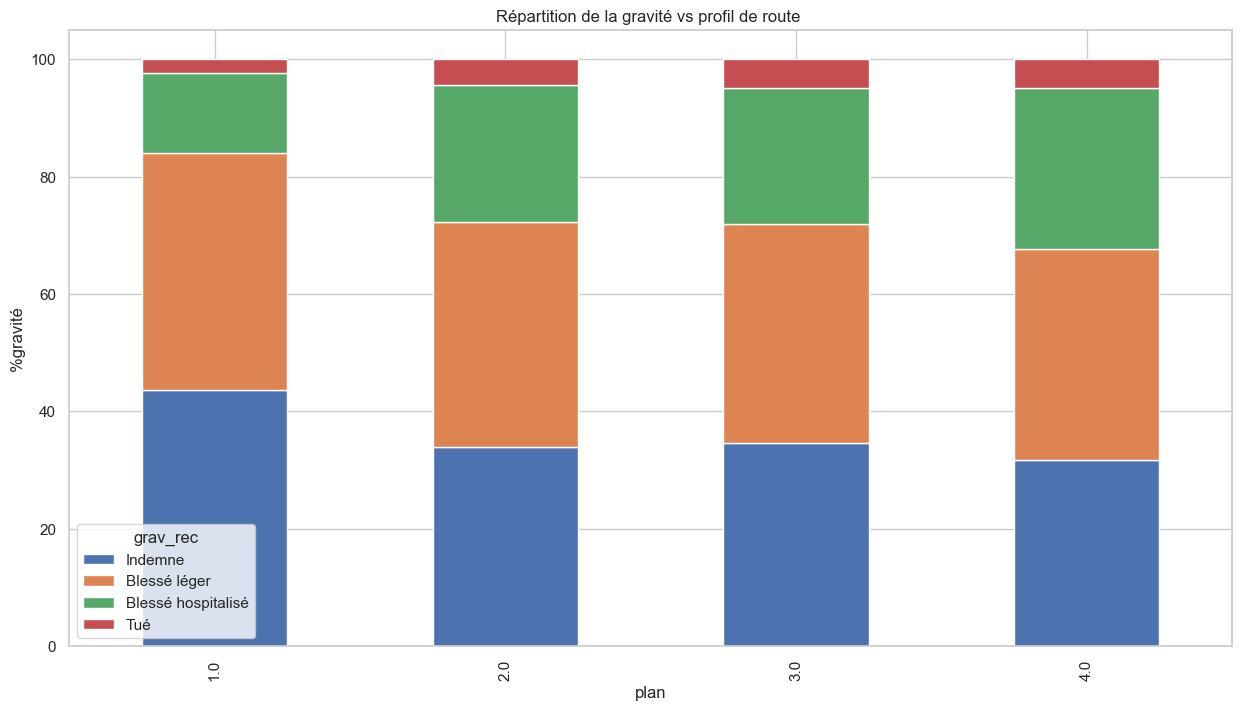

In [121]:
df_plan.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité vs profil de route ");
plt.ylabel('%gravité')
plt.show()

In [122]:
# recodage  binaire de la variable (0:rectiligne, 1:non rectiligne)
data_cleaned.plan = data_cleaned.plan.replace(1,0)
data_cleaned.plan = data_cleaned.plan.replace([2,3,4],1)

In [123]:
df_plan = pd.crosstab(data_cleaned.plan, data_cleaned.grav_rec,normalize='index')*100
df_plan

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
plan,,,,
0.0,43.658974,40.341037,13.716993,2.282996
1.0,34.040252,37.718659,23.615160,4.625929


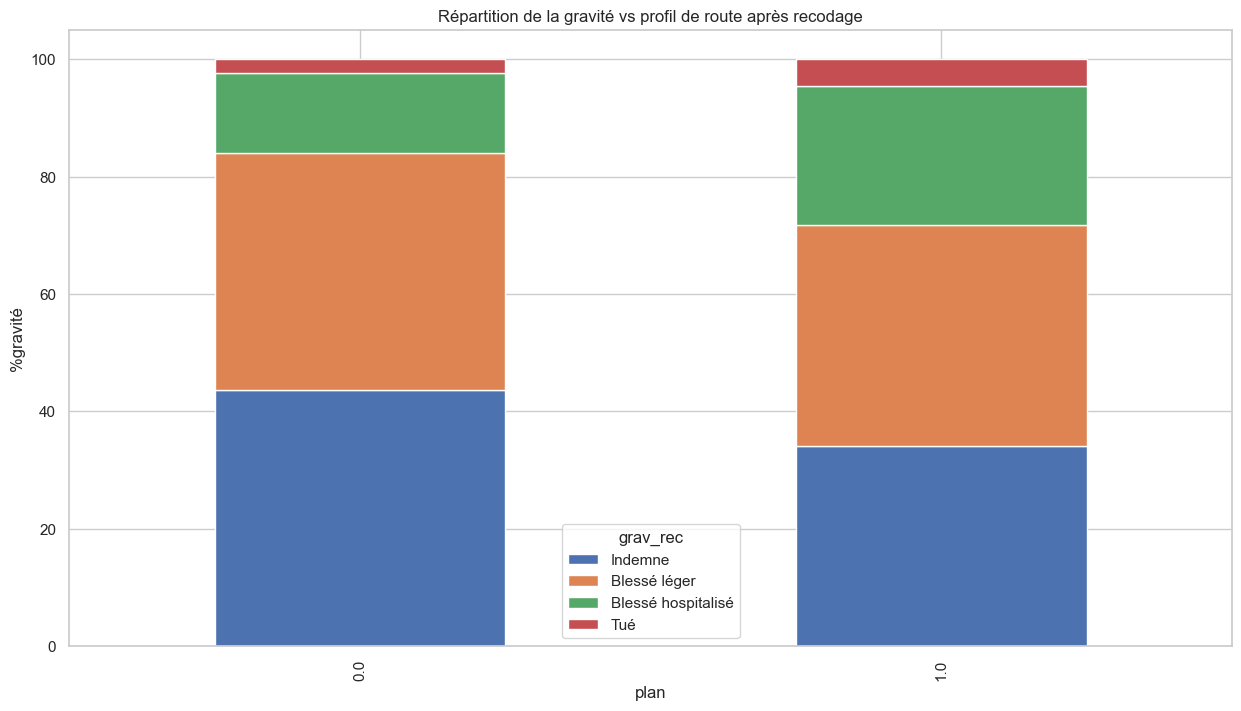

In [124]:
df_plan.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité vs profil de route après recodage");
plt.ylabel('%gravité')
plt.show()

#### 26.Variable lartpc

Définition : Largeur du terre-plein central (TPC) s'il existe (en m).

In [125]:
# suppression de la variable (plus de 99% de NaN)
data_cleaned.drop('lartpc',axis=1,inplace=True)

#### 27.Variable larrout

Définition : Largeur de la chaussée affectée à la circulation des véhicules ne sont pas compris les bandes d'arrêt 
d'urgence, les TPC et les places de stationnement (en m).

In [126]:
# suppression de la variable (plus de 95% de NaN)
data_cleaned.drop('larrout',axis=1,inplace=True)

#### 28.Variable surf

Définition : Etat de la surface :  
1 – Normale   
2 – Mouillée   
3 – Flaques   
4 – Inondée   
5 – Enneigée   
6 – Boue  
7 – Verglacée   
8 – Corps gras – huile   
9 – Autre

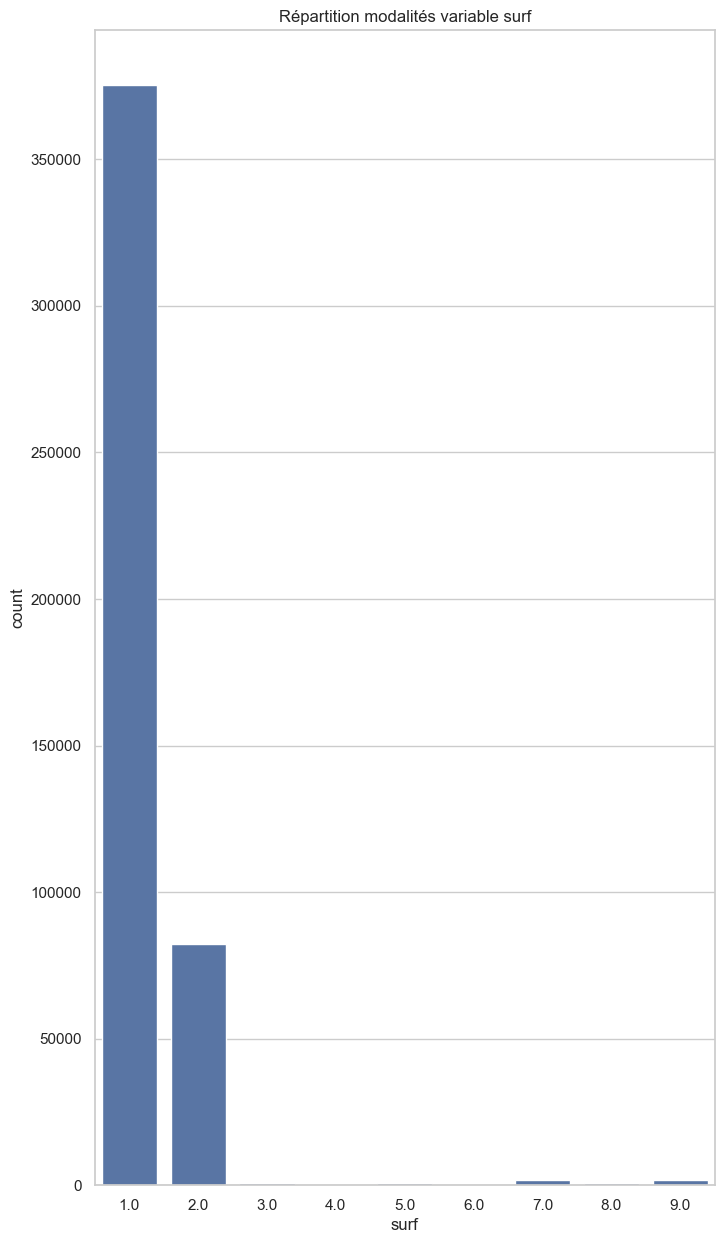

In [127]:
plt.figure(figsize = (8, 15))
sns.countplot(data=data_cleaned,x="surf")
plt.title('Répartition modalités variable surf')
plt.show()

In [128]:
# suppression des NaN (72 observations)
data_cleaned.drop(data_cleaned.loc[data_cleaned['surf'].isna()].index, inplace=True)

In [129]:
df_surf = pd.crosstab(data_cleaned.surf, data_cleaned.grav_rec,normalize='index')*100
df_surf

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
surf,,,,
1.0,42.350993,39.289257,15.707863,2.651887
2.0,40.447584,42.547149,14.141120,2.864147
3.0,38.656716,40.000000,18.507463,2.835821
4.0,39.234450,41.148325,15.789474,3.827751
5.0,44.930876,36.059908,16.129032,2.880184
6.0,21.978022,35.164835,34.065934,8.791209
7.0,33.389356,38.543417,23.081232,4.985994
8.0,25.623960,49.417637,23.128120,1.830283
9.0,29.918033,36.475410,28.278689,5.327869


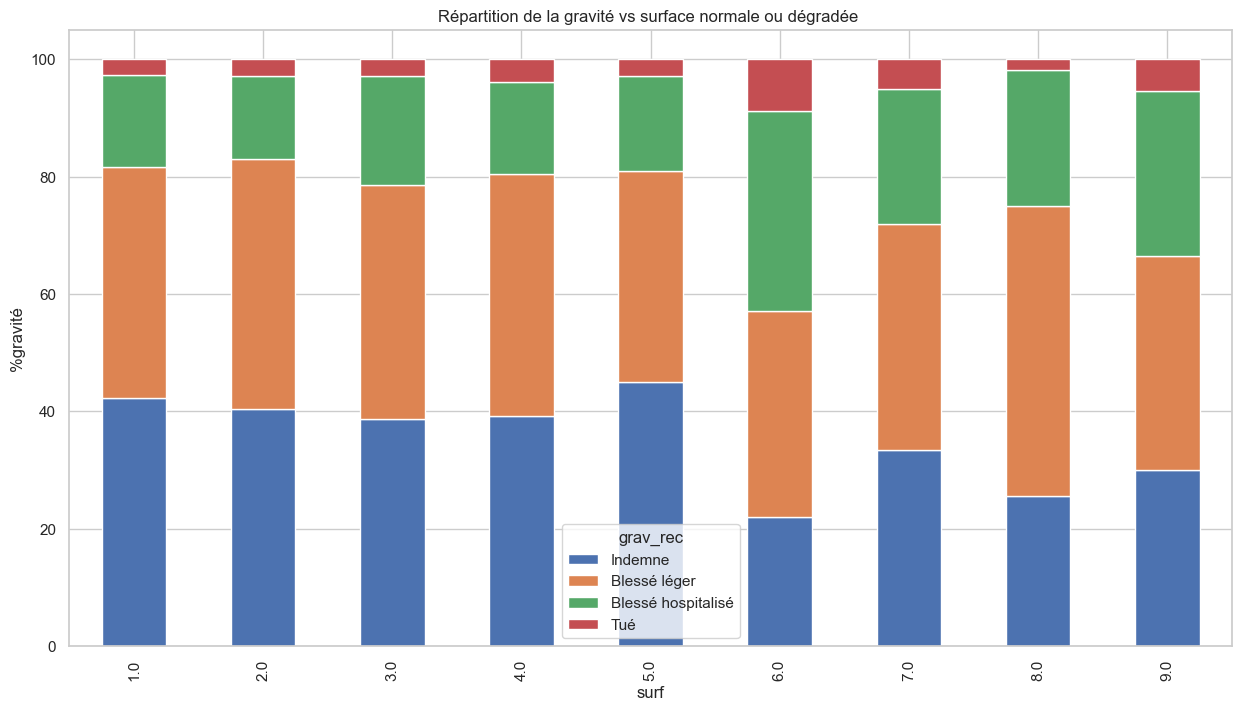

In [130]:
df_surf.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité vs surface normale ou dégradée ");
plt.ylabel('%gravité')
plt.show()

#### 29.Variable infra

Définition : Aménagement - Infrastructure :  
0 – Aucun   
1 – Souterrain - tunnel  
2 – Pont - autopont  
3 – Bretelle d’échangeur ou de raccordement  
4 – Voie ferrée  
5 – Carrefour aménagé  
6 – Zone piétonne  
7 – Zone de péage  
8 – Chantier  
9 – Autres

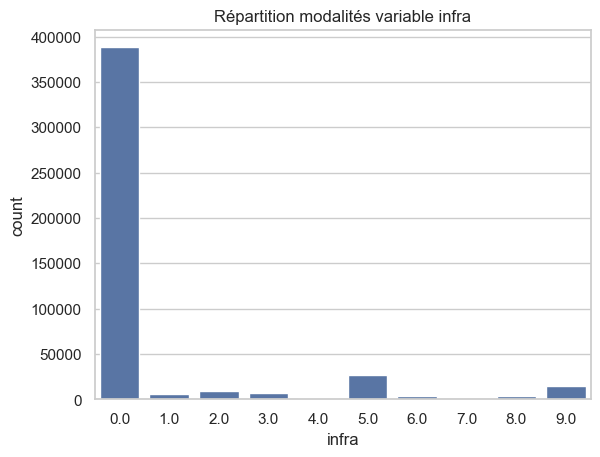

In [131]:
sns.countplot(data=data_cleaned,x="infra")
plt.title('Répartition modalités variable infra')
plt.show()

In [132]:
# suppression des NaN (4302 entrées, soit moins de 1% de la base)
data_cleaned.drop(data_cleaned.loc[data_cleaned['infra'].isna()].index, inplace=True)

In [133]:
df_infra = pd.crosstab(data_cleaned.infra,data_cleaned.grav_rec,normalize='index')*100
df_infra

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
infra,,,,
0.0,41.681101,39.671100,15.866326,2.781472
1.0,47.490861,45.995347,5.799269,0.714523
2.0,39.694211,41.596639,14.600840,4.108310
3.0,40.132971,45.225144,11.831369,2.810517
4.0,44.749485,36.307481,12.971860,5.971174
5.0,43.901525,38.543111,15.715517,1.839847
6.0,44.901557,39.612107,13.987658,1.498678
7.0,42.285714,33.428571,20.571429,3.714286
8.0,41.884380,41.272929,13.979989,2.862702


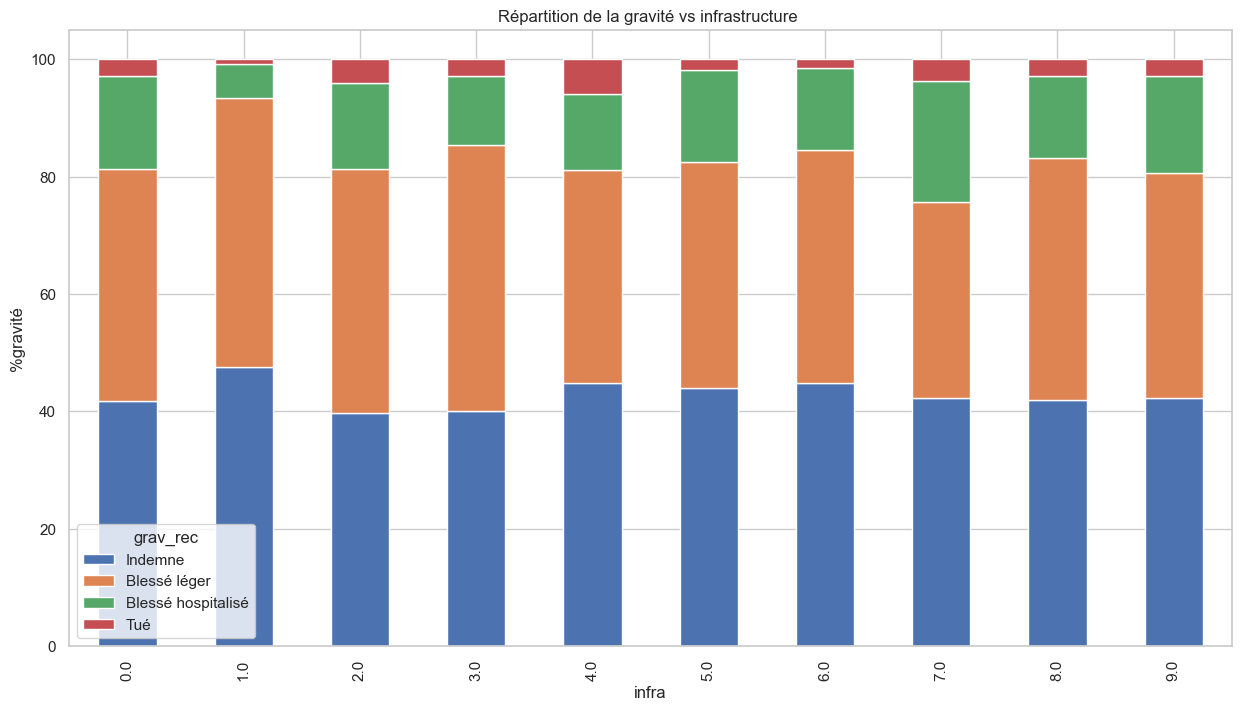

In [134]:
df_infra.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité vs infrastructure ");
plt.ylabel('%gravité')
plt.show()

#### 30.Variable situ

Définition : Situation de l’accident :  
0 – Aucun   
1 – Sur chaussée  
2 – Sur bande d’arrêt d’urgence  
3 – Sur accotement  
4 – Sur trottoir  
5 – Sur piste cyclable  
6 – Sur autre voie spéciale  
8 – Autres

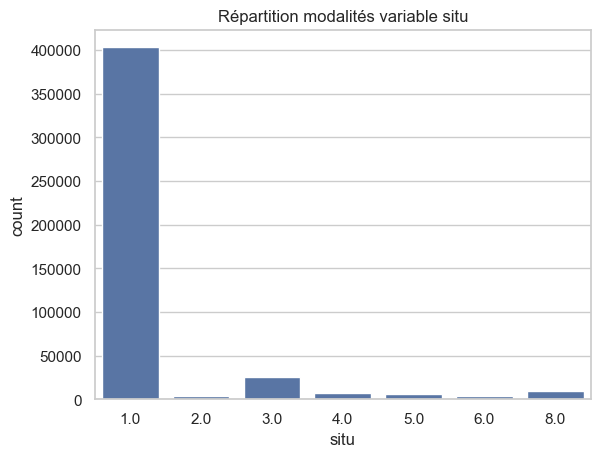

In [135]:
sns.countplot(data=data_cleaned,x="situ")
plt.title('Répartition modalités variable situ')
plt.show();

In [136]:
# suppression des NaN (190)
data_cleaned.drop(data_cleaned.loc[data_cleaned['situ'].isna()].index, inplace=True)

In [137]:
df_situ = pd.crosstab(data_cleaned.situ,data_cleaned.grav_rec,normalize='index')*100
df_situ

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
situ,,,,
1.0,43.870226,40.238182,13.810110,2.081482
2.0,36.768323,42.006886,17.338908,3.885883
3.0,19.117589,31.281185,39.201666,10.399560
4.0,27.212261,43.652400,23.698670,5.436669
5.0,43.488411,45.822911,9.621477,1.067200
6.0,43.996134,42.643151,11.258758,2.101957
8.0,29.754006,33.479637,28.345412,8.420945


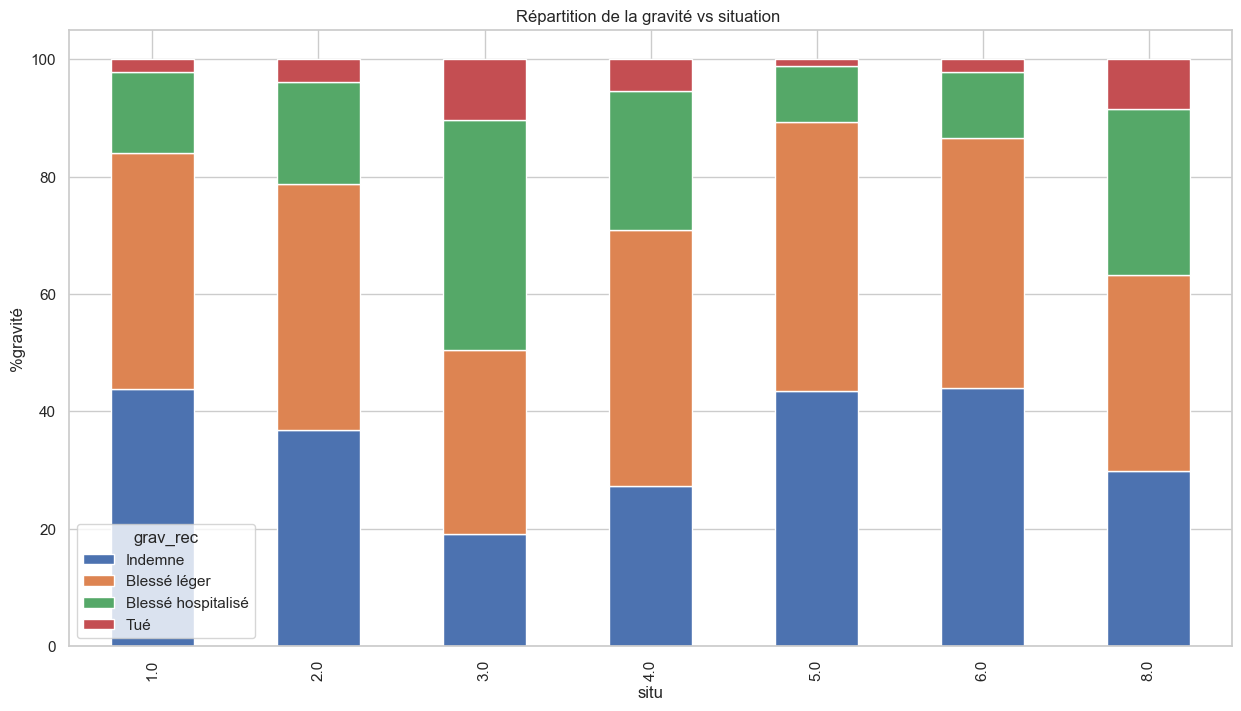

In [138]:
df_situ.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité vs situation ");
plt.ylabel('%gravité')
plt.show()

#### 31.Variable vma (variable continue)

Définition : Vitesse maximale autorisée sur le lieu et au moment de l’accident.

<Axes: xlabel='vma'>

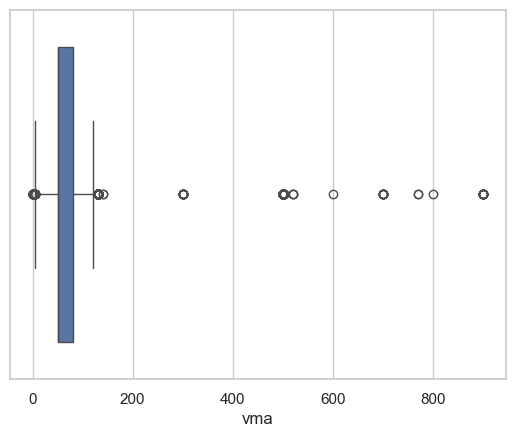

In [139]:
# affichage d'un boxplot pour visualisation distribution 
sns.boxplot(data=data_cleaned,x='vma')

In [140]:
data_cleaned.drop(data_cleaned.loc[data_cleaned['vma'].isna()].index, inplace=True)

In [141]:
np.sort(data_cleaned.vma.unique())

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        12.,  15.,  20.,  25.,  30.,  35.,  40.,  42.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  90., 100., 110., 120., 130., 140.,
       300., 500., 501., 502., 520., 600., 700., 770., 800., 900., 901.])

Beaucoup de valeurs aberrantes et varaible corrélée avec 'catr'. De plus, cela indique la vitesse maximale sur la route, mais pas la vitesse du véhicule.   
On décide de supprimer la variable.

In [142]:
data_cleaned = data_cleaned.drop('vma', axis = 1)

#### 32.Variable id_vehicule

Définition : Identifiant unique du véhicule repris pour chacun des usagers occupant ce véhicule (y compris les 
piétons qui sont rattachés aux véhicules qui les ont heurtés) – Code numérique.

Suppression de la variable car elle ne servait qu'à faire la jointure entre les dataframes

In [143]:
data_cleaned = data_cleaned.drop('id_vehicule', axis = 1)

#### 33.Variable num_veh

Définitiion : Identifiant du véhicule repris pour chacun des usagers occupant ce véhicule (y compris les piétons qui 
sont rattachés aux véhicules qui les ont heurtés) – Code alphanumérique.

Suppression de la variable car elle ne servait qu'à faire la jointure entre les dataframes

In [144]:
data_cleaned = data_cleaned.drop('num_veh', axis = 1)

#### 34. Variable place

Définition : Permet de situer la place occupée dans le véhicule par l'usager au moment de l'accident.


Distribution de la variable

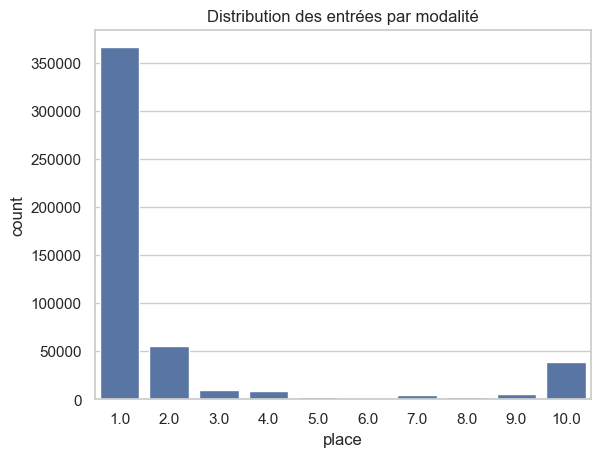

In [145]:
# Affichage des modalités des observations
sns.countplot(data=df,x="place")
plt.title("Distribution des entrées par modalité")
plt.show()

In [146]:
# Affichage de la répartition
df.place.value_counts(normalize=True, dropna=False)

place
1.0     0.741714
2.0     0.113235
10.0    0.078013
3.0     0.019103
4.0     0.017297
9.0     0.010319
7.0     0.009423
5.0     0.005295
8.0     0.004257
6.0     0.001293
NaN     0.000051
Name: proportion, dtype: float64

On constate que les observations sont concentrées autour de 3 modalités majoritairement.

==> Proposition de recodage de la variable en 4 modalités : (1:conducteur, 2:passager avant, 3:passager arrière, 4:piéton)

In [147]:
# suppression des entrées non renseignées représentant seulement 0.005% des observations
data_cleaned.dropna(subset='place', inplace=True)

In [148]:
# Recodage de la variable
data_cleaned['place_rec'] = data_cleaned['place']
data_cleaned['place_rec'] = data_cleaned.place_rec.replace(6,2)
data_cleaned['place_rec'] = data_cleaned.place_rec.replace([4,5,7,8,9],3)
data_cleaned['place_rec'] = data_cleaned.place_rec.replace(10,4)


 # Traitement particulier de la modalité place = 2 qui comprend les 2 roues pour les recoder en passager arrière place=3
data_cleaned[(data_cleaned['place_rec'] == 2)].catv.value_counts()

catv
7.0     38736
10.0     3434
33.0     2826
2.0      1689
30.0     1410
32.0      898
31.0      490
34.0      484
3.0       400
1.0       279
50.0      236
38.0      235
99.0      231
37.0      201
43.0      199
14.0      175
36.0      154
13.0      134
15.0       94
17.0       87
20.0       65
21.0       41
40.0       36
80.0       31
39.0       29
0.0        24
60.0       20
35.0       16
16.0        6
42.0        5
41.0        1
Name: count, dtype: int64

In [149]:
# Traitement de la modalité place = 2 car différentiation 2 roues et 4 roues pour recodage des 2 roues en modalité 3
liste_a_remplace= [33,2,30,32,31,34,1,50,43,36,80,60,35,41,42]

for i in liste_a_remplace :
    data_cleaned.loc[(data_cleaned['place'] == 2) & (data_cleaned['catv'] == i),'place_rec'] = 3


In [150]:
# Affichage de la nouvelle répartition
data_cleaned.place_rec.value_counts(normalize=True)

place_rec
1.0    0.741349
2.0    0.096909
3.0    0.086296
4.0    0.075447
Name: proportion, dtype: float64

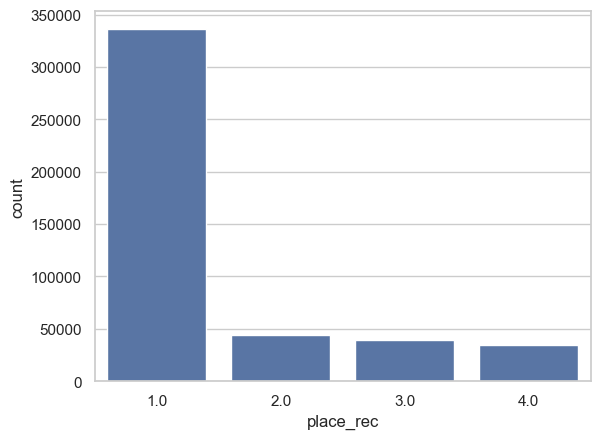

In [151]:
sns.countplot(data=data_cleaned,x="place_rec")
#plt.title("Répartition suivant place occupée")
plt.show()

In [152]:
df_place = pd.crosstab(data_cleaned.place_rec, data_cleaned.grav_rec, normalize='index')*100
df_place

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
place_rec,,,,
1.0,47.245353,35.726896,14.444441,2.583309
2.0,39.041376,45.002048,13.694297,2.262279
3.0,33.840256,48.544409,15.532268,2.083067
4.0,2.885290,64.204280,27.791745,5.118686


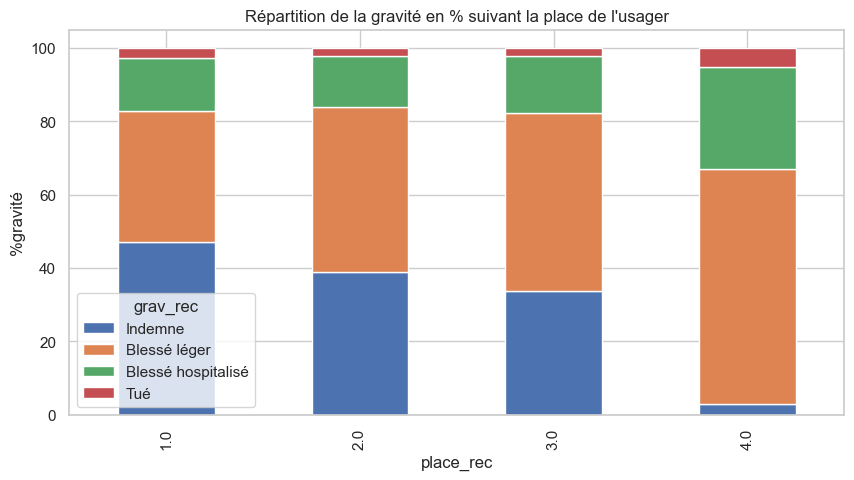

In [153]:
df_place.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title("Répartition de la gravité en % suivant la place de l'usager");
plt.ylabel('%gravité')
plt.show()

#### 35.Variable catu

Définition : Catégorie d'usager  
1 – Conducteur   
2 – Passager   
3 – Piéton 

In [154]:
# Affichage de la répartition
data_cleaned.catu.value_counts(normalize=True)

catu
1    0.742920
2    0.181636
3    0.075444
Name: proportion, dtype: float64

Analyse de la dépendance de cette variable avec place_rec

In [155]:
from scipy.stats import chi2_contingency

In [156]:
# Test de chi2 pour dépendance avec var place_rec

# Tableau de contingence
contigency= pd.crosstab(data_cleaned['place_rec'], data_cleaned['catu'])
contigency_pct= pd.crosstab(data_cleaned['place_rec'], data_cleaned['catu'], normalize=True)

In [157]:
contigency_pct

catu,1,2,3
place_rec,,,
1.0,0.740855,0.000494,0.000000
2.0,0.000615,0.096293,0.000000
3.0,0.001447,0.084849,0.000000
4.0,0.000002,0.000000,0.075444


<Axes: xlabel='catu', ylabel='place_rec'>

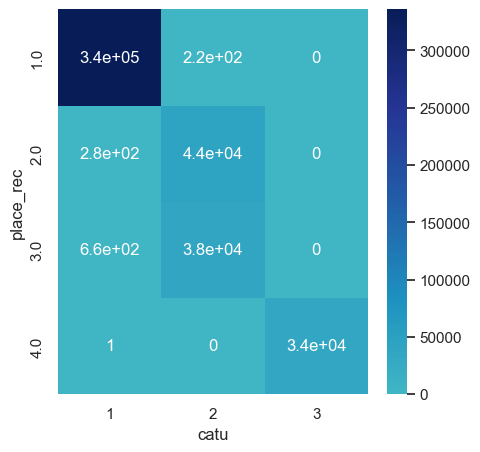

In [158]:
plt.figure(figsize=(5,5)) 
sns.heatmap(contigency, annot=True, center=0, cmap="YlGnBu")

In [159]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contigency)
# Print the p-value
print(p)
print("La statistique de Pearson du test khi-deux est : ", c, "\n"
      "La p-valeur du test est : ", p, "\n")

0.0
La statistique de Pearson du test khi-deux est :  898946.9596549487 
La p-valeur du test est :  0.0 



/!\ catu contient les mêmes infos que la variable place_rec sauf que cette dernière fait le distinguo entre passager avant et passager arrière
==> SUPPRESSION DE CETTE VARIABLE car trop correlée avec la variable place_rec mais moins détaillée.

In [160]:
# suppression de la variable
data_cleaned = data_cleaned.drop('catu', axis=1)

#### 36.Variable grav (VARIABLE CIBLE)

Définition : Gravité de blessure de l'usager, les usagers accidentés sont classés en trois catégories de 
victimes plus les indemnes soit 4 catégories :  
1 – Indemne   
2 – Tué   
3 – Blessé hospitalisé   
4 – Blessé léger

/INFO\ : depuis 2021, les usagers en fuite sont comptabilisés, cela  entraîne  des  manques d’informations sur ces derniers, notamment le sexe, l’âge, **voire la gravité des blessures** (indemne, blessé léger ou blessé hospitalisé) et la var grav est codée -1

In [161]:
# affichage du nombre d'entrée par modalité
data_cleaned.grav.value_counts(normalize=True)

grav
1.0    0.419208
4.0    0.398607
3.0    0.154647
2.0    0.026989
nan    0.000549
Name: proportion, dtype: float64

In [162]:
# suppression des NaN
# passage par grav_rec, sinon nan non reconnus dans grav
data_cleaned.dropna(subset ='grav_rec', inplace=True)

In [163]:
data_cleaned.grav.value_counts(normalize=True)

grav
1.0    0.419439
4.0    0.398826
3.0    0.154732
2.0    0.027004
Name: proportion, dtype: float64

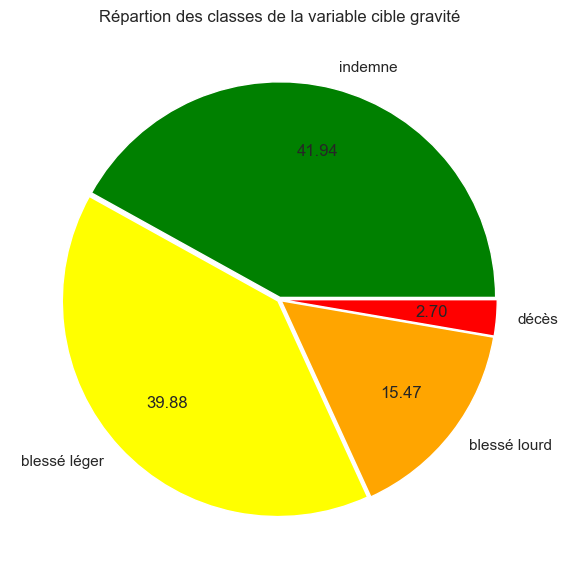

In [164]:
# affichage de la répartition des modalités de la var cible
plt.figure(figsize=(7,7))
plt.pie(data_cleaned.grav.value_counts().values,
        labels=['indemne','blessé léger','blessé lourd', 'décès'], 
        colors=['green','yellow','orange','red'], 
        explode=[0.01,0.01,0.01,0.01],
        autopct= '%.2f',
        pctdistance=0.7,
        labeldistance= 1.1,
        shadow=False)
plt.title('Répartion des classes de la variable cible gravité');


#### 37.Variable sexe

Définition : Sexe de l'usager 
- 1 – Masculin   
- 2 – Féminin 

In [165]:
data_cleaned.sexe.value_counts(normalize=True, dropna=False)

sexe
1.0    0.676135
2.0    0.312796
NaN    0.011069
Name: proportion, dtype: float64

In [166]:
#Suppression des NaN
data_cleaned.dropna(subset='sexe', inplace=True)

In [167]:
df_sexe = pd.crosstab(data_cleaned.sexe, data_cleaned.grav_rec,normalize='index')*100

In [168]:
df_sexe

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
sexe,,,,
1.0,43.294299,37.291936,16.285461,3.128305
2.0,36.970355,46.893740,14.264953,1.870952


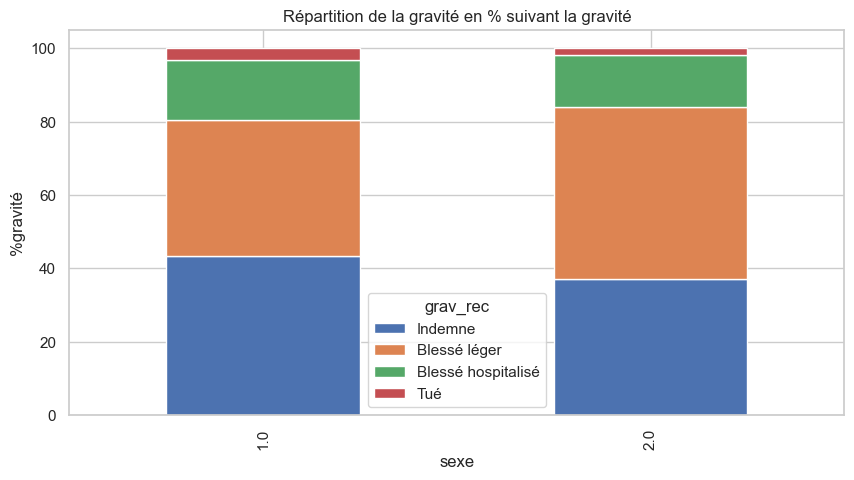

In [169]:
df_sexe.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Répartition de la gravité en % suivant la gravité');
plt.ylabel('%gravité')
plt.show()

La distribution de la gravité n'est pas homogène suivant le sexe. On constate qu'il y plus de femmes blessées légèrement, sinon pour le reste c'est chez les hommes qu'il y a le plus de décès et de blessés lourds.

In [170]:
# recodage en binaire pour plus de cohérence (0:homme, 1:femme)
data_cleaned.sexe = data_cleaned.sexe.replace(1,0)
data_cleaned.sexe = data_cleaned.sexe.replace(2,1)

#### 38.Variable an_nais

Définition : Année de naissance de l'usager.

In [171]:
print('suppression des ', data_cleaned.an_nais.isna().sum(), 'NaN')
data_cleaned.dropna(subset='an_nais', inplace=True)

suppression des  125 NaN


In [172]:
data_cleaned.an_nais.dtypes

dtype('float64')

In [173]:
data_cleaned.an_nais.value_counts().sort_index()

an_nais
1900.0     134
1901.0      40
1910.0       3
1911.0       1
1912.0       1
          ... 
2018.0    1302
2019.0    1075
2020.0     707
2021.0     496
2022.0     185
Name: count, Length: 110, dtype: int64

Création de la variable age_usager

In [174]:
data_cleaned['age_usager'] = data_cleaned.an - data_cleaned.an_nais

On regarde la répartition des âges.

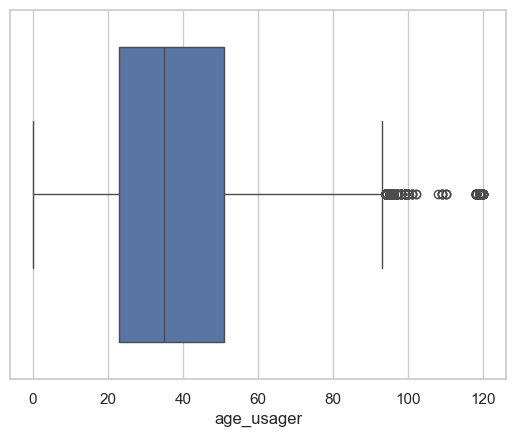

In [175]:
sns.boxplot(x = 'age_usager', data = data_cleaned)
plt.show()

Le doyen des français a 112 ans et la doyenne 118. On décide de supprimer les âges au delà de ces doyens selon le sexe.

In [176]:
# On supprime les lignes où l'âge est supérieur à 118 ans pour les femmes
data_cleaned.drop(data_cleaned.loc[((data_cleaned.age_usager >= 118)) & (data_cleaned.sexe == 1) ].index, inplace=True)

In [177]:
# On supprime les lignes où l'âge est supérieur à 112 ans pour les hommes
data_cleaned.drop(data_cleaned.loc[((data_cleaned.age_usager >= 112)) & (data_cleaned.sexe == 0) ].index, inplace=True)

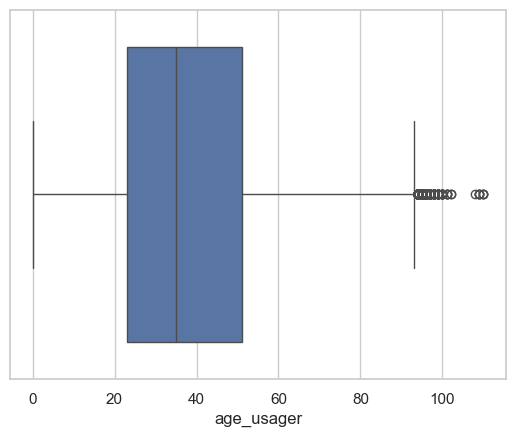

In [178]:
sns.boxplot(x = 'age_usager', data = data_cleaned)
plt.show()

Il convient pour introduire cette variable dans un modèle, d'approfondir l'étude et de réflechir à une stratégie. De prime abord, on peut regarder la fiabilité des données renseignées en croisant l'année de naissance avec la place (recodée)

In [179]:
df_age_usager = pd.crosstab(data_cleaned.age_usager,data_cleaned.place_rec)

In [180]:
df_age_usager

place_rec,1.0,2.0,3.0,4.0
age_usager,,,,
0.0,19,188,489,54
1.0,1,196,829,105
2.0,5,95,848,217
3.0,9,82,876,348
4.0,20,97,878,374
...,...,...,...,...
101.0,0,1,1,2
102.0,1,0,0,1
108.0,0,0,1,0


In [181]:
data_cleaned.age_usager.value_counts().sort_values()

age_usager
108.0        1
102.0        2
110.0        3
109.0        4
101.0        4
         ...  
23.0     12106
19.0     12794
22.0     12807
21.0     13452
20.0     13576
Name: count, Length: 106, dtype: int64

In [182]:
df_age = pd.crosstab(data_cleaned.age_usager,data_cleaned.grav_rec,normalize='index')*100

In [183]:
df_age

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
age_usager,,,,
0.0,38.400000,51.333333,7.600000,2.666667
1.0,45.269673,44.916004,7.780725,2.033599
2.0,43.261803,46.180258,8.583691,1.974249
3.0,36.501901,50.342205,11.711027,1.444867
4.0,33.747261,54.200146,11.029949,1.022644
...,...,...,...,...
101.0,50.000000,25.000000,0.000000,25.000000
102.0,50.000000,50.000000,0.000000,0.000000
108.0,0.000000,100.000000,0.000000,0.000000


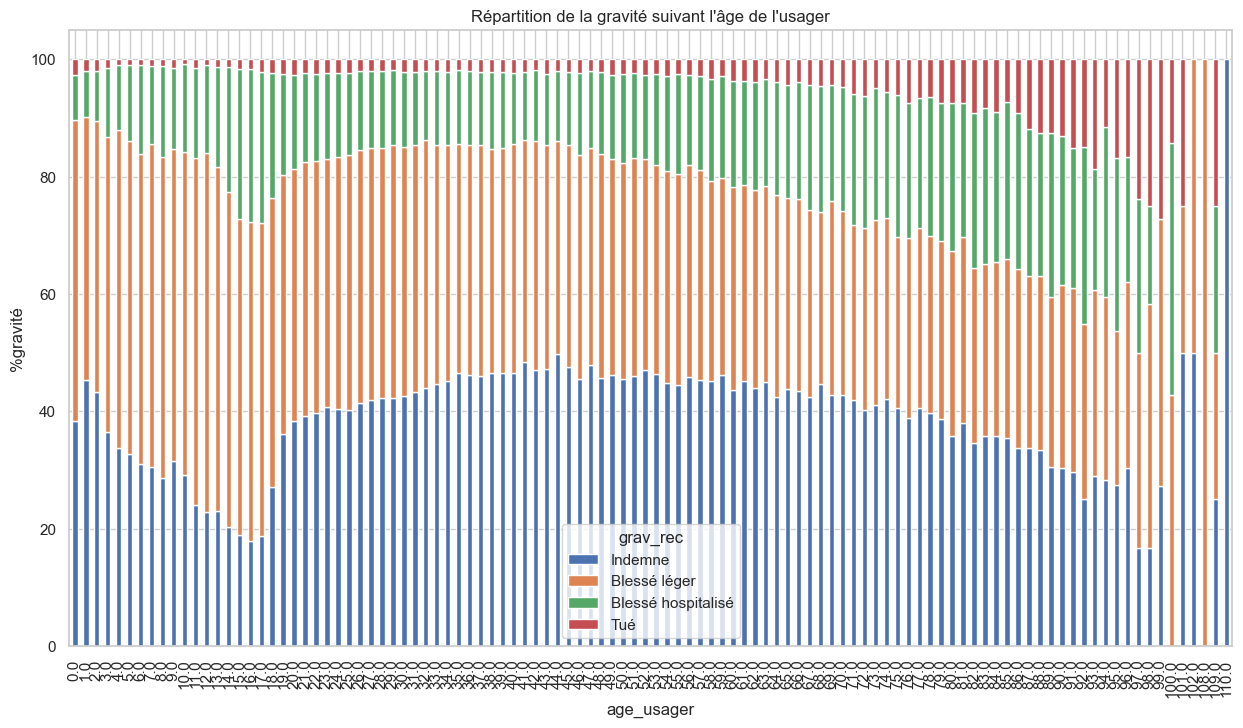

In [184]:
df_age.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité suivant l'âge de l'usager");
plt.ylabel('%gravité')
plt.show()

En analysant ce graphique on constate que 4 intervalles d'âge se distinguent, de 0 à 18 ans, >18 et <60ans, >60 ans et <90 et >90 ans et se conformant à l'évolution de la modalité 2 et 3 de la gravité. Choix de conserver cette variable en variable continue pour que le modèle puisse éventuellement mieux cerner les limites de classes adéquates.

#### 39.Variable trajet

Définition : Motif du déplacement au moment de l’accident  
0 – Non renseigné  
1 – Domicile – travail  
2 – Domicile – école  
3 – Courses – achats  
4 – Utilisation professionnelle  
5 – Promenade – loisirs  
9 – Autre

On constate déjà que les modalités -1 et 0 sont équivalentes.

In [185]:
data_cleaned.trajet.value_counts(normalize=True, dropna=False)

trajet
5.0    0.376371
0.0    0.257517
1.0    0.134918
4.0    0.094982
9.0    0.081689
3.0    0.031386
2.0    0.021483
NaN    0.001655
Name: proportion, dtype: float64

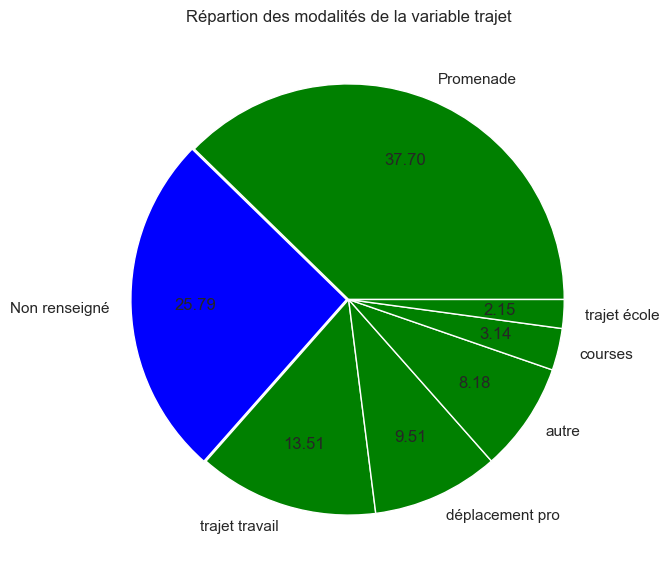

In [186]:
# affichage de la répartition des modalités de la variable
plt.figure(figsize=(7,7))
plt.pie(data_cleaned.trajet.value_counts().values,
        labels=['Promenade','Non renseigné','trajet travail', 'déplacement pro','autre','courses','trajet école'], 
        colors=['green','blue','green','green','green','green','green'], 
        explode=[0.0,0.01,0.0,0.0,0.0,0.0,0.0],
        autopct= '%.2f',
        pctdistance=0.7,
        labeldistance= 1.1,
        shadow=False)
plt.title('Répartion des modalités de la variable trajet');

Constat, les observations non renseignées concernent 1/4 des observations. Il n'est pas possible à travers les autres variables de retrouver des indices pour pouvoir renseigner les valeurs manquantes donc l'option la plus simple est de supprimer la variable du dataset

In [187]:
# suppression de la variable
data_cleaned = data_cleaned.drop('trajet',axis=1)

#### 40.41.42. Variables secu1/secu2/secu3

Définition : Les équipements de sécurité jusqu’en 2018 étaient en 2 variables : existence et utilisation. A partir de 2019, il s’agit de l’utilisation avec jusqu’à 3 équipements possibles pour un même usager (notamment pour les motocyclistes dont le port du casque et des gants est obligatoire).

Le renseignement du caractère indique la présence et l’utilisation de l’équipement de sécurité :   
0 – Aucun équipement  
1 – Ceinture   
2 – Casque   
3 – Dispositif enfants  
4 – Gilet réfléchissant  
5 – Airbag (2RM/3RM)  
6 – Gants (2RM/3RM)  
7 – Gants + Airbag (2RM/3RM)  
8 – Non déterminable  
9 – Autre

In [188]:
data_cleaned.secu1.value_counts(dropna=False)

secu1
1.0    270813
2.0     83462
8.0     52612
0.0     36300
3.0      3000
9.0       494
6.0       368
4.0       299
NaN       285
5.0       200
7.0        10
Name: count, dtype: int64

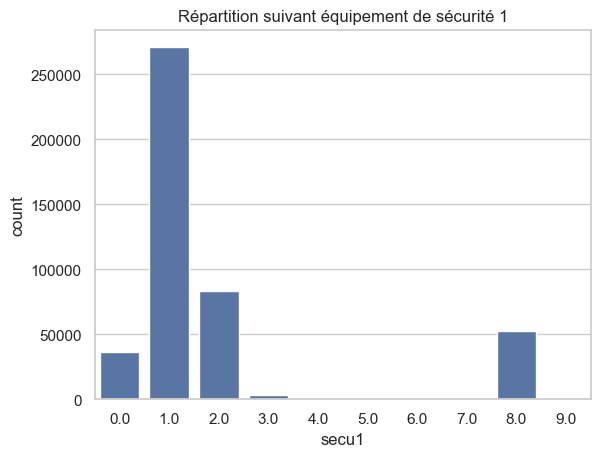

In [189]:
sns.countplot(data=data_cleaned,x="secu1")
plt.title("Répartition suivant équipement de sécurité 1")
plt.show();

In [190]:
data_cleaned.secu2.value_counts(normalize=True)

secu2
0.0    0.625760
8.0    0.171851
6.0    0.152174
5.0    0.019422
4.0    0.015879
9.0    0.005116
1.0    0.003051
2.0    0.002582
7.0    0.002250
3.0    0.001915
Name: proportion, dtype: float64

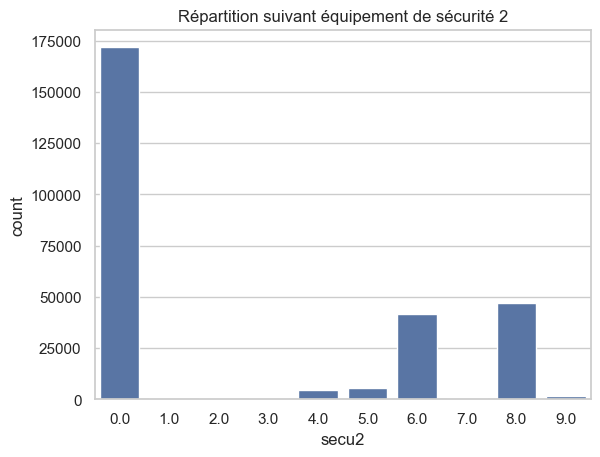

In [191]:
sns.countplot(data=data_cleaned,x="secu2")
plt.title("Répartition suivant équipement de sécurité 2")
plt.show();

In [192]:
data_cleaned.secu3.value_counts()

secu3
9.0    3279
0.0    1177
6.0     236
8.0     155
1.0      75
4.0      63
5.0      37
2.0      15
7.0      12
3.0       7
Name: count, dtype: int64

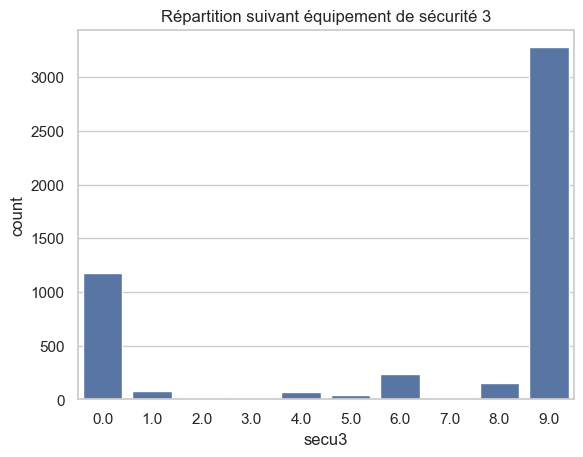

In [193]:
sns.countplot(data=data_cleaned,x="secu3")
plt.title("Répartition suivant équipement de sécurité 3")
plt.show();

Les variables secu1/secu2/secu3 n'ont pas de sens prises séparément.
=> Création de variables binaires/par équipement

In [194]:
# nouvelles variables : ceinture, casque, siège enfant, gilet, airbag, gants, non determinable, autre
data_cleaned['eq_ceinture'] = 0
data_cleaned['eq_casque'] = 0
data_cleaned['eq_siege'] = 0
data_cleaned['eq_gilet'] = 0
data_cleaned['eq_airbag'] = 0
data_cleaned['eq_gants'] = 0
data_cleaned['eq_indetermine'] = 0
data_cleaned['eq_autre'] = 0

In [195]:
# Recodage de secu1 dans les nouvelles variables créées
data_cleaned.loc[(data_cleaned['secu1'] == 1),'eq_ceinture'] = 1
data_cleaned.loc[(data_cleaned['secu1'] == 2),'eq_casque'] = 1
data_cleaned.loc[(data_cleaned['secu1'] == 3),'eq_siege'] = 1
data_cleaned.loc[(data_cleaned['secu1'] == 4),'eq_gilet'] = 1
data_cleaned.loc[(data_cleaned['secu1'] == 5),'eq_airbag'] = 1
data_cleaned.loc[(data_cleaned['secu1'] == 6),'eq_gants'] = 1
data_cleaned.loc[(data_cleaned['secu1'] == 7),'eq_airbag'] = 1
data_cleaned.loc[(data_cleaned['secu1'] == 7),'eq_gants'] = 1
data_cleaned.loc[(data_cleaned['secu1'] == 8),'eq_indetermine'] = 1
data_cleaned.loc[(data_cleaned['secu1'] == 9),'eq_autre'] = 1

In [196]:
# Recodage de secu2 dans les nouvelles variables créées
data_cleaned.loc[(data_cleaned['secu2'] == 1),'eq_ceinture'] = 1
data_cleaned.loc[(data_cleaned['secu2'] == 2),'eq_casque'] = 1
data_cleaned.loc[(data_cleaned['secu2'] == 3),'eq_siege'] = 1
data_cleaned.loc[(data_cleaned['secu2'] == 4),'eq_gilet'] = 1
data_cleaned.loc[(data_cleaned['secu2'] == 5),'eq_airbag'] = 1
data_cleaned.loc[(data_cleaned['secu2'] == 6),'eq_gants'] = 1
data_cleaned.loc[(data_cleaned['secu2'] == 7),'eq_airbag'] = 1
data_cleaned.loc[(data_cleaned['secu2'] == 7),'eq_gants'] = 1
data_cleaned.loc[(data_cleaned['secu2'] == 8),'eq_indetermine'] = 1
data_cleaned.loc[(data_cleaned['secu2'] == 9),'eq_autre'] = 1

In [197]:
# Recodage de secu3 dans les nouvelles variables créées
data_cleaned.loc[(data_cleaned['secu3'] == 1),'eq_ceinture'] = 1
data_cleaned.loc[(data_cleaned['secu3'] == 2),'eq_casque'] = 1
data_cleaned.loc[(data_cleaned['secu3'] == 3),'eq_siege'] = 1
data_cleaned.loc[(data_cleaned['secu3'] == 4),'eq_gilet'] = 1
data_cleaned.loc[(data_cleaned['secu3'] == 5),'eq_airbag'] = 1
data_cleaned.loc[(data_cleaned['secu3'] == 6),'eq_gants'] = 1
data_cleaned.loc[(data_cleaned['secu3'] == 7),'eq_airbag'] = 1
data_cleaned.loc[(data_cleaned['secu3'] == 7),'eq_gants'] = 1
data_cleaned.loc[(data_cleaned['secu3'] == 8),'eq_indetermine'] = 1
data_cleaned.loc[(data_cleaned['secu3'] == 9),'eq_autre'] = 1

In [198]:
data_cleaned.head(35)

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,place_rec,age_usager,eq_ceinture,eq_casque,eq_siege,eq_gilet,eq_airbag,eq_gants,eq_indetermine,eq_autre
0,201900000001,30,11,2019,01:30,2.0,93,93053,0,0.0,...,2.0,17.0,1,0,0,0,0,0,0,0
1,201900000001,30,11,2019,01:30,2.0,93,93053,0,0.0,...,1.0,26.0,1,0,0,0,0,0,0,0
2,201900000001,30,11,2019,01:30,2.0,93,93053,0,0.0,...,1.0,60.0,1,0,0,0,0,0,0,0
3,201900000002,30,11,2019,02:50,2.0,93,93066,0,0.0,...,1.0,25.0,1,0,0,0,0,0,0,0
4,201900000003,28,11,2019,15:15,0.0,92,92036,0,0.0,...,1.0,23.0,1,0,0,0,0,0,0,0
5,201900000003,28,11,2019,15:15,0.0,92,92036,0,0.0,...,2.0,89.0,1,0,0,0,0,0,0,0
6,201900000003,28,11,2019,15:15,0.0,92,92036,0,0.0,...,1.0,24.0,1,0,0,0,0,0,0,0
7,201900000003,28,11,2019,15:15,0.0,92,92036,0,0.0,...,1.0,53.0,1,0,0,0,0,0,0,0
8,201900000004,30,11,2019,20:20,3.0,94,94069,0,0.0,...,1.0,26.0,1,0,0,0,0,0,1,0
9,201900000004,30,11,2019,20:20,3.0,94,94069,0,0.0,...,1.0,51.0,1,0,0,0,0,0,1,0


In [199]:
data_cleaned.shape

(447843, 56)

In [200]:
df_eq = pd.crosstab(data_cleaned.eq_ceinture,data_cleaned.grav_rec,normalize='index')*100
df_eq

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
eq_ceinture,,,,
0,15.920899,53.579797,25.995834,4.503469
1,57.783498,31.721844,8.916237,1.578421


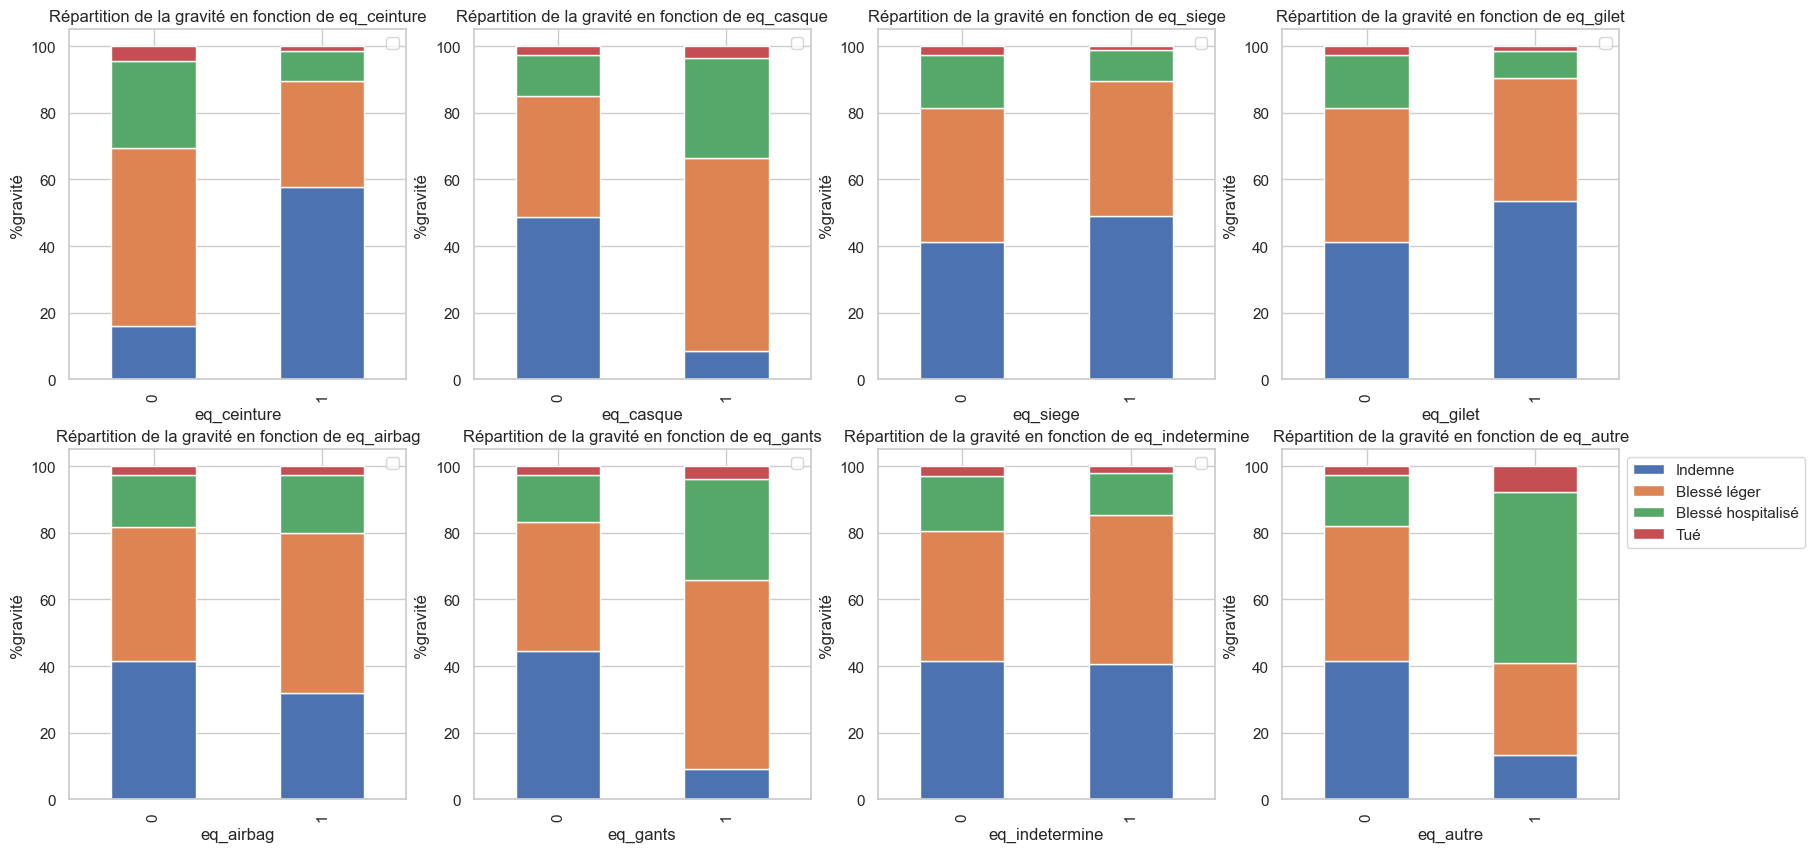

In [201]:
liste_eq = ['eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag', 'eq_gants', 'eq_indetermine', 'eq_autre']
ax_i = ['ax1', 'ax2', 'ax3', 'ax4', 'ax5', 'ax6', 'ax7', 'ax8']
i = 1

fig = plt.figure(figsize=(20,10))
for eq in liste_eq :
    df_eq = pd.crosstab(data_cleaned[eq],data_cleaned.grav_rec,normalize='index')*100
    
    ax_i[i-1] = fig.add_subplot(2, 4, i)   
    df_eq.plot(kind='bar', stacked=True, ax = ax_i[i-1])
    plt.title(f"Répartition de la gravité en fonction de {eq}")
    plt.ylabel('%gravité')
    plt.legend([])
    i += 1
    
plt.legend(bbox_to_anchor = (1, 1))  
plt.show()

#### 43.Variable locp

Définition : Localisation du piéton :   
0 – Sans objet  
Sur chaussée :  
1 – A + 50 m du passage piéton  
2 – A – 50 m du passage piéton 
Sur passage piéton :  
3 – Sans signalisation lumineuse 
4 – Avec signalisation lumineuse  
 
Divers :  
5 – Sur trottoir  
6 – Sur accotement  
7 – Sur refuge ou BAU  
8 – Sur contre allée  
9 – Inconnue

In [202]:
# Suppression de cette variable car inutile, elle sert juste à localiser le piéton sans savoir si usager=piéton
data_cleaned = data_cleaned.drop('locp', axis=1)

#### 44.Variable actp

Définition Action du piéton :   
Se déplaçant  
0 – Non renseigné ou sans objet  
1 – Sens véhicule heurtant  
2 – Sens inverse du véhicule  
Divers  
3 – Traversant  
4 – Masqué   
5 – Jouant – courant  
6 – Avec animal  
9 – Autre  
A – Monte/descend du véhicule  
B – Inconnue

In [203]:
# Suppression de cette variable car inutile, elle sert juste à localiser le piéton sans savoir si usager=piéton
data_cleaned = data_cleaned.drop('actp', axis=1)

#### 45.Variable etatp

Définition : Cette variable permet de préciser si le piéton accidenté était seul ou non :    
1 – Seul  
2 – Accompagné  
3 – En groupe

In [204]:
# Suppression de cette variable car inutile, elle sert juste à localiser le piéton sans savoir si usager=piéton
data_cleaned = data_cleaned.drop('etatp', axis=1)

#### 46.Variable id_usager

Défintion : Identifiant unique de l’usager (y compris les piétons qui sont rattachés aux véhicules qui les ont 
heurtés) – Code numérique.

In [205]:
# Suppression de cette variable car inutile
data_cleaned = data_cleaned.drop('id_usager', axis=1)

#### 47.Variable senc

Définition  : Sens de circulation\
0 – Inconnu\
1 – PK ou PR ou numéro d’adresse postale croissant\
2 – PK ou PR ou numéro d’adresse postale décroissant\
3 – Absence de repère

Suppression de la variable car dépend de la route pour savoir le sens de circulation.

In [206]:
data_cleaned = data_cleaned.drop('senc', axis = 1)

#### 48.Variable catv

Définition : Catégorie du véhicule

00 – Indéterminable   
01 – Bicyclette   
02 – Cyclomoteur <50cm3  
03 – Voiturette (Quadricycle à moteur carrossé) (anciennement "voiturette ou tricycle à moteur")  
04 – Référence inutilisée depuis 2006 (scooter immatriculé)  
05 – Référence inutilisée depuis 2006 (motocyclette)  
06 – Référence inutilisée depuis 2006 (side-car)  
07 – VL seul  
08 – Référence inutilisée depuis 2006 (VL + caravane)  
09 – Référence inutilisée depuis 2006 (VL + remorque)  
10 – VU seul 1,5T <= PTAC <= 3,5T avec ou sans remorque (anciennement VU seul 1,5T <= PTAC 
<= 3,5T)  
11 – Référence inutilisée depuis 2006 (VU (10) + caravane)  
12 – Référence inutilisée depuis 2006 (VU (10) + remorque)  
13 – PL seul 3,5T <PTCA <= 7,5T  
14 – PL seul > 7,5T  
15 – PL > 3,5T + remorque  
16 – Tracteur routier seul  
17 – Tracteur routier + semi-remorque  
18 – Référence inutilisée depuis 2006 (transport en commun)  
19 – Référence inutilisée depuis 2006 (tramway)  
20 – Engin spécial  
21 – Tracteur agricole  
30 – Scooter < 50 cm3  
31 – Motocyclette > 50 cm3 et <= 125 cm3  
32 – Scooter > 50 cm3 et <= 125 cm3  
33 – Motocyclette > 125 cm3  
34 – Scooter > 125 cm3  
35 – Quad léger <= 50 cm3 (Quadricycle à moteur non carrossé)  
36 – Quad lourd > 50 cm3 (Quadricycle à moteur non carrossé)  
37 – Autobus  
38 – Autocar  
39 – Train  
40 – Tramway  
41 – 3RM <= 50 cm3  
42 – 3RM > 50 cm3 <= 125 cm3  
43 – 3RM > 125 cm3  
50 – EDP à moteur  
60 – EDP sans moteur  
80 – VAE  
99 – Autre véhicule

In [207]:
data_cleaned['catv'].value_counts(dropna = False)

catv
7.0     284877
33.0     30676
10.0     30478
1.0      18722
2.0      14875
30.0     12811
32.0      9354
31.0      6795
50.0      4815
34.0      4557
37.0      4076
15.0      3627
14.0      3051
3.0       2849
17.0      2667
43.0      2220
99.0      1889
80.0      1624
13.0      1601
38.0      1541
21.0       975
36.0       693
60.0       666
40.0       639
20.0       627
0.0        588
39.0       171
16.0       131
35.0        95
42.0        91
41.0        55
NaN          7
Name: count, dtype: int64

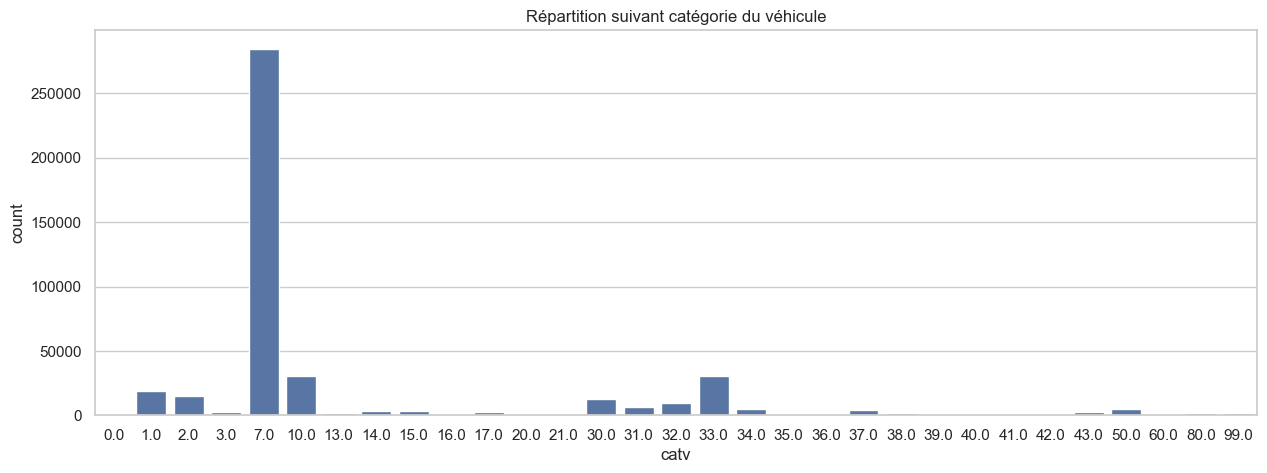

In [208]:
plt.figure(figsize = (15, 5))
sns.countplot(data=data_cleaned,x="catv")
plt.title("Répartition suivant catégorie du véhicule")
plt.show()

Suppression des lignes avec valeurs manquantes.

In [209]:
data_cleaned = data_cleaned.dropna(subset = 'catv', axis = 0)

Regroupement des 40 catégories en 5 catégories :\
0 - Voiture (3, 7, 10)\
1 - Moto (2, 30, 31, 32, 33, 34, 35, 36, 41, 42, 43)\
2 - Poids lourds (13, 14, 15, 16, 17, 20, 21)\
3 - Transport en commun (37, 38, 39, 40)\
4 - Vélo/Trotinette (1, 50, 60, 80)\
5 - Autre véhicule

In [210]:
# Recodage intermédiaire de la variable en voiture/moto/camion/transportcommun/velo&trot
### Attention=> risque de référence croisée , passage intermédiaire par 1000 à 1005
data_cleaned['catv'] = data_cleaned['catv'].replace([3,7,10], 1000)
data_cleaned['catv'] = data_cleaned['catv'].replace([2,30,31,32,33,34,35,36,41,42,43], 1001)
data_cleaned['catv'] = data_cleaned['catv'].replace([13,14,15,16,17,20,21], 1002)
data_cleaned['catv'] = data_cleaned['catv'].replace([37,38,39,40], 1003)
data_cleaned['catv'] = data_cleaned['catv'].replace([1,50,60,80], 1004)
data_cleaned['catv'] = data_cleaned['catv'].replace(99, 1005)
data_cleaned['catv'] = data_cleaned['catv'].replace([1000, 1001, 1002, 1003, 1004, 1005], [0, 1, 2, 3, 4, 5])

In [211]:
data_cleaned['catv'].value_counts()

catv
0.0    318792
1.0     82222
4.0     25827
2.0     12679
3.0      6427
5.0      1889
Name: count, dtype: int64

In [212]:
df_catv = pd.crosstab(data_cleaned.catv,data_cleaned.grav_rec,normalize='index')*100
df_catv

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
catv,,,,
0.0,50.873610,34.833371,11.859457,2.433562
1.0,8.567050,57.456642,30.257109,3.719199
2.0,74.556353,14.662040,7.445382,3.336225
3.0,57.133966,36.315544,4.978995,1.571495
4.0,6.601618,67.262942,22.720409,3.415031
5.0,40.074113,43.991530,15.246162,0.688195


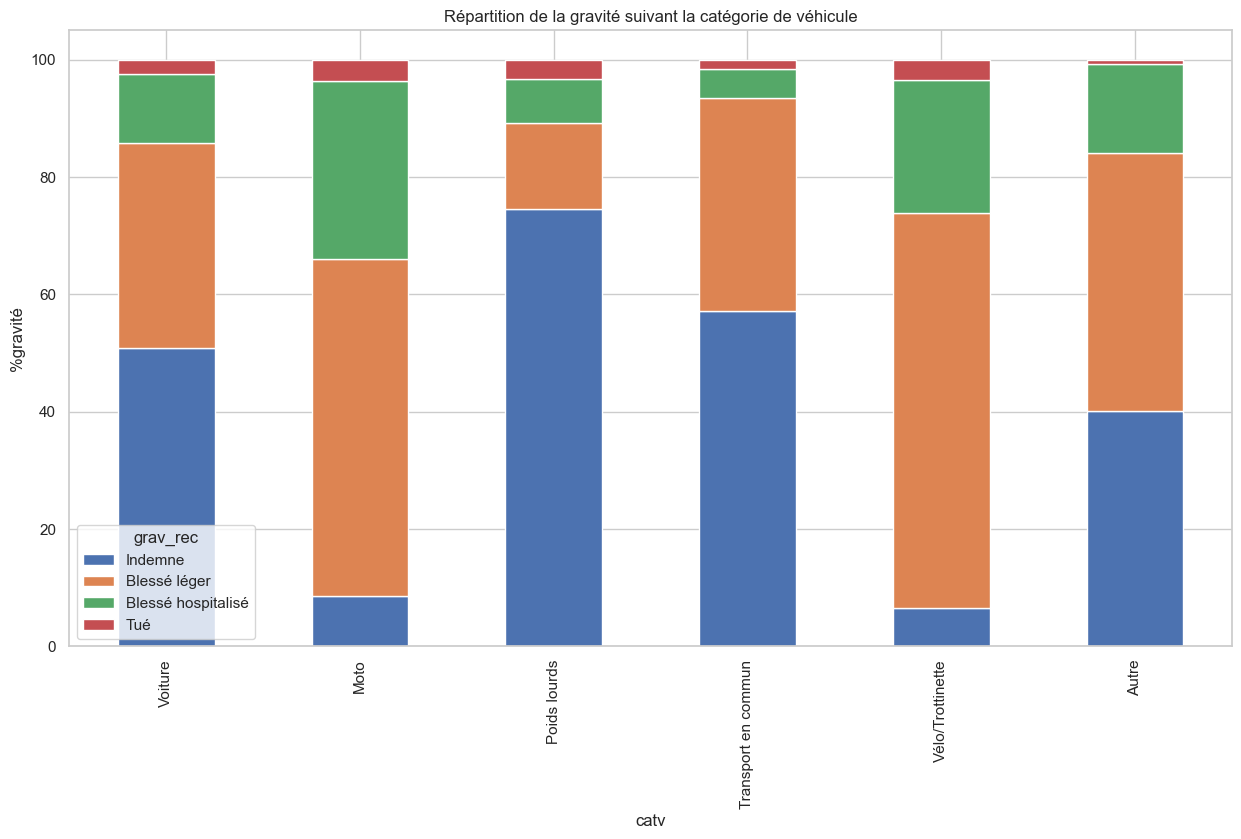

In [213]:
df_catv.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité suivant la catégorie de véhicule")
plt.ylabel('%gravité')
plt.xticks([0.0, 1.0, 2.0,3.0,4.0,5.0], ['Voiture', 'Moto', 'Poids lourds', 'Transport en commun', 'Vélo/Trottinette', 'Autre']);
plt.show()

#### 49.Variable obs

Définition : Obstacle fixe heurté :    
0 – Sans objet  
1 – Véhicule en stationnement  
2 – Arbre  
3 – Glissière métallique  
4 – Glissière béton  
5 – Autre glissière  
6 – Bâtiment, mur, pile de pont  
7 – Support de signalisation verticale ou poste d’appel d’urgence  
8 – Poteau  
9 – Mobilier urbain  
10 – Parapet  
11 – Ilot, refuge, borne haute  
12 – Bordure de trottoir  
13 – Fossé, talus, paroi rocheuse  
14 – Autre obstacle fixe sur chaussée  
15 – Autre obstacle fixe sur trottoir ou accotement  
16 – Sortie de chaussée sans obstacle  
17 – Buse – tête d’aqueduc 

In [214]:
data_cleaned['obs'].value_counts(dropna = False)

obs
0.0     374749
1.0      10521
13.0      9464
2.0       8144
4.0       7059
3.0       6971
6.0       6110
8.0       5978
12.0      3435
14.0      3279
15.0      3063
9.0       2377
16.0      2054
7.0       1585
5.0        874
11.0       868
17.0       597
10.0       596
NaN        112
Name: count, dtype: int64

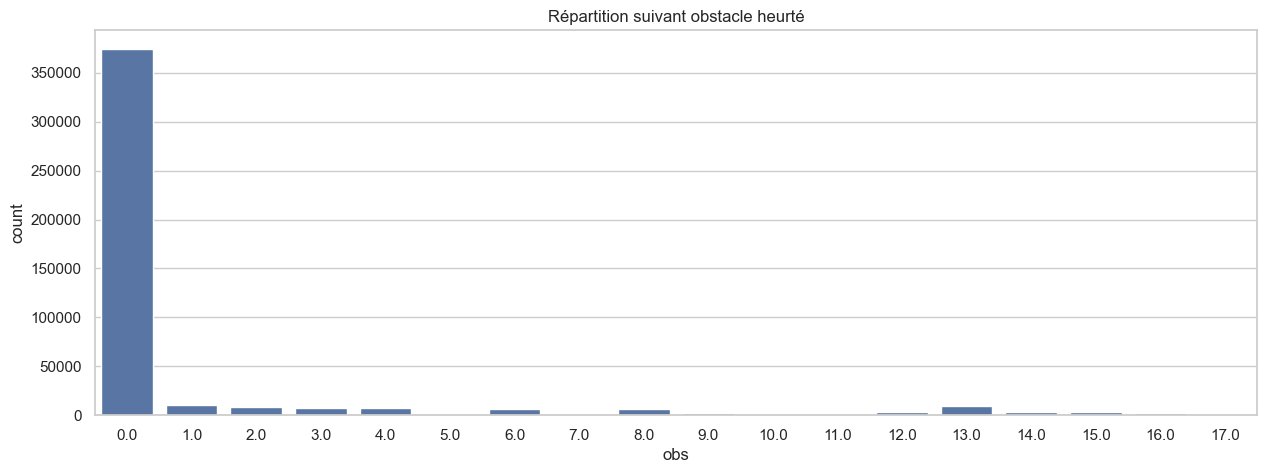

In [215]:
plt.figure(figsize = (15, 5))
sns.countplot(data=data_cleaned,x="obs")
plt.title("Répartition suivant obstacle heurté")
plt.show()

Suppression des lignes avec valeurs manquantes

In [216]:
data_cleaned = data_cleaned.dropna(subset = 'obs', axis = 0)

Regroupement en 2 catégories :\
0 - Sans obstacle\
1 - Avec obstacle

In [217]:
data_cleaned['obs'] = data_cleaned['obs'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],1)

In [218]:
data_cleaned['obs'].value_counts(dropna = False)

obs
0.0    374749
1.0     72975
Name: count, dtype: int64

In [219]:
df_obs = pd.crosstab(data_cleaned.obs,data_cleaned.grav_rec,normalize='index')*100
df_obs

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
obs,,,,
0.0,45.294050,39.566483,13.214178,1.925289
1.0,20.607057,44.335731,28.178143,6.879068


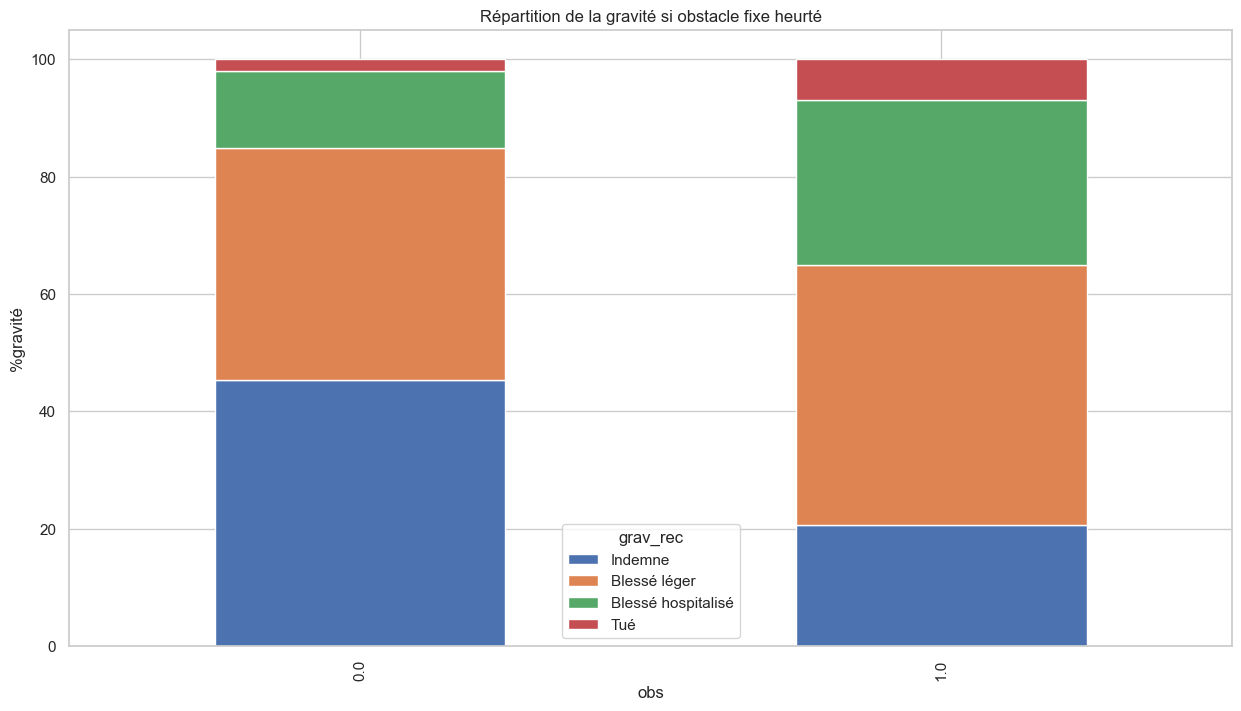

In [220]:
df_obs.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité si obstacle fixe heurté")
plt.ylabel('%gravité')
plt.show()

#### 50.Variable obsm

Définition : Obstacle mobile heurté   
0 – Aucun   
1 – Piéton  
2 – Véhicule  
4 – Véhicule sur rail  
5 – Animal domestique  
6 – Animal sauvage  
9 – Autre

In [221]:
data_cleaned['obsm'].value_counts(dropna = False)

obsm
2.0    290638
0.0     86313
1.0     63183
9.0      5549
6.0      1156
4.0       425
5.0       356
NaN       104
Name: count, dtype: int64

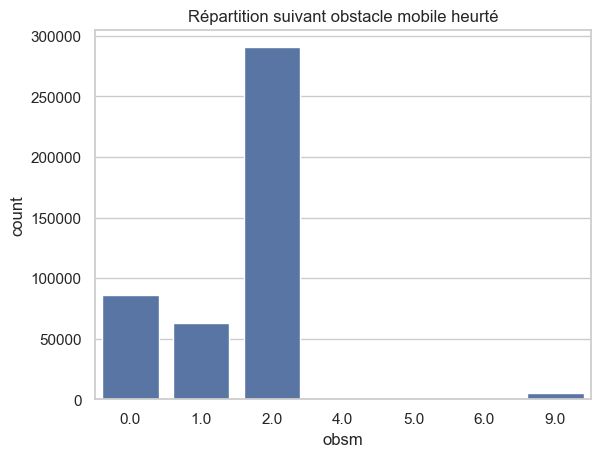

In [222]:
sns.countplot(data=data_cleaned,x="obsm")
plt.title("Répartition suivant obstacle mobile heurté")
plt.show()

Suppression des lignes avec valeurs manquantes

In [223]:
data_cleaned = data_cleaned.dropna(subset = 'obsm', axis = 0)

Regroupement en 4 catégories :\
0 - Sans obstacle\
1 - Piéton\
2 - Véhicule\
3 - Animaux/Autres

In [224]:
data_cleaned['obsm'] = data_cleaned['obsm'].replace([2,4], 2)
data_cleaned['obsm'] = data_cleaned['obsm'].replace([5,6,9], 3)

In [225]:
data_cleaned['obsm'].value_counts(dropna = False)

obsm
2.0    291063
0.0     86313
1.0     63183
3.0      7061
Name: count, dtype: int64

In [226]:
df_obsm = pd.crosstab(data_cleaned.obsm,data_cleaned.grav_rec,normalize='index')*100
df_obsm

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
obsm,,,,
0.0,22.858666,42.906631,27.983038,6.251665
1.0,46.013959,36.281911,14.931232,2.772898
2.0,45.081305,40.959517,12.250956,1.708221
3.0,66.945192,19.685597,11.740547,1.628664


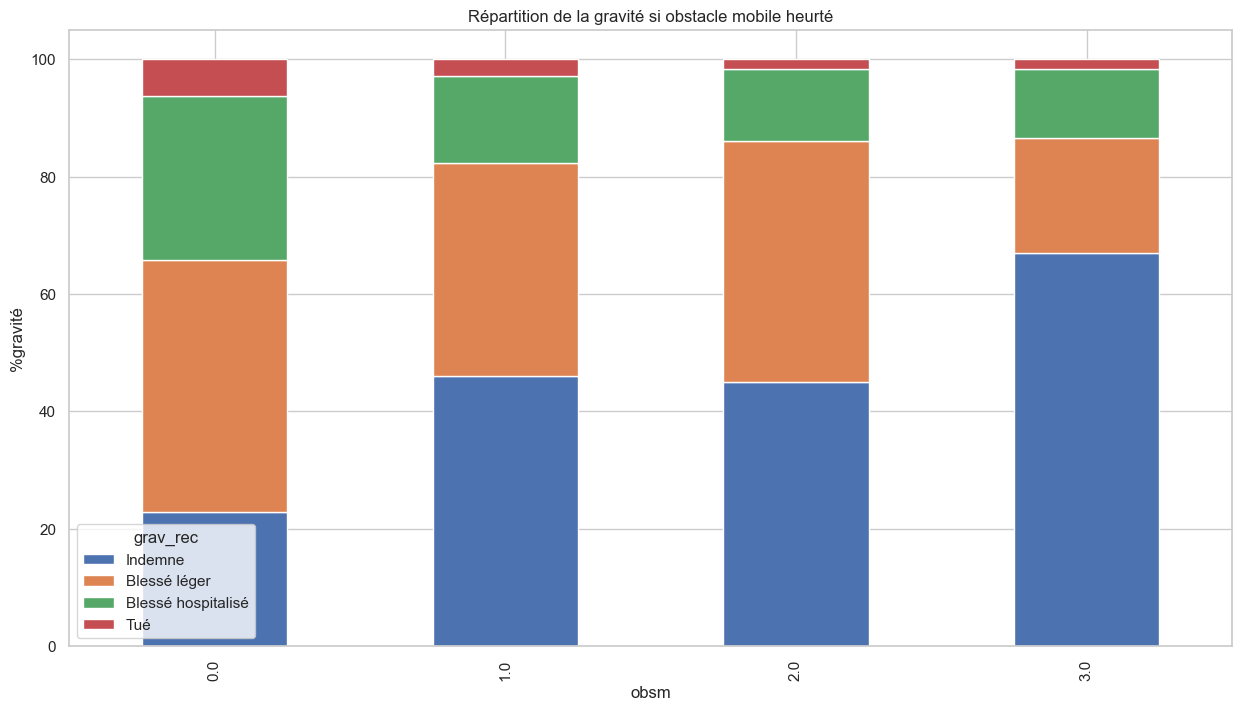

In [227]:
df_obsm.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité si obstacle mobile heurté");
plt.ylabel('%gravité')
plt.show()

#### 51.Variable choc

Point de choc initial :\
0 – Aucun\
1 – Avant\
2 – Avant droit\
3 – Avant gauche\
4 – Arrière\
5 – Arrière droit\
6 – Arrière gauche\
7 – Côté droit\
8 – Côté gauche\
9 – Chocs multiples (tonneaux)

In [228]:
data_cleaned['choc'].value_counts(dropna = False)

choc
1.0    162965
3.0     67742
2.0     58435
4.0     44938
8.0     29149
7.0     25781
0.0     22906
6.0     15749
5.0     12368
9.0      7533
NaN        54
Name: count, dtype: int64

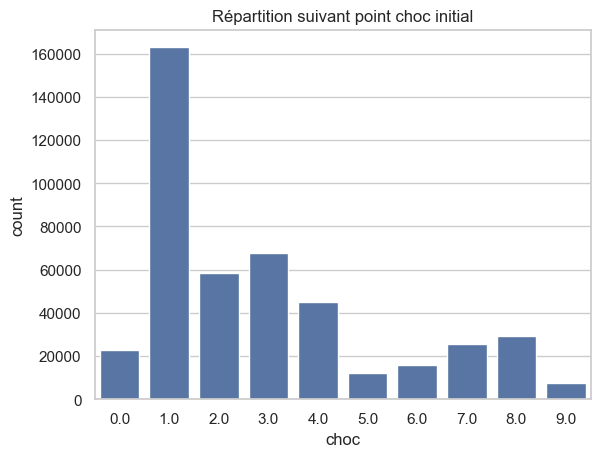

In [229]:
sns.countplot(data=data_cleaned,x="choc")
plt.title("Répartition suivant point choc initial")
plt.show()

Suppression des lignes avec valeurs manquantes.

In [230]:
data_cleaned = data_cleaned.dropna(subset = 'choc', axis = 0)

In [231]:
data_cleaned['choc'].value_counts(dropna = False)

choc
1.0    162965
3.0     67742
2.0     58435
4.0     44938
8.0     29149
7.0     25781
0.0     22906
6.0     15749
5.0     12368
9.0      7533
Name: count, dtype: int64

#### 52.Variable manv

Définition : Manoeuvre principale avant l’accident :\
0 – Inconnue\
1 – Sans changement de direction\
2 – Même sens, même file\
3 – Entre 2 files\
4 – En marche arrière\
5 – A contresens\
6 – En franchissant le terre-plein central\
7 – Dans le couloir bus, dans le même sens\
8 – Dans le couloir bus, dans le sens inverse\
9 – En s’insérant\
10 – En faisant demi-tour sur la chaussée\
Changeant de file\
11 – A gauche\
12 – A droite\
Déporté\
13 – A gauche\
14 – A droite\
Tournant\
15 – A gauche\
16 – A droite\
Dépassant\
17 – A gauche\
18 – A droite\
Divers\
19 – Traversant la chaussée\
20 – Manœuvre de stationnement\
21 – Manœuvre d’évitement\
22 – Ouverture de porte\
23 – Arrêté (hors stationnement)\
24 – En stationnement (avec occupants)\
25 – Circulant sur trottoir\
26 – Autres manœuvres

In [232]:
data_cleaned['manv'].value_counts(dropna = False)

manv
1.0     191699
2.0      50347
15.0     35633
0.0      23563
13.0     19917
26.0     14742
17.0     14727
9.0      12581
16.0     11851
23.0     11668
19.0     10903
14.0      9862
21.0      7181
11.0      4621
5.0       4611
12.0      4062
3.0       4013
10.0      2846
20.0      2399
4.0       2354
18.0      2243
24.0      1657
22.0      1234
25.0      1059
7.0        856
6.0        745
8.0        168
NaN         24
Name: count, dtype: int64

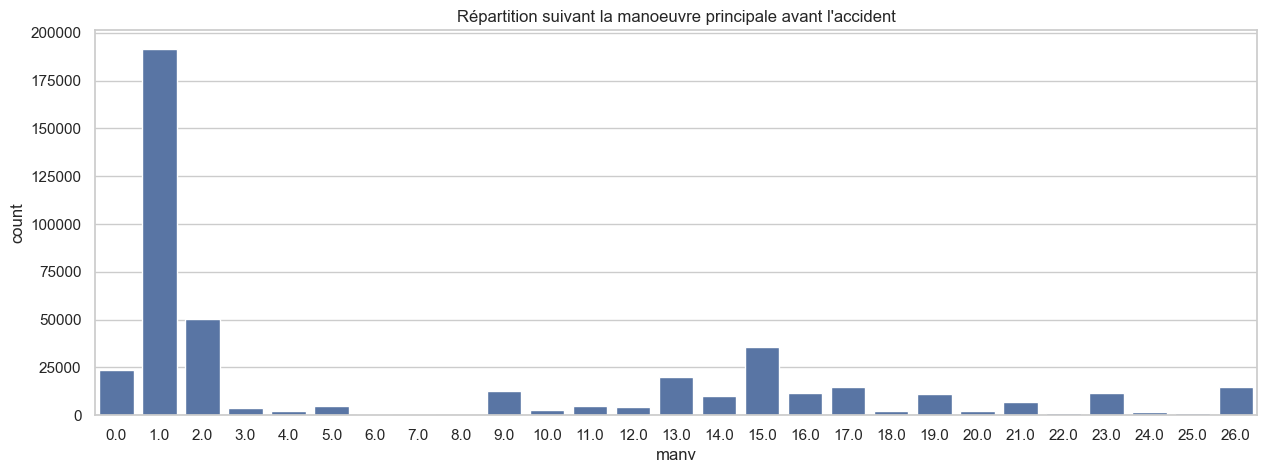

In [233]:
plt.figure(figsize = (15, 5))
sns.countplot(data=data_cleaned,x="manv")
plt.title("Répartition suivant la manoeuvre principale avant l'accident")
plt.show()

Suppression des lignes avec valeurs manquantes

In [234]:
data_cleaned = data_cleaned.dropna(subset = 'manv', axis = 0)

Regroupement en 4 catégories :\
0 - Même sens\
1 - Contre-sens\
2 - Immobile\
3 - Changement de direction

In [235]:
data_cleaned['manv'] = data_cleaned['manv'].replace([1, 2, 3, 7, 25], 0)
data_cleaned['manv'] = data_cleaned['manv'].replace([4, 5, 8], 1)
data_cleaned['manv'] = data_cleaned['manv'].replace([22, 23, 24], 2)
data_cleaned['manv'] = data_cleaned['manv'].replace([6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 26], 3)

In [236]:
data_cleaned['manv'].value_counts(dropna = False)

manv
0.0    271537
3.0    154313
2.0     14559
1.0      7133
Name: count, dtype: int64

In [237]:
df_manv = pd.crosstab(data_cleaned.manv,data_cleaned.grav_rec,normalize='index')*100
df_manv

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
manv,,,,
0.0,37.750656,42.987144,16.585953,2.676247
1.0,36.225992,38.258797,20.552362,4.962849
2.0,57.778694,36.973693,4.492067,0.755546
3.0,46.147765,36.095468,14.843856,2.912911


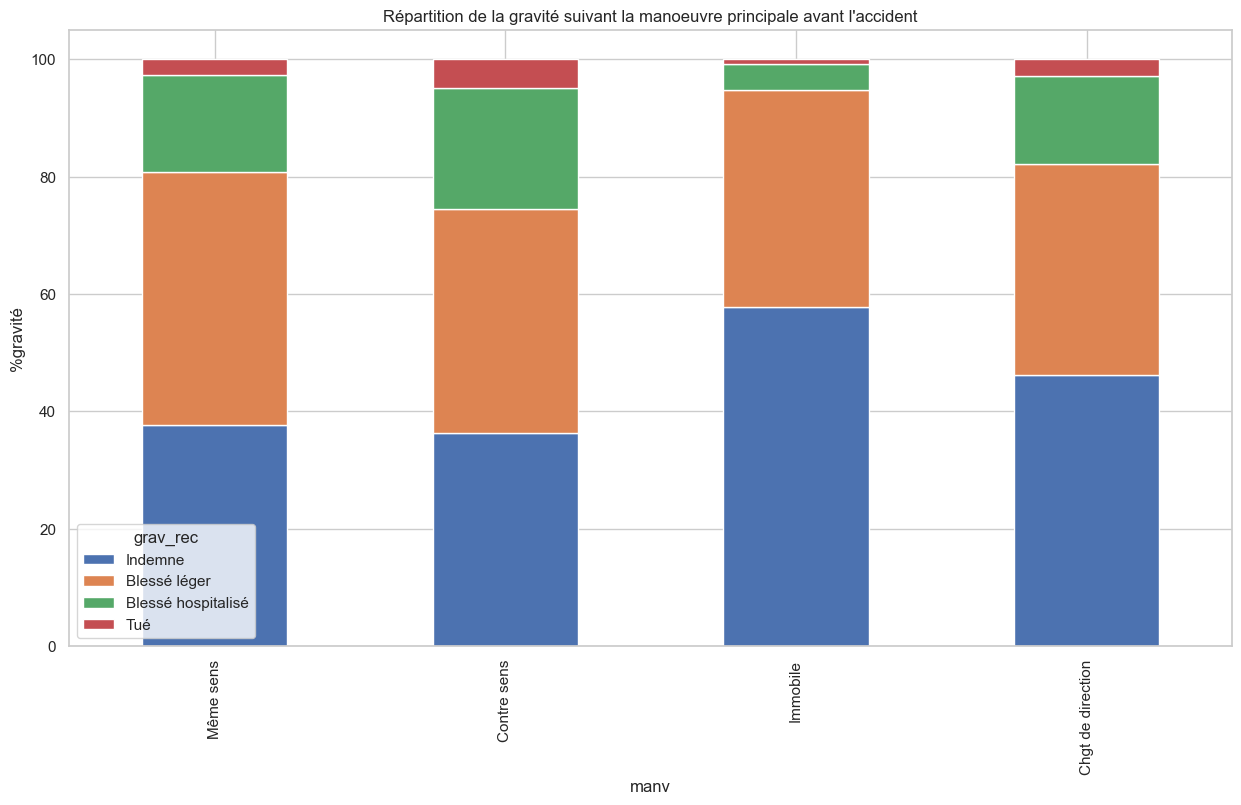

In [238]:
df_manv.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité suivant la manoeuvre principale avant l'accident")
plt.ylabel('%gravité')
plt.xticks([0.0, 1.0, 2.0,3.0], ['Même sens', 'Contre sens', 'Immobile', 'Chgt de direction']);
plt.show()

#### 53.Variable motor

Définition : Type de motorisation du véhicule :\
0 – Inconnue\
1 – Hydrocarbures\
2 – Hybride électrique\
3 – Electrique\
4 – Hydrogène\
5 – Humaine\
6 – Autre


In [239]:
data_cleaned['motor'].value_counts(dropna = False)

motor
1.0    378721
0.0     28090
5.0     17591
3.0     11387
2.0      7278
6.0      3839
NaN       366
4.0       270
Name: count, dtype: int64

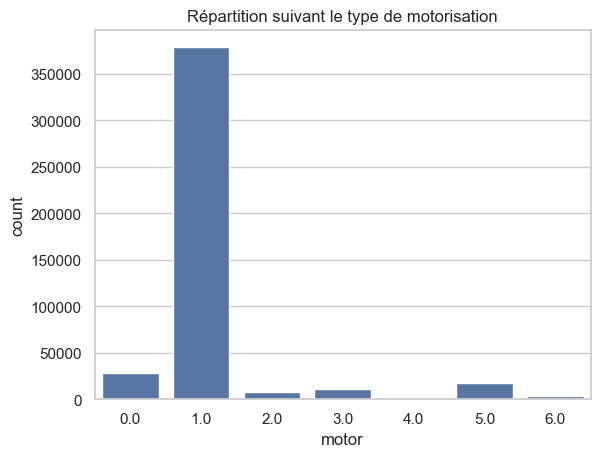

In [240]:
sns.countplot(data=data_cleaned,x="motor")
plt.title("Répartition suivant le type de motorisation")
plt.show()

Suppression des lignes avec valeurs manquantes

In [241]:
data_cleaned = data_cleaned.dropna(subset = 'motor', axis = 0)

In [242]:
data_cleaned['motor'].value_counts(dropna = False)

motor
1.0    378721
0.0     28090
5.0     17591
3.0     11387
2.0      7278
6.0      3839
4.0       270
Name: count, dtype: int64

In [243]:
df_motor = pd.crosstab(data_cleaned.motor,data_cleaned.grav_rec,normalize='index')*100
df_motor

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
motor,,,,
0.0,39.711641,42.563190,15.503738,2.221431
1.0,43.237898,38.539981,15.452272,2.769849
2.0,59.398186,32.550151,6.856279,1.195383
3.0,22.956002,61.798542,13.164135,2.081321
4.0,42.962963,44.814815,11.481481,0.740741
5.0,6.264567,65.323177,24.785402,3.626855
6.0,39.202917,38.187028,19.327950,3.282105


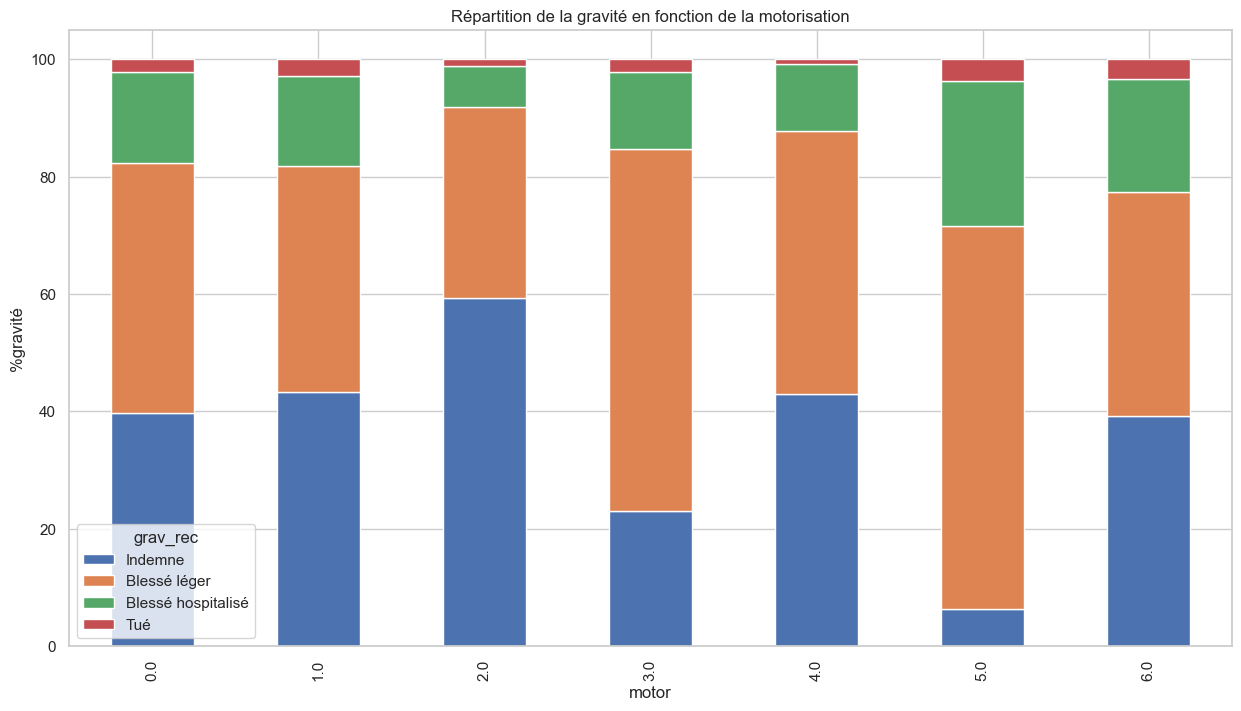

In [244]:
df_motor.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité en fonction de la motorisation")
plt.ylabel('%gravité')
plt.show()

#### 54.Variable occutc

Définition : Nombre d’occupants dans le transport en commun.

Suppression de la variable car il y a 99,76% de valeurs manquantes
Même ramenée uniquement aux lignes concernant les transports an commun, Nan trop importantes

In [245]:
data_cleaned= data_cleaned.drop('occutc', axis = 1)

#### **Nouvelle variable : Vacances ou Jour férié (ou veille de vacances ou jour férié)**

In [246]:
data_cleaned['date'] = pd.to_datetime(dates_str, format='%Y-%m-%d')
data_cleaned.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,place_rec,age_usager,eq_ceinture,eq_casque,eq_siege,eq_gilet,eq_airbag,eq_gants,eq_indetermine,eq_autre
0,201900000001,30,11,2019,01:30,2.0,93,93053,0,0.0,...,2.0,17.0,1,0,0,0,0,0,0,0
1,201900000001,30,11,2019,01:30,2.0,93,93053,0,0.0,...,1.0,26.0,1,0,0,0,0,0,0,0
2,201900000001,30,11,2019,01:30,2.0,93,93053,0,0.0,...,1.0,60.0,1,0,0,0,0,0,0,0
3,201900000002,30,11,2019,02:50,2.0,93,93066,0,0.0,...,1.0,25.0,1,0,0,0,0,0,0,0
4,201900000003,28,11,2019,15:15,0.0,92,92036,0,0.0,...,1.0,23.0,1,0,0,0,0,0,0,0


In [247]:
#Lecture du fichier des jours fériés
feries = pd.read_csv(datapath("jours_feries.csv"), sep = ",", low_memory=False)

feries['an'] = feries.date.apply(lambda x: x[:4]).astype('int')

# On ne conserve que ceux sur les années qui nous intéressent, à savoir 2019 à 2022
feries = feries.drop(feries[feries.an <= 2018].index)
feries = feries.drop(feries[feries.an > 2022].index)
feries.date = pd.to_datetime(feries.date)

# Remplacement des noms des zones par les numéros de département
france = 'Métropole|Alsace-Moselle|Guadeloupe|Guyane|Martinique|Mayotte|Nouvelle-Calédonie|La Réunion|Polynésie Française|Saint-Barthélémy|Saint-Martin|Wallis-et-Futuna|Saint-Pierre-et-Miquelon'
feries['dep'] = feries.zones.replace([france, 'Alsace-Moselle', 'Mayotte', 'Martinique', 'Guyane', 'Saint-Barthélémy',
                                     'La Réunion', 'Guadeloupe', 'Saint-Martin', 'Guadeloupe|Saint-Martin'], 
                                     ['1000000', '57-67-68', '976', '972', '973', '97123',
                                     '974', '971', '97127', '971-97127'])

deltat = pd.to_timedelta('1 days')

feries.drop_duplicates(subset=['date'], inplace=True)
feries.set_index('date', inplace=True)

feries_france = feries[feries.dep == '1000000']

liste_dep_spec = ['57', '67', '68', '976', '972', '973', '97123','974', '971', '97127', '971-97127']
feries_speciaux = feries[feries.dep != '1000000']
feries

,nom_jour_ferie,zones,an,dep
date,,,,
2019-01-01,1er janvier,Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...,2019,1000000
2019-04-19,Vendredi saint,Alsace-Moselle,2019,57-67-68
2019-04-22,Lundi de Pâques,Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...,2019,1000000
2019-04-27,Abolition de l'esclavage,Mayotte,2019,976
2019-05-01,1er mai,Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...,2019,1000000
...,...,...,...,...
2022-11-01,Toussaint,Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...,2022,1000000
2022-11-11,11 novembre,Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...,2022,1000000
2022-12-20,Abolition de l'esclavage,La Réunion,2022,974


In [248]:
data_cleaned['lendemain'] = data_cleaned.date + deltat

In [249]:
data_cleaned['is_ferie'] = data_cleaned.date.isin(feries_france.index) | data_cleaned.lendemain.isin(feries_france.index)

In [250]:
# Gestion des jours fériés spéciaux DOM-TOM
data_cleaned['is_ferie_spec'] = data_cleaned.date.isin(feries_speciaux.index)
df_spec = data_cleaned.loc[(data_cleaned.is_ferie_spec == 1) & (data_cleaned.dep.isin(liste_dep_spec))]
acc_feries_dom = df_spec[['date','dep', 'Num_Acc']].merge(feries_speciaux, on=["date", "dep"])
acc_feries_dom.set_index('Num_Acc')
data_cleaned.loc[data_cleaned.Num_Acc.isin(acc_feries_dom.index),'is_ferie'] = 1

# Gestion des jours fériés spéciaux Alsace-Moselle
acc_feries_alsace = df_spec[['date', 'dep', 'Num_Acc']].merge(feries_speciaux, on=["date"])
acc_feries_alsace = acc_feries_alsace[(acc_feries_alsace.dep_x == '57') | (acc_feries_alsace.dep_x == '67') | (acc_feries_alsace.dep_x == '68')]
acc_feries_alsace = acc_feries_alsace[(acc_feries_alsace.dep_y == '57-67-68')]
acc_feries_alsace.set_index('Num_Acc')
data_cleaned.loc[data_cleaned.Num_Acc.isin(acc_feries_alsace.index),'is_ferie'] = 1

In [251]:
# Vacances scolaires
vac = pd.read_csv( datapath("vacances_scolaires.csv"), sep=";")
vac.date = pd.to_datetime(vac.date, dayfirst=True)
vac.set_index('date')

data_cleaned['is_holidays'] = data_cleaned.date.isin(vac.index)

In [252]:
data_cleaned['jour_chome'] = data_cleaned.is_holidays | data_cleaned.is_ferie

In [253]:
data_cleaned.drop(labels = ['is_holidays', 'is_ferie', 'is_ferie_spec', 'lendemain'], axis = 1, inplace=True)

Text(0.5, 1.0, 'Vacances et jours fériés')

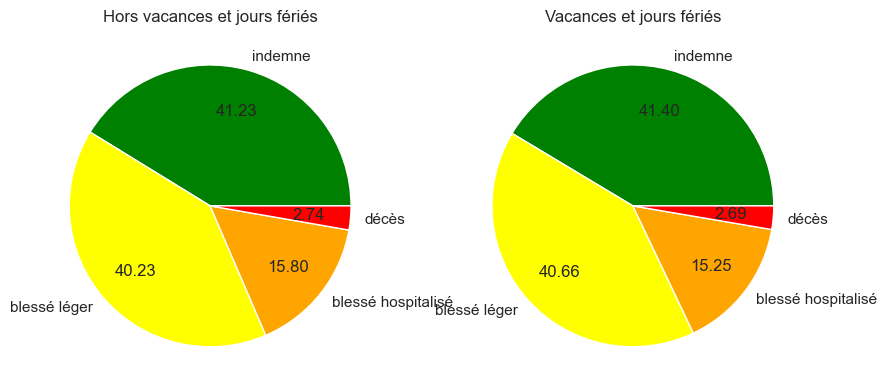

In [254]:
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.pie(data_cleaned[data_cleaned.jour_chome==0].grav_rec.value_counts().values, 
        labels = ['indemne','blessé léger','blessé hospitalisé', 'décès'],
        colors=['green','yellow','orange','red'], 
        explode=[0,0,0,0],
        autopct= '%.2f',
        pctdistance=0.7,
        labeldistance= 1.1,
        shadow=False)
plt.title('Hors vacances et jours fériés')
plt.subplot(122)
plt.pie(data_cleaned[data_cleaned.jour_chome==1].grav_rec.value_counts().values, 
        labels = ['indemne','blessé léger','blessé hospitalisé', 'décès'],
        colors=['green','yellow','orange','red'], 
        explode=[0,0,0,0],
        autopct= '%.2f',
        pctdistance=0.7,
        labeldistance= 1.1,
        shadow=False)
plt.title('Vacances et jours fériés')
#plt.legend();

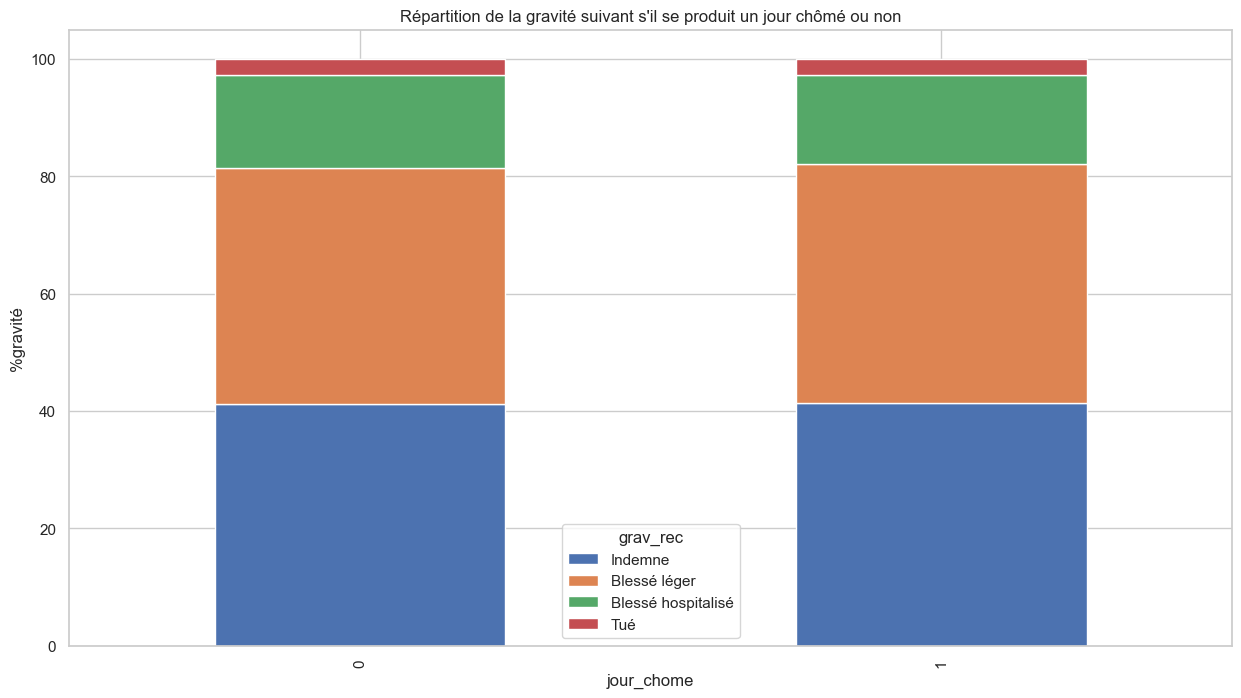

In [255]:
data_cleaned['jour_chome'] = data_cleaned['jour_chome'].replace([False, True], [0, 1])
df_jour_chome = pd.crosstab(data_cleaned.jour_chome,data_cleaned.grav_rec,normalize='index')*100
df_jour_chome.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité suivant s'il se produit un jour chômé ou non");
plt.ylabel('%gravité')
plt.show()

#### **Nouvelle variable : Proximité du point de choc**

Création d'une variable "prox_pt_choc" à partir de place et de choc pour les véhicules 

Pour mémoire : 
Catv :  0 - Voiture
        1 - Moto
        2 - Poids lourds
        3 - Transport en commun
        4 - Vélo et Trottinette
        5 - Autre véhicule

In [256]:
## Pour les catv  0, 2, 3
# choc avant et places 1, 6, 2
index_1 =(data_cleaned.loc[data_cleaned.catv.isin([0, 2, 3])].loc[data_cleaned['choc'] == 1].loc[data_cleaned['place'].isin([1, 2, 6])]).index
print(len(index_1))
# choc avant droit et places 2
index_1 = index_1.append((data_cleaned.loc[data_cleaned.catv.isin([0, 2, 3])].loc[data_cleaned['choc'] == 2].loc[(data_cleaned['place']==2)]).index)
# choc avant gauche et places 1
index_1 = index_1.append((data_cleaned.loc[data_cleaned.catv.isin([0, 2, 3])].loc[data_cleaned['choc'] == 3].loc[(data_cleaned['place']==1)]).index)
# choc arrière et places 3, 4, 5
index_1 = index_1.append((data_cleaned.loc[data_cleaned.catv.isin([0, 2, 3])].loc[data_cleaned['choc'] == 4].loc[data_cleaned['place'].isin([3, 4, 5])]).index)
# choc arrière droit et places 3
index_1 = index_1.append((data_cleaned.loc[data_cleaned.catv.isin([0, 2, 3])].loc[data_cleaned['choc'] == 5].loc[(data_cleaned['place']==3)]).index)
# choc arrière gauche et places 4
index_1 = index_1.append((data_cleaned.loc[data_cleaned.catv.isin([0, 2, 3])].loc[data_cleaned['choc'] == 6].loc[(data_cleaned['place']==4)]).index)
# choc côté droit et places 3, 9, 2
index_1 = index_1.append((data_cleaned.loc[data_cleaned.catv.isin([0, 2, 3])].loc[data_cleaned['choc'] == 7].loc[data_cleaned['place'].isin([3, 9, 2])]).index)
# choc côté gauche et places 1, 4, 7
index_1 = index_1.append((data_cleaned.loc[data_cleaned.catv.isin([0, 2, 3])].loc[data_cleaned['choc'] == 8].loc[data_cleaned['place'].isin([1, 4, 7])]).index)
# chocs multiples, toutes les places
index_1 = index_1.append((data_cleaned.loc[data_cleaned.catv.isin([0, 2, 3])].loc[data_cleaned['choc'] == 9]).index)

## Pour les catv 1 et 4, toutes les places
index_1 = index_1.append(data_cleaned.loc[data_cleaned.catv.isin([1, 4])].index)


data_cleaned.loc[:, 'prox_pt_choc'] = 0
data_cleaned.loc[index_1, 'prox_pt_choc'] = 1 

89728


In [257]:
pd.crosstab(data_cleaned.prox_pt_choc, data_cleaned.grav_rec, normalize='columns')

grav_rec,Indemne,Blessé léger,Blessé hospitalisé,Tué
prox_pt_choc,,,,
0,0.472698,0.355706,0.268573,0.292035
1,0.527302,0.644294,0.731427,0.707965


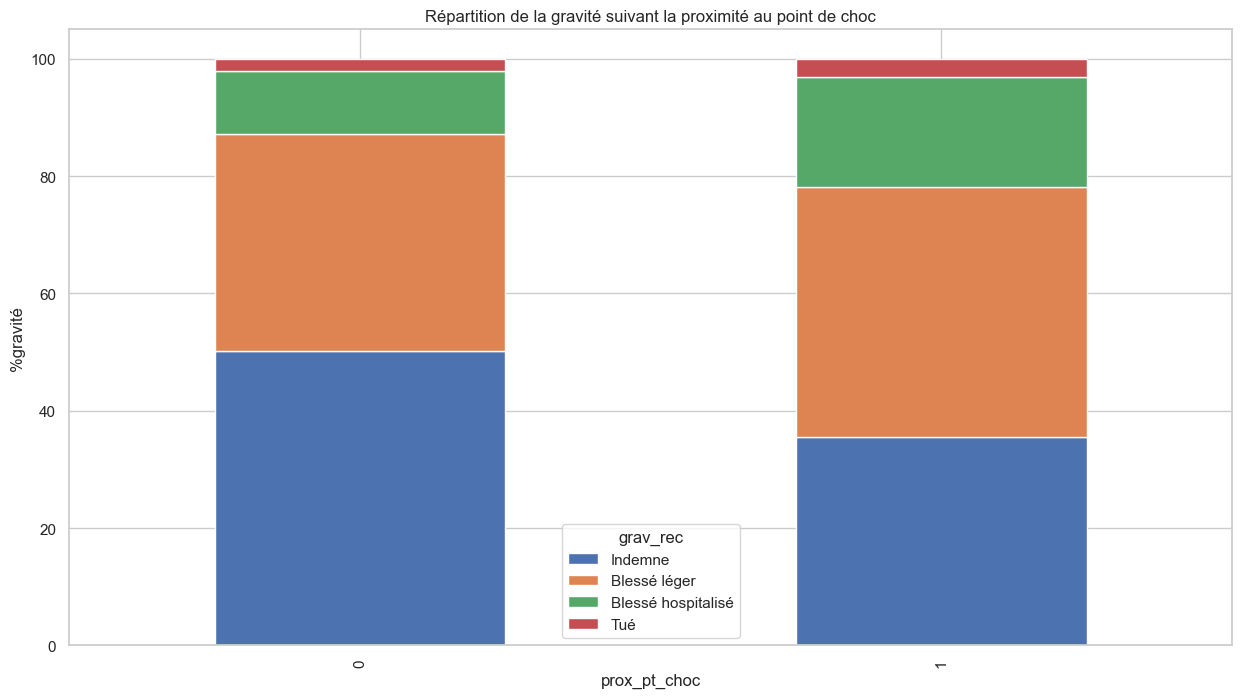

In [258]:
df_prox = pd.crosstab(data_cleaned.prox_pt_choc,data_cleaned.grav_rec,normalize='index')*100
df_prox.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité suivant la proximité au point de choc");
plt.ylabel('%gravité')
plt.show()

# Gestion des valeurs aberrantes pour lat et long

In [259]:
df_lat_long = pd.DataFrame(data_cleaned[['lat', 'long', 'dep', 'com']], columns = ['lat', 'long', 'dep', 'com'])
df_lat_long['dep'] = df_lat_long['dep'].replace(['2A', '2B'], 2)
df_lat_long['dep'] = df_lat_long['dep'].astype('int')
df_lat_long.head()

,lat,long,dep,com
0,48.896210,2.470120,93,93053
1,48.896210,2.470120,93,93053
2,48.896210,2.470120,93,93053
3,48.930700,2.368800,93,93066
4,48.935872,2.319174,92,92036


#### Métropole

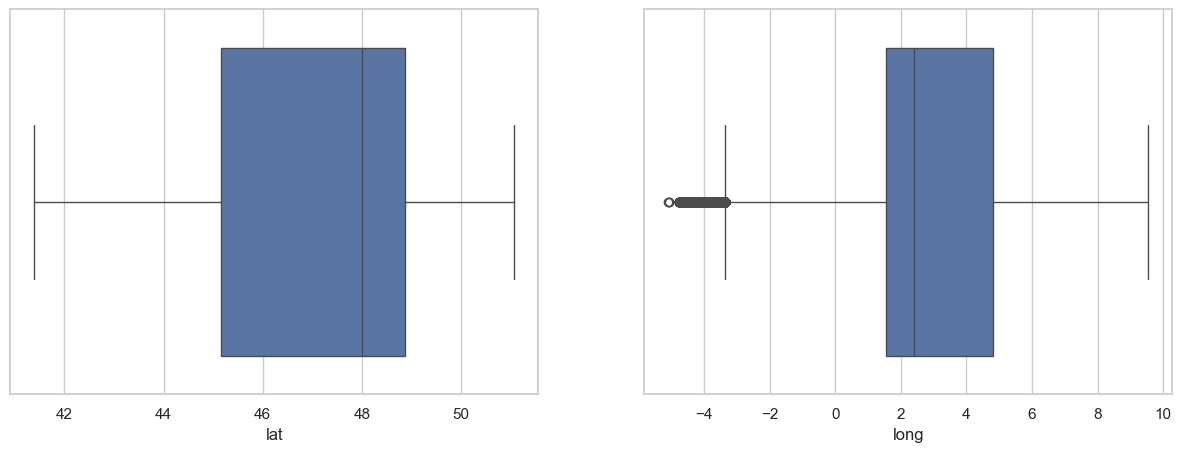

In [260]:
df_metropole = df_lat_long[['lat', 'long', 'com']][df_lat_long['dep'] <= 95]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(x = 'lat', data = df_metropole, ax = ax1)
sns.boxplot(x = 'long', data = df_metropole, ax = ax2)
plt.show()


Pour la métropole, la latitude est comprise entre 41 et 52, la longitude est comprise entre -5, 5 et 10. Donc pas de valeurs aberrantes.

#### Guadeloupe

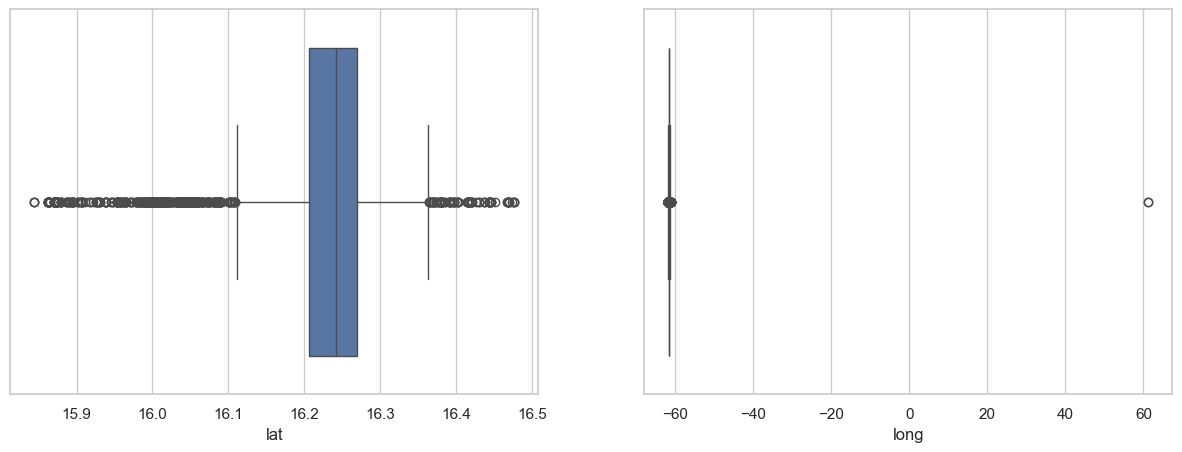

In [261]:
df_guadeloupe = df_lat_long[['lat', 'long', 'com']][df_lat_long['dep'] == 971]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(x = 'lat', data = df_guadeloupe, ax = ax1)
sns.boxplot(x = 'long', data = df_guadeloupe, ax = ax2)
plt.show()


In [262]:
df_guadeloupe.describe()

,lat,long
count,3468.000000,3468.000000
mean,16.207020,-61.458191
std,0.115226,2.951603
min,15.844031,-61.805954
25%,16.205912,-61.585124
50%,16.241742,-61.520820
75%,16.269278,-61.472205
max,16.476810,61.293760


In [263]:
display(df_guadeloupe[df_guadeloupe['long'] == 61.293760])
print("La longitude 61.293760 correspond à une erreur de transcription du signe '-'")
print("On change le signe de la longitude")

#Changement du signe
data_cleaned['long'].loc[(data_cleaned['lat'] == 16.1338) & (data_cleaned['long'] == 61.29376)] = -61.29376

,lat,long,com
19719,16.1338,61.29376,97113
19720,16.1338,61.29376,97113


La longitude 61.293760 correspond à une erreur de transcription du signe '-'
On change le signe de la longitude


#### Martinique

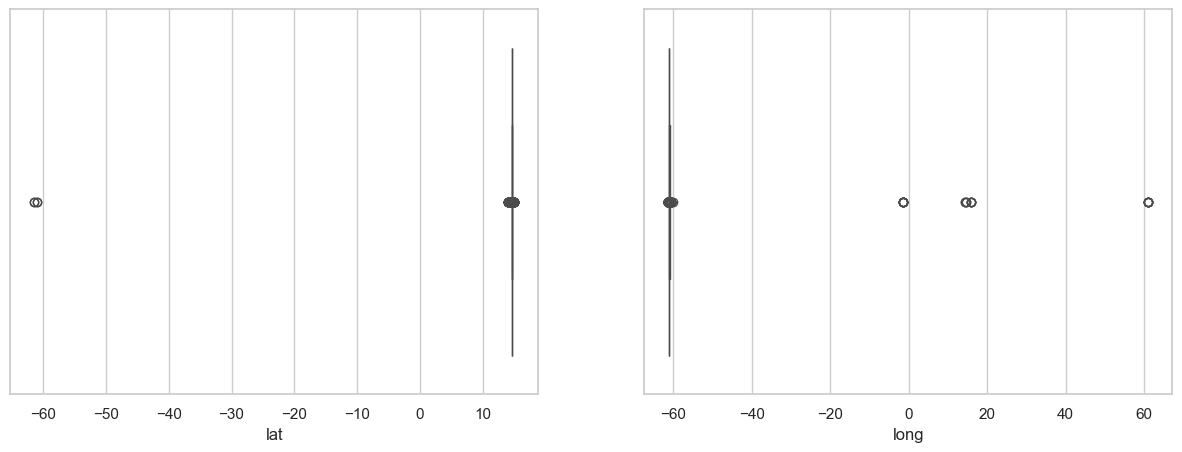

,lat,long
count,4206.000000,4206.000000
mean,14.545198,-60.590604
std,2.338929,6.236913
min,-61.425660,-61.258500
25%,14.607870,-61.059503
50%,14.616488,-61.032670
75%,14.625600,-60.993880
max,15.000000,61.087040


In [264]:
df_martinique = df_lat_long[['lat', 'long', 'com']][df_lat_long['dep'] == 972]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(x = 'lat', data = df_martinique, ax = ax1)
sns.boxplot(x = 'long', data = df_martinique, ax = ax2)
plt.show()
display(df_martinique.describe())

In [265]:
df_martinique['lat'][df_martinique['lat'] < -50].unique()

array([-61.42566, -61.0221 ])

In [266]:
df_martinique['long'][df_martinique['long'] > -10].unique()

array([16.      , 61.08704 , 14.23658 , 14.614   , 61.031   , -1.407665])

In [267]:
display(df_martinique[df_martinique['long'] == 16])
print("La commune correspond bien à la Martinique. Il y a eu une inversion du 1 et du 6.")
print("Remplacement de 16 par 61 pour la longitude.")

#Remplacment de 16 par 61 pour la longitude
data_cleaned['long'].loc[(data_cleaned['lat'] == 15.0) & (data_cleaned['long'] == 16.0)] = 61.0

,lat,long,com
16042,15.0,16.0,97213
16043,15.0,16.0,97213
16044,15.0,16.0,97213
16045,15.0,16.0,97213


La commune correspond bien à la Martinique. Il y a eu une inversion du 1 et du 6.
Remplacement de 16 par 61 pour la longitude.


In [268]:
display(df_martinique[df_martinique['long'] == 61.08704])
print("La longitude 61.08704 correspond à une erreur de transcription du signe '-'")
print("On change le signe de la longitude")

#Changement du signe
data_cleaned['long'].loc[(data_cleaned['lat'] == 14.60478) & (data_cleaned['long'] == 61.08704)] = -61.08704

,lat,long,com
46048,14.60478,61.08704,97209
46049,14.60478,61.08704,97209


La longitude 61.08704 correspond à une erreur de transcription du signe '-'
On change le signe de la longitude


In [269]:
display(df_martinique[df_martinique['long'] == 61.031])
print("La longitude 61.08704 correspond à une erreur de transcription du signe '-'")
print("On change le signe de la longitude")

#Changement du signe
data_cleaned['long'].loc[(data_cleaned['lat'] == 14.386) & (data_cleaned['long'] == 61.031)] = -61.031

,lat,long,com
80283,14.386,61.031,97213
80284,14.386,61.031,97213
80285,14.386,61.031,97213
80286,14.386,61.031,97213


La longitude 61.08704 correspond à une erreur de transcription du signe '-'
On change le signe de la longitude


In [270]:
display(df_martinique[df_martinique['long'] == 14.23658])
print("Il y a eu une inversion entre la lattitude et la longitude.")
print("On donne la valeur 14.23658 à la latitude et -61.42566 à la longitude")

#Inversion entre latitude et longitude
data_cleaned['lat'].loc[(data_cleaned['lat'] == -61.42566) & (data_cleaned['long'] == 14.23658)] = 14.23658
data_cleaned['long'].loc[(data_cleaned['lat'] == -61.42566) & (data_cleaned['long'] == 14.23658)] = -61.42566

,lat,long,com
58641,-61.42566,14.23658,97213
58642,-61.42566,14.23658,97213


Il y a eu une inversion entre la lattitude et la longitude.
On donne la valeur 14.23658 à la latitude et -61.42566 à la longitude


In [271]:
display(df_martinique[df_martinique['long'] == 14.614])
print("Il y a eu une inversion entre la lattitude et la longitude.")
print("On donne la valeur 14.614 à la latitude et -61.0221 à la longitude")

#Inversion entre latitude et longitude
data_cleaned['lat'].loc[(data_cleaned['lat'] == -61.0221) & (data_cleaned['long'] == 14.614)] = 14.614
data_cleaned['long'].loc[(data_cleaned['lat'] == -61.0221) & (data_cleaned['long'] == 14.614)] = -61.0221

,lat,long,com
80281,-61.0221,14.614,97213
80282,-61.0221,14.614,97213


Il y a eu une inversion entre la lattitude et la longitude.
On donne la valeur 14.614 à la latitude et -61.0221 à la longitude


In [272]:
df_martinique[df_martinique['long'] == -1.407665]
print("Les valeur de la longitude sont erronnées. On supprime les lignes.")

#Suppression des lignes
data_cleaned['lat'].loc[(data_cleaned['lat'] == 14.0) & (data_cleaned['long'] == -1.407665)] = np.nan
data_cleaned = data_cleaned.dropna(subset = 'lat', axis = 0)

Les valeur de la longitude sont erronnées. On supprime les lignes.


#### Guyane

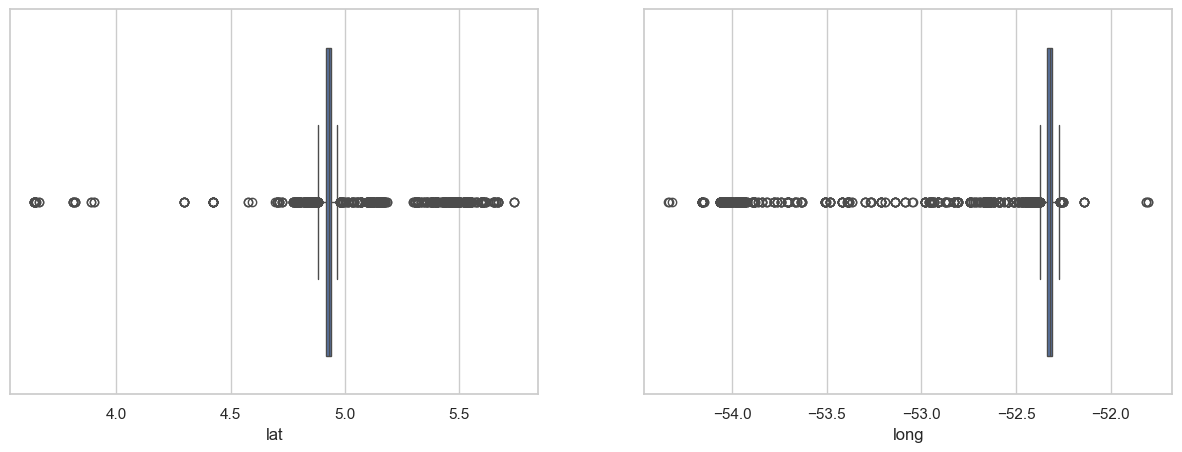

,lat,long
count,4142.000000,4142.000000
mean,4.977265,-52.508283
std,0.223185,0.490694
min,3.639562,-54.337971
25%,4.917158,-52.335713
50%,4.931717,-52.322000
75%,4.939919,-52.309420
max,5.741153,-51.800774


In [273]:
df_guyane = df_lat_long[['lat', 'long']][df_lat_long['dep'] == 973]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(x = 'lat', data = df_guyane, ax = ax1)
sns.boxplot(x = 'long', data = df_guyane, ax = ax2)
plt.show()

df_guyane.describe()

Pas de valeur aberrante.

#### La Réunion

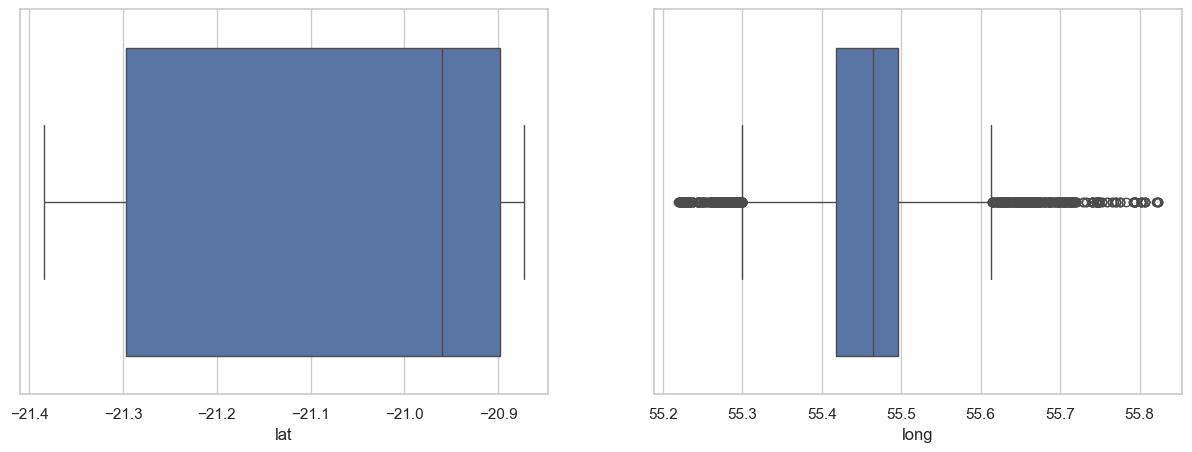

,lat,long
count,6329.000000,6329.000000
mean,-21.070571,55.456590
std,0.188285,0.109778
min,-21.384680,55.218722
25%,-21.296630,55.417680
50%,-20.959680,55.464260
75%,-20.898190,55.496090
max,-20.872243,55.823459


In [274]:
df_La_Reunion = df_lat_long[['lat', 'long']][df_lat_long['dep'] == 974]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(x = 'lat', data = df_La_Reunion, ax = ax1)
sns.boxplot(x = 'long', data = df_La_Reunion, ax = ax2)
plt.show()

df_La_Reunion.describe()

Pas de valeur aberrante.

#### Saint Pierre et Miquelon

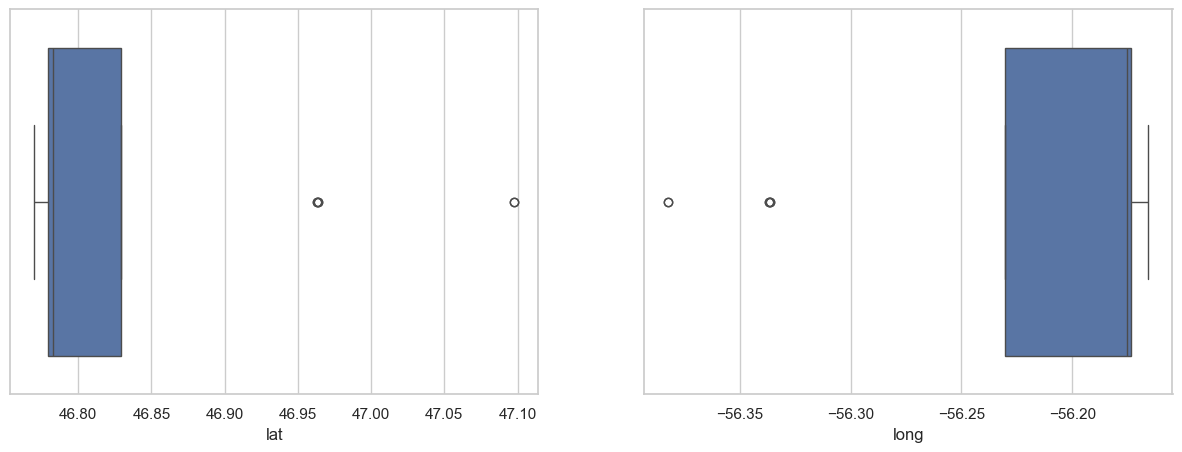

,lat,long
count,24.000000,24.000000
mean,46.836868,-56.220104
std,0.106154,0.078743
min,46.769885,-56.382260
25%,46.779682,-56.230492
50%,46.782684,-56.175263
75%,46.829522,-56.173627
max,47.097810,-56.165612


In [275]:
df_St_Pierre_et_Miquelon = df_lat_long[['lat', 'long']][df_lat_long['dep'] == 975]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(x = 'lat', data = df_St_Pierre_et_Miquelon, ax = ax1)
sns.boxplot(x = 'long', data = df_St_Pierre_et_Miquelon, ax = ax2)
plt.show()

df_St_Pierre_et_Miquelon.describe()

Pas de valeur aberrante.

#### Mayotte

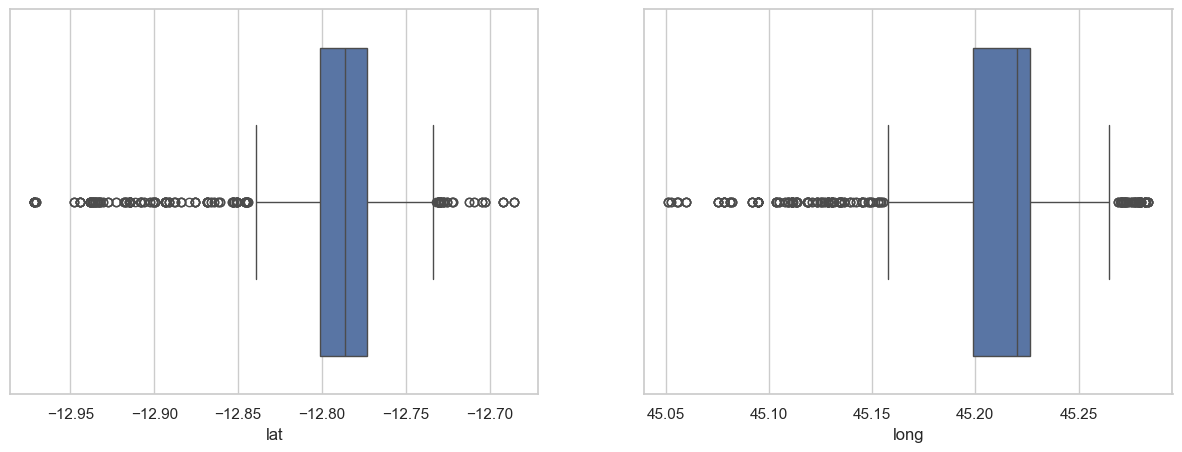

,lat,long
count,1608.000000,1608.000000
mean,-12.794953,45.205874
std,0.045054,0.041133
min,-12.971721,45.051177
25%,-12.800940,45.198660
50%,-12.786520,45.220370
75%,-12.773415,45.226275
max,-12.685329,45.283851


In [276]:
df_Mayotte = df_lat_long[['lat', 'long']][df_lat_long['dep'] == 976]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(x = 'lat', data = df_Mayotte, ax = ax1)
sns.boxplot(x = 'long', data = df_Mayotte, ax = ax2)
plt.show()

df_Mayotte.describe()

Pas de valeur aberrante.

#### Saint Barthélémy

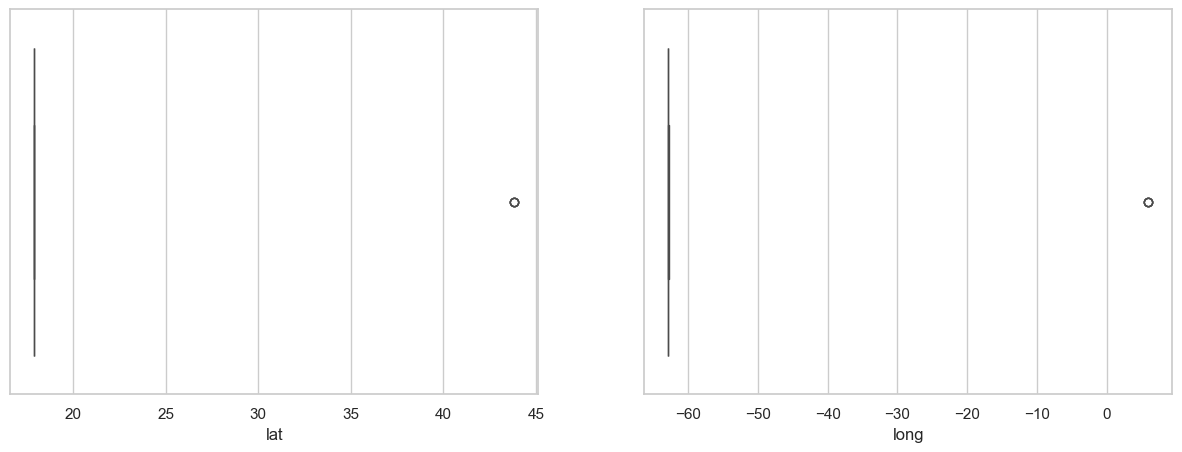

,lat,long
count,103.000000,103.000000
mean,18.909277,-60.156777
std,5.034580,13.358330
min,17.891061,-62.855165
25%,17.898841,-62.842977
50%,17.902894,-62.831519
75%,17.906503,-62.812871
max,43.834099,5.976635


In [277]:
df_St_Barthelemy = df_lat_long[['lat', 'long', 'com']][df_lat_long['dep'] == 977]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(x = 'lat', data = df_St_Barthelemy, ax = ax1)
sns.boxplot(x = 'long', data = df_St_Barthelemy, ax = ax2)
plt.show()

df_St_Barthelemy.describe()

In [278]:
df_St_Barthelemy['lat'][df_St_Barthelemy['lat'] > 40].unique()

array([43.834099])

In [279]:
df_St_Barthelemy['long'][df_St_Barthelemy['long'] > 0].unique()

array([5.976635])

In [280]:
display(df_St_Barthelemy[df_St_Barthelemy['lat'] == 43.834099])
print("La latitude et la longitude donne un emplacement dans le départment 04. Cela n'est pas possible d'après ces données.")
print("Suppression des lignes.")

#Suppression des lignes
data_cleaned['lat'].loc[(data_cleaned['lat'] == 43.834099) & (data_cleaned['long'] == 5.976635)] = np.nan
data_cleaned = data_cleaned.dropna(subset = 'lat', axis = 0)

,lat,long,com
19667,43.834099,5.976635,97701
39715,43.834099,5.976635,97701
39716,43.834099,5.976635,97701
88162,43.834099,5.976635,97701


La latitude et la longitude donne un emplacement dans le départment 04. Cela n'est pas possible d'après ces données.
Suppression des lignes.


#### Saint Martin

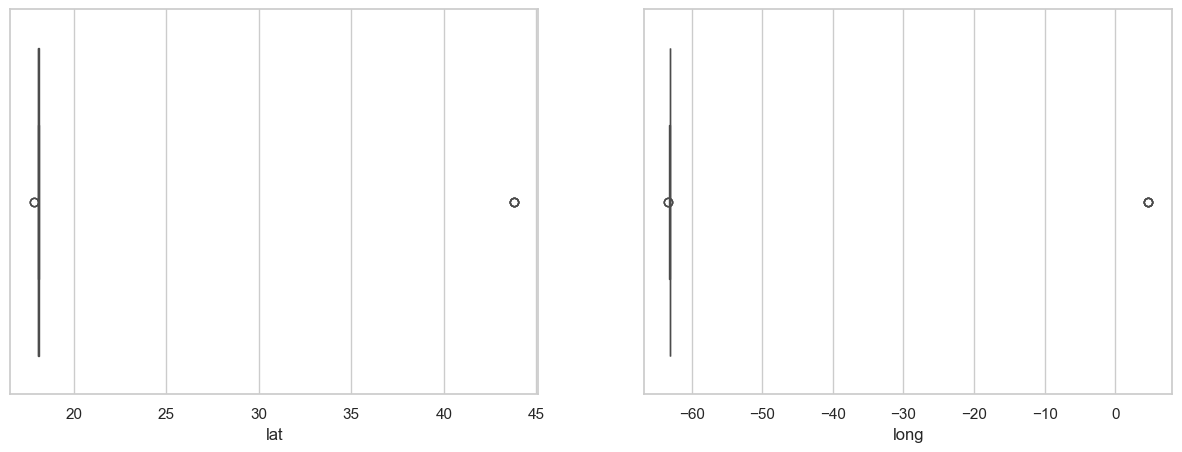

,lat,long
count,248.000000,248.000000
mean,18.594387,-61.699433
std,3.624772,9.543965
min,17.853290,-63.325196
25%,18.065588,-63.085473
50%,18.077963,-63.062189
75%,18.097463,-63.035313
max,43.812204,4.700252


In [281]:
df_St_Martin = df_lat_long[['lat', 'long', 'com']][df_lat_long['dep'] == 978]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(x = 'lat', data = df_St_Martin, ax = ax1)
sns.boxplot(x = 'long', data = df_St_Martin, ax = ax2)
plt.show()

df_St_Martin.describe()

In [282]:
df_St_Martin['lat'][df_St_Martin['lat'] > 40].unique()

array([43.812204])

In [283]:
df_St_Martin['long'][df_St_Martin['long'] > 0].unique()

array([4.700252])

In [284]:
display(df_St_Martin[df_St_Martin['lat'] == 43.812204])
print("latitude = 43.812204 et longitude = 4.700252 correspond à une route en france métropolitaine dans le dep = 13. Cela n'est pas possible.")
print("On supprime ces valeurs.")

#Suppression des lignes
data_cleaned['lat'].loc[(data_cleaned['lat'] == 43.812204) & (data_cleaned['long'] == 4.700252)] = np.nan
data_cleaned = data_cleaned.dropna(subset = 'lat', axis = 0)

,lat,long,com
48431,43.812204,4.700252,97801
48432,43.812204,4.700252,97801
48433,43.812204,4.700252,97801
48434,43.812204,4.700252,97801
48435,43.812204,4.700252,97801


latitude = 43.812204 et longitude = 4.700252 correspond à une route en france métropolitaine dans le dep = 13. Cela n'est pas possible.
On supprime ces valeurs.


#### Wallis et Futuna

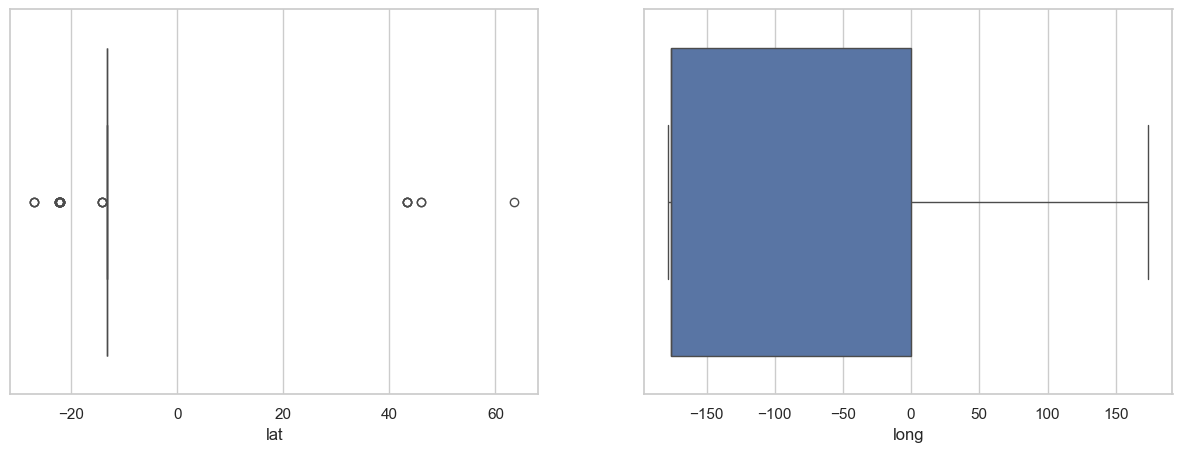

,lat,long
count,84.000000,84.000000
mean,-10.097495,-99.878788
std,17.833312,135.013244
min,-27.059126,-178.158090
25%,-13.340503,-176.193376
50%,-13.314921,-176.188059
75%,-13.277427,-0.147590
max,63.568066,174.023438


In [285]:
df_Wallis_et_Futuna = df_lat_long[['lat', 'long', 'com']][df_lat_long['dep'] == 986]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(x = 'lat', data = df_Wallis_et_Futuna, ax = ax1)
sns.boxplot(x = 'long', data = df_Wallis_et_Futuna, ax = ax2)
plt.show()

df_Wallis_et_Futuna.describe()

In [286]:
df_Wallis_et_Futuna['lat'][df_Wallis_et_Futuna['lat'] > 40].unique()

array([45.893441, 43.287224, 43.277179, 63.568066])

In [287]:
df_Wallis_et_Futuna['long'][df_Wallis_et_Futuna['long'] > -170].unique()

array([-1.47590000e-01,  1.66456796e+02,  5.45673100e+00,  1.74023438e+02,
        5.51085900e+00,  8.88238000e-01,  1.66448649e+02,  1.66439648e+02,
        1.66448943e+02,  1.66451722e+02])

In [288]:
display(df_Wallis_et_Futuna[df_Wallis_et_Futuna['lat'] == 45.893441])
print("Ces valeur ne sont pas possibles, même si on estime une erreur de virgule pour la longitude, cela donne un point au milieu du pacifique.")
print("On supprime ces données.")

#Suppression des lignes
data_cleaned['lat'].loc[(data_cleaned['lat'] == 45.893441) & (data_cleaned['long'] == -0.14759)] = np.nan
data_cleaned = data_cleaned.dropna(subset = 'lat', axis = 0)

,lat,long,com
1400,45.893441,-0.14759,98613
1401,45.893441,-0.14759,98613


Ces valeur ne sont pas possibles, même si on estime une erreur de virgule pour la longitude, cela donne un point au milieu du pacifique.
On supprime ces données.


In [289]:
display(df_Wallis_et_Futuna[df_Wallis_et_Futuna['lat'] == 43.287224])
print("Les valeurs de la latitude et de la longitude donne un point dans le départment 13. Ce n'est pas possible.")
print("On supprime ces données.")

#Suppression des lignes
data_cleaned['lat'].loc[(data_cleaned['lat'] == 43.287224) & (data_cleaned['long'] == 5.456731)] = np.nan
data_cleaned = data_cleaned.dropna(subset = 'lat', axis = 0)

,lat,long,com
97308,43.287224,5.456731,98613
97309,43.287224,5.456731,98613
97310,43.287224,5.456731,98613


Les valeurs de la latitude et de la longitude donne un point dans le départment 13. Ce n'est pas possible.
On supprime ces données.


In [290]:
display(df_Wallis_et_Futuna[df_Wallis_et_Futuna['lat'] == 43.277179])
print("Les valeurs de la latitude et de la longitude donne un point dans le départment 13. Ce n'est pas possible.")
print("On supprime ces données.")

#Suppression des lignes
data_cleaned['lat'].loc[(data_cleaned['lat'] == 43.277179) & (data_cleaned['long'] == 5.510859)] = np.nan
data_cleaned = data_cleaned.dropna(subset = 'lat', axis = 0)

,lat,long,com
127431,43.277179,5.510859,98613


Les valeurs de la latitude et de la longitude donne un point dans le départment 13. Ce n'est pas possible.
On supprime ces données.


In [291]:
display(df_Wallis_et_Futuna[df_Wallis_et_Futuna['lat'] == 63.568066])
print("Les valeurs de la latitude et de la longitude donne un point en  mer du Nord. Ce n'est pas possible.")
print("On supprime ces données.")

#Suppression des lignes
data_cleaned['lat'].loc[(data_cleaned['lat'] == 63.568066) & (data_cleaned['long'] == 0.888238)] = np.nan
data_cleaned = data_cleaned.dropna(subset = 'lat', axis = 0)

,lat,long,com
129226,63.568066,0.888238,98613


Les valeurs de la latitude et de la longitude donne un point en  mer du Nord. Ce n'est pas possible.
On supprime ces données.


In [292]:
display(df_Wallis_et_Futuna[df_Wallis_et_Futuna['long'] == 166.456796])
print("Les coordonnées correspondent à une localisation à Nouméa.")
print("Commme le départment et la commune indique Wallis et Futuna, on supprime les valeurs.")

#Suppression des lignes
data_cleaned['lat'].loc[(data_cleaned['lat'] == -22.264063) & (data_cleaned['long'] == 166.456796)] = np.nan
data_cleaned = data_cleaned.dropna(subset = 'lat', axis = 0)

,lat,long,com
95830,-22.264063,166.456796,98613
95831,-22.264063,166.456796,98613
95832,-22.264063,166.456796,98613
95833,-22.264063,166.456796,98613


Les coordonnées correspondent à une localisation à Nouméa.
Commme le départment et la commune indique Wallis et Futuna, on supprime les valeurs.


In [293]:
display(df_Wallis_et_Futuna[df_Wallis_et_Futuna['long'] == 174.023438])
print("Les valeurs de la latitude et de la longitude donne un point au milieu du pacifique. Ce n'est pas possible.")
print("On supprime ces données.")

#Suppression des lignes
data_cleaned['lat'].loc[(data_cleaned['lat'] == -27.059126) & (data_cleaned['long'] == 174.023438)] = np.nan
data_cleaned = data_cleaned.dropna(subset = 'lat', axis = 0)

,lat,long,com
110161,-27.059126,174.023438,98613
110162,-27.059126,174.023438,98613
110163,-27.059126,174.023438,98613


Les valeurs de la latitude et de la longitude donne un point au milieu du pacifique. Ce n'est pas possible.
On supprime ces données.


In [294]:
display(df_Wallis_et_Futuna[df_Wallis_et_Futuna['long'] == 166.448649])
print("Les coordonnées correspondent à une localisation à Nouméa.")
print("Commme le départment et la commune indique Wallis et Futuna, on supprime les valeurs.")

#Suppression des lignes
data_cleaned['lat'].loc[(data_cleaned['lat'] == -22.280052) & (data_cleaned['long'] == 166.448649)] = np.nan
data_cleaned = data_cleaned.dropna(subset = 'lat', axis = 0)

,lat,long,com
173034,-22.280052,166.448649,98613


Les coordonnées correspondent à une localisation à Nouméa.
Commme le départment et la commune indique Wallis et Futuna, on supprime les valeurs.


In [295]:
display(df_Wallis_et_Futuna[df_Wallis_et_Futuna['long'] == 166.439648])
print("Les coordonnées correspondent à une localisation à Nouméa.")
print("Commme le départment et la commune indique Wallis et Futuna, on supprime les valeurs.")

#Suppression des lignes
data_cleaned['lat'].loc[(data_cleaned['lat'] == -22.236542) & (data_cleaned['long'] == 166.439648)] = np.nan
data_cleaned = data_cleaned.dropna(subset = 'lat', axis = 0)

,lat,long,com
197770,-22.236542,166.439648,98613
197771,-22.236542,166.439648,98613


Les coordonnées correspondent à une localisation à Nouméa.
Commme le départment et la commune indique Wallis et Futuna, on supprime les valeurs.


In [296]:
display(df_Wallis_et_Futuna[df_Wallis_et_Futuna['long'] == 166.448943])
print("Les coordonnées correspondent à une localisation à Nouméa.")
print("Commme le départment et la commune indique Wallis et Futuna, on supprime les valeurs.")

#Suppression des lignes
data_cleaned['lat'].loc[(data_cleaned['lat'] == -22.280387) & (data_cleaned['long'] == 166.448943)] = np.nan
data_cleaned = data_cleaned.dropna(subset = 'lat', axis = 0)

,lat,long,com
221329,-22.280387,166.448943,98613


Les coordonnées correspondent à une localisation à Nouméa.
Commme le départment et la commune indique Wallis et Futuna, on supprime les valeurs.


In [297]:
display(df_Wallis_et_Futuna[df_Wallis_et_Futuna['long'] == 166.451722])
print("Les coordonnées correspondent à une localisation à Nouméa.")
print("Commme le départment et la commune indique Wallis et Futuna, on supprime les valeurs.")

#Suppression des lignes
data_cleaned['lat'].loc[(data_cleaned['lat'] == -22.238151) & (data_cleaned['long'] == 166.451722)] = np.nan
data_cleaned = data_cleaned.dropna(subset = 'lat', axis = 0)

,lat,long,com
228355,-22.238151,166.451722,98613
228356,-22.238151,166.451722,98613
228357,-22.238151,166.451722,98613
228358,-22.238151,166.451722,98613


Les coordonnées correspondent à une localisation à Nouméa.
Commme le départment et la commune indique Wallis et Futuna, on supprime les valeurs.


#### Polynésie française

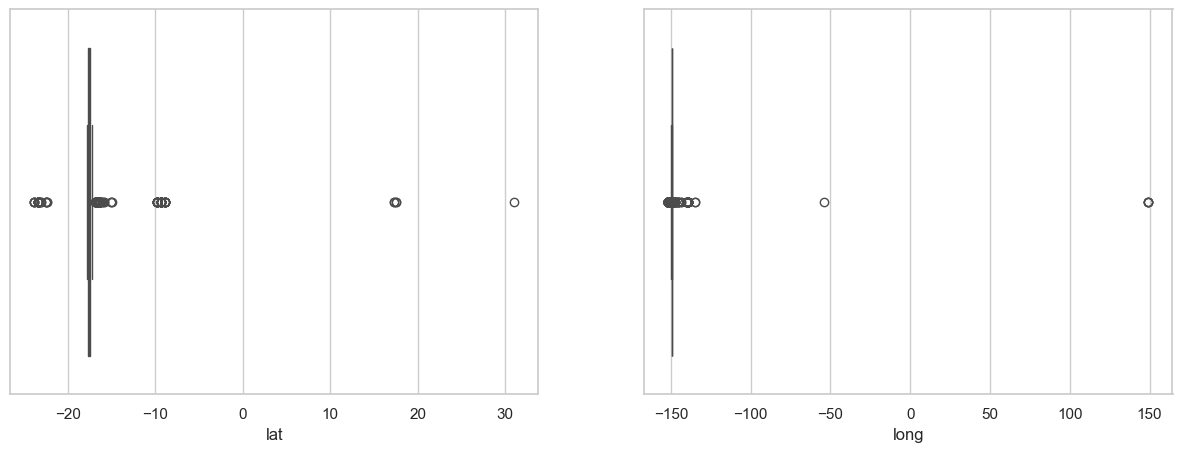

,lat,long
count,1057.000000,1057.000000
mean,-17.125941,-148.218004
std,3.158852,18.693220
min,-23.876829,-151.765098
25%,-17.689931,-149.614134
50%,-17.562591,-149.560000
75%,-17.511238,-149.474028
max,31.052934,149.343700


In [298]:
df_Polynésie = df_lat_long[['lat', 'long', 'com']][df_lat_long['dep'] == 987]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(x = 'lat', data = df_Polynésie, ax = ax1)
sns.boxplot(x = 'long', data = df_Polynésie, ax = ax2)
plt.show()

df_Polynésie.describe()

In [299]:
df_Polynésie['lat'][df_Polynésie['lat'] > 10].unique()

array([17.3238  , 31.052934, 17.542   ])

In [300]:
df_Polynésie['long'][df_Polynésie['long'] > -40].unique()

array([149.3437, 149.    ])

In [301]:
display(df_Polynésie[df_Polynésie['lat'] == 17.3238])
print("Il y a eu un oubli des signes '-'")
print("On ajoute les signes '-' à lattitude et à longitude")

# Ajout des signes "-"
data_cleaned['lat'].loc[(data_cleaned['lat'] == 17.3238) & (data_cleaned['long'] == 149.3437)] = -17.3238
data_cleaned['long'].loc[(data_cleaned['lat'] == 17.3238) & (data_cleaned['long'] == 149.3437)] = -149.3437

,lat,long,com
13375,17.3238,149.3437,98735
13376,17.3238,149.3437,98735


Il y a eu un oubli des signes '-'
On ajoute les signes '-' à lattitude et à longitude


In [302]:
display(df_Polynésie[df_Polynésie['lat'] == 31.052934])
print("Ces coordonnées donne un point au milieu de la mer des Sargasse. Ce n'est pas possible.")
print("On supprime ces valeurs.")

#Suppression des lignes
data_cleaned['lat'].loc[(data_cleaned['lat'] == 31.052934) & (data_cleaned['long'] == -53.789063)] = np.nan
data_cleaned = data_cleaned.dropna(subset = 'lat', axis = 0)

,lat,long,com
39336,31.052934,-53.789063,98729


Ces coordonnées donne un point au milieu de la mer des Sargasse. Ce n'est pas possible.
On supprime ces valeurs.


In [303]:
display(df_Polynésie[df_Polynésie['lat'] == 17.542])
print("Il y a eu un oubli des signes '-'")
print("On ajoute les signes '-' à lattitude et à longitude")

# Ajout des signes "-"
data_cleaned['lat'].loc[(data_cleaned['lat'] == 17.542) & (data_cleaned['long'] == 149.0)] = -17.542
data_cleaned['long'].loc[(data_cleaned['lat'] == 17.542) & (data_cleaned['long'] == 149.0)] = -149.0

,lat,long,com
75140,17.542,149.0,98735
75141,17.542,149.0,98735


Il y a eu un oubli des signes '-'
On ajoute les signes '-' à lattitude et à longitude


#### Nouvelle Calédonie

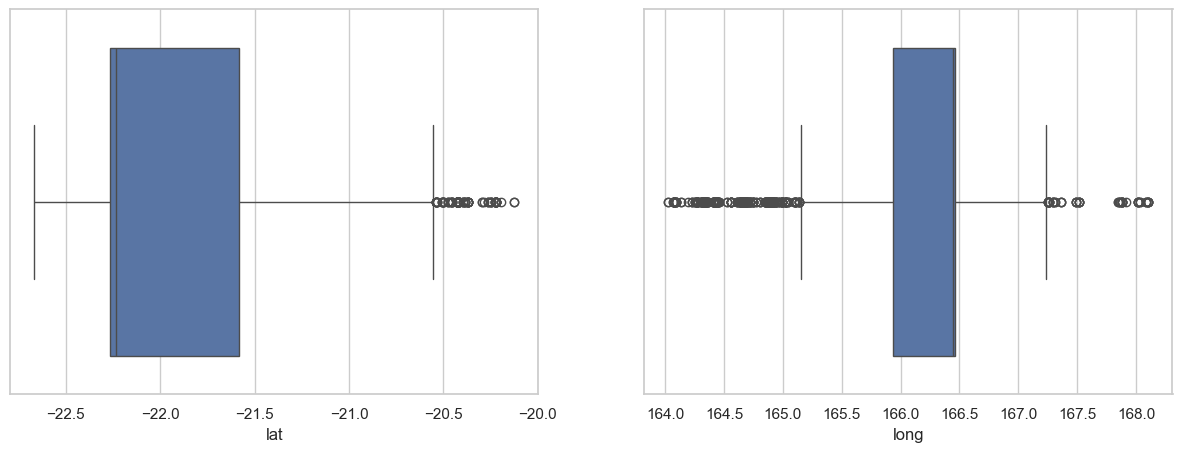

,lat,long
count,2969.000000,2969.000000
mean,-21.896288,166.141257
std,0.568012,0.676095
min,-22.668947,164.024660
25%,-22.268660,165.936620
50%,-22.233300,166.444490
75%,-21.581446,166.462610
max,-20.123850,168.106549


In [304]:
df_Nouvelle_Caledonie = df_lat_long[['lat', 'long']][df_lat_long['dep'] == 988]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(x = 'lat', data = df_Nouvelle_Caledonie, ax = ax1)
sns.boxplot(x = 'long', data = df_Nouvelle_Caledonie, ax = ax2)
plt.show()

df_Nouvelle_Caledonie.describe()

Il n'y a pas de valeurs aberrantes.

# Sauvegarde du jeu de données sans dummies

In [305]:
#Suppression des variables inutiles
data_cleaned.drop(['Num_Acc', 'place', 'secu1', 'secu2', 'secu3', 'an_nais', 'hrmn', 'choc', 'com'], axis=1, inplace=True)

In [306]:
df = data_cleaned

In [307]:
# Création d'un df_var d'exploration synthétique des variables
liste_var = []
type_var = []
format_var = []
nan_var = []
liste_nunique = []
liste_valeurs = []
nb_non_renseigne = []


for i in df.columns :
    liste_var.append(i)
    nan_var.append(round(100*df[i].isnull().sum()/df.shape[0],2))
    format_var.append(df[i].dtype)
    liste_nunique.append(df[i].nunique())
    if (i == 'grav_rec'):
        liste_valeurs.append(df[i].unique())
    else:
        if df[i].nunique() < 20 :
            liste_valeurs.append(sorted(df[i].unique()))
        else :
            liste_valeurs.append('>20')
    if i == 'grav' :
        type_var.append('Cible')
    else :
        type_var.append('Explicative')
    if df[(df[i] == -1) | (df[i] == ' -1') | (df[i] == ' ') | (df[i] == '.')].shape[0] > 0 :
        nb_non_renseigne.append(round(100*df[(df[i] == -1) | (df[i] == ' -1') | (df[i] == ' ') | (df[i] == '.')].shape[0]/df.shape[0],2))
    else :
        nb_non_renseigne.append(0)
                

dict = {'Variable':liste_var,
        'Type variable':type_var ,
        'Format_variable':format_var,
        '%NaN':nan_var,
        'Nombre modalités':liste_nunique,
        '% obs non renseignées (-1)': nb_non_renseigne,
        'Valeurs':liste_valeurs}
df_var = pd.DataFrame.from_dict(dict)

In [308]:
df_var

,Variable,Type variable,Format_variable,%NaN,Nombre modalités,% obs non renseignées (-1),Valeurs
0,jour,Explicative,int64,0.0,31,0.0,>20
1,mois,Explicative,int64,0.0,12,0.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
2,an,Explicative,int64,0.0,4,0.0,"[2019, 2020, 2021, 2022]"
3,lum,Explicative,float64,0.0,4,0.0,"[0.0, 1.0, 2.0, 3.0]"
4,dep,Explicative,object,0.0,107,0.0,>20
5,agg,Explicative,int64,0.0,2,0.0,"[0, 1]"
6,int,Explicative,float64,0.0,2,0.0,"[0.0, 1.0]"
7,atm,Explicative,float64,0.0,2,0.0,"[0.0, 1.0]"
8,col,Explicative,float64,0.0,7,0.0,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]"
9,lat,Explicative,float64,0.0,180016,0.0,>20


In [309]:
data_cleaned.shape

(447136, 43)

In [310]:
data_cleaned.to_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies_nb_usagers.csv")

In [311]:
#Suppression des variables 'nb_usagers', 'nb_usager_gr'
data_cleaned2 = data_cleaned.copy()
data_cleaned2.drop(['nb_usagers', 'nb_usagers_gr'], axis=1, inplace=True)
data_cleaned2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494017
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   jour            447136 non-null  int64         
 1   mois            447136 non-null  int64         
 2   an              447136 non-null  int64         
 3   lum             447136 non-null  float64       
 4   dep             447136 non-null  object        
 5   agg             447136 non-null  int64         
 6   int             447136 non-null  float64       
 7   atm             447136 non-null  float64       
 8   col             447136 non-null  float64       
 9   lat             447136 non-null  float64       
 10  long            447136 non-null  float64       
 11  catr            447136 non-null  int64         
 12  circ            447136 non-null  float64       
 13  prof            447136 non-null  float64       
 14  plan            447136 non-null  float64 

In [312]:
data_cleaned2.to_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv")

# Création de dummies

Création de dummies pour les variables catégorielles non binaires

In [313]:
data_cleaned_final = data_cleaned.copy()

var_cat = ['lum', 'catr', 'surf', 'infra', 'situ', 'place_rec', 'catv', 'obsm', 'manv', 'motor', 'col']

for var in var_cat :
    data_cleaned_final = data_cleaned_final.join(pd.get_dummies(data_cleaned[var], prefix = var))
    
data_cleaned_final =data_cleaned_final.replace(True, 1)
data_cleaned_final =data_cleaned_final.replace(False, 0)
    
data_cleaned_final.head()

,jour,mois,an,lum,dep,agg,int,atm,col,lat,...,motor_4.0,motor_5.0,motor_6.0,col_1.0,col_2.0,col_3.0,col_4.0,col_5.0,col_6.0,col_7.0
0,30,11,2019,2.0,93,0,0.0,0.0,2.0,48.896210,...,0,0,0,0,1,0,0,0,0,0
1,30,11,2019,2.0,93,0,0.0,0.0,2.0,48.896210,...,0,0,0,0,1,0,0,0,0,0
2,30,11,2019,2.0,93,0,0.0,0.0,2.0,48.896210,...,0,0,0,0,1,0,0,0,0,0
3,30,11,2019,2.0,93,0,0.0,0.0,6.0,48.930700,...,0,0,0,0,0,0,0,0,1,0
4,28,11,2019,0.0,92,0,0.0,0.0,4.0,48.935872,...,0,0,0,0,0,0,1,0,0,0


# Sauvegarde et analyse des corrélations

In [314]:
data_cleaned_final.columns[0:40]

Index(['jour', 'mois', 'an', 'lum', 'dep', 'agg', 'int', 'atm', 'col', 'lat',
       'long', 'catr', 'circ', 'prof', 'plan', 'surf', 'infra', 'situ', 'grav',
       'sexe', 'catv', 'obs', 'obsm', 'manv', 'motor', 'grav_rec',
       'nb_usagers', 'nb_usagers_gr', 'date', 'weekend', 'heure', 'place_rec',
       'age_usager', 'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet',
       'eq_airbag', 'eq_gants', 'eq_indetermine'],
      dtype='object')

In [315]:
data_cleaned_final.columns[40:80]

Index(['eq_autre', 'jour_chome', 'prox_pt_choc', 'lum_0.0', 'lum_1.0',
       'lum_2.0', 'lum_3.0', 'catr_1', 'catr_2', 'catr_3', 'catr_4', 'catr_5',
       'catr_6', 'catr_7', 'catr_9', 'surf_1.0', 'surf_2.0', 'surf_3.0',
       'surf_4.0', 'surf_5.0', 'surf_6.0', 'surf_7.0', 'surf_8.0', 'surf_9.0',
       'infra_0.0', 'infra_1.0', 'infra_2.0', 'infra_3.0', 'infra_4.0',
       'infra_5.0', 'infra_6.0', 'infra_7.0', 'infra_8.0', 'infra_9.0',
       'situ_1.0', 'situ_2.0', 'situ_3.0', 'situ_4.0', 'situ_5.0', 'situ_6.0'],
      dtype='object')

In [316]:
data_cleaned_final.columns[80:]

Index(['situ_8.0', 'place_rec_1.0', 'place_rec_2.0', 'place_rec_3.0',
       'place_rec_4.0', 'catv_0.0', 'catv_1.0', 'catv_2.0', 'catv_3.0',
       'catv_4.0', 'catv_5.0', 'obsm_0.0', 'obsm_1.0', 'obsm_2.0', 'obsm_3.0',
       'manv_0.0', 'manv_1.0', 'manv_2.0', 'manv_3.0', 'motor_0.0',
       'motor_1.0', 'motor_2.0', 'motor_3.0', 'motor_4.0', 'motor_5.0',
       'motor_6.0', 'col_1.0', 'col_2.0', 'col_3.0', 'col_4.0', 'col_5.0',
       'col_6.0', 'col_7.0'],
      dtype='object')

In [317]:
data_cleaned_final.drop(var_cat, axis=1, inplace=True)

In [318]:
data_cleaned_final.shape

(447136, 102)

#### Sauvegarde finale après traitement 

In [319]:
#Suppression des variables inutiles pour la modélisation
data_cleaned_final.drop(['an', 'dep'], axis=1, inplace=True)

In [320]:
data_cleaned_final.to_csv(conf['local_data_path'] + "data_cleaned_final_nb_usagers.csv")

In [321]:
#data_cleaned = pd.read_csv(conf['local_data_path'] + "data_cleaned_final.csv",index_col=0,low_memory=False)

In [322]:
df = data_cleaned_final

In [323]:
# Création d'un df_var d'exploration synthétique des variables
liste_var = []
type_var = []
format_var = []
nan_var = []
liste_nunique = []
liste_valeurs = []
nb_non_renseigne = []


for i in df.columns :
    liste_var.append(i)
    nan_var.append(round(100*df[i].isnull().sum()/df.shape[0],2))
    format_var.append(df[i].dtype)
    liste_nunique.append(df[i].nunique())
    if (i == 'grav_rec'):
        liste_valeurs.append(df[i].unique())
    else:
        if df[i].nunique() < 20 :
            liste_valeurs.append(sorted(df[i].unique()))
        else :
            liste_valeurs.append('>20')
    if i == 'grav' :
        type_var.append('Cible')
    else :
        type_var.append('Explicative')
    if df[(df[i] == -1) | (df[i] == ' -1') | (df[i] == ' ') | (df[i] == '.')].shape[0] > 0 :
        nb_non_renseigne.append(round(100*df[(df[i] == -1) | (df[i] == ' -1') | (df[i] == ' ') | (df[i] == '.')].shape[0]/df.shape[0],2))
    else :
        nb_non_renseigne.append(0)
                

dict = {'Variable':liste_var,
        'Type variable':type_var ,
        'Format_variable':format_var,
        '%NaN':nan_var,
        'Nombre modalités':liste_nunique,
        '% obs non renseignées (-1)': nb_non_renseigne,
        'Valeurs':liste_valeurs}
df_var = pd.DataFrame.from_dict(dict)

In [324]:
df_var

,Variable,Type variable,Format_variable,%NaN,Nombre modalités,% obs non renseignées (-1),Valeurs
0,jour,Explicative,int64,0.0,31,0.0,>20
1,mois,Explicative,int64,0.0,12,0.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
2,agg,Explicative,int64,0.0,2,0.0,"[0, 1]"
3,int,Explicative,float64,0.0,2,0.0,"[0.0, 1.0]"
4,atm,Explicative,float64,0.0,2,0.0,"[0.0, 1.0]"
...,...,...,...,...,...,...,...
95,col_3.0,Explicative,int64,0.0,2,0.0,"[0, 1]"
96,col_4.0,Explicative,int64,0.0,2,0.0,"[0, 1]"
97,col_5.0,Explicative,int64,0.0,2,0.0,"[0, 1]"
98,col_6.0,Explicative,int64,0.0,2,0.0,"[0, 1]"


In [325]:
data_cleaned_final.isna().sum().sum()

0

In [326]:
data_cleaned_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494017
Data columns (total 100 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   jour            447136 non-null  int64         
 1   mois            447136 non-null  int64         
 2   agg             447136 non-null  int64         
 3   int             447136 non-null  float64       
 4   atm             447136 non-null  float64       
 5   lat             447136 non-null  float64       
 6   long            447136 non-null  float64       
 7   circ            447136 non-null  float64       
 8   prof            447136 non-null  float64       
 9   plan            447136 non-null  float64       
 10  grav            447136 non-null  object        
 11  sexe            447136 non-null  float64       
 12  obs             447136 non-null  float64       
 13  grav_rec        447136 non-null  category      
 14  nb_usagers      447136 non-null  int64  

In [327]:
data_cleaned_final.shape

(447136, 100)

In [328]:
data_cleaned_final.drop(['nb_usagers', 'nb_usagers_gr'], axis=1, inplace=True)

In [329]:
data_cleaned_final.to_csv(conf['local_data_path'] + "data_cleaned_final.csv")

In [330]:
data_cleaned_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494017
Data columns (total 98 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   jour            447136 non-null  int64         
 1   mois            447136 non-null  int64         
 2   agg             447136 non-null  int64         
 3   int             447136 non-null  float64       
 4   atm             447136 non-null  float64       
 5   lat             447136 non-null  float64       
 6   long            447136 non-null  float64       
 7   circ            447136 non-null  float64       
 8   prof            447136 non-null  float64       
 9   plan            447136 non-null  float64       
 10  grav            447136 non-null  object        
 11  sexe            447136 non-null  float64       
 12  obs             447136 non-null  float64       
 13  grav_rec        447136 non-null  category      
 14  date            447136 non-null  datetime